In [31]:
from johansen_test import coint_johansen
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
from numpy.matlib import repmat
import numpy as np
#from pyfinance import ols
import cryptocompare as cc
from bs4 import BeautifulSoup
import requests as req
import re
from tqdm import tqdm
from data_download import download_first_exchange
from data_download import pair_exist

In [324]:
#!pip install cryptocompare

# Downloading data

Getting top 100 currencies by trading volume from Coinmarketcap with USDT as base currency

In [85]:

exchange_page = req.get('https://coinmarketcap.com/exchanges/binance/')
exchange_data = BeautifulSoup(exchange_page.text, "html.parser")
pairs = exchange_data.find_all('a',text=re.compile(r'/USDT'))
tickers = []
for pair in pairs[:100]:
    tickers.append(pair.string.replace('/USDT',''))
tickers[0:20] 
del tickers[1:3] #deleting duplicates

In [32]:
list_ = []
for ticker in tqdm(tickers):
    df1 =  download_first_exchange(str('binance'), '{}/USDT'.format(ticker), '1d', '2017-09-01 00:00:00')
    df1.index = pd.to_datetime(df1.index,format='%Y-%m-%d %H:%M:%S')
    df1 = df1[~df1.index.duplicated(keep='first')]
    df1.columns = ['o','h','l','c','v']
    list_.append(df1)
len(list_)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [51:03<00:00, 30.63s/it]


100

In [91]:
closes = pd.DataFrame(columns=tickers)
for i in range(len(list_)):
    closes['{}'.format(tickers[i])] = list_[i]['c']
closes.head()

BTC     ETH  BCH  XRP  LINK  XTZ  BNB  XRP  LTC  EOS  ...  \
Date                                                                  ...   
2017-09-01  4834.91  388.46  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...   
2017-09-02  4472.14  343.14  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...   
2017-09-03  4509.08  341.77  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...   
2017-09-04  4100.11  283.77  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...   
2017-09-05  4366.47  312.09  NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN  ...   

            DUSK  IOTX  MBL  RLC  NKN  DOCK  WAN  WTC  STPT  STX  
Date                                                              
2017-09-01   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  
2017-09-02   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  
2017-09-03   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  
2017-09-04   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  
2017-09-05   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  

[5 rows x 98 columns]

In [90]:
#closes.to_csv('D:/top Binance USDT prices.csv') # saving file for a future

In [93]:
closes.dropna(inplace=True)

# Mean Reverting Analysis

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from johansen_test import coint_johansen
from functions import *

In [325]:
#closes= pd.read_csv('D:/top Binance USDT prices.csv', header=0,index_col=0)
closes.index = pd.to_datetime(closes.index)
closes.head()

BTC     ETH  BCH  XRP  LINK  XTZ  BNB  XRP.1  LTC  EOS  ...  \
Date                                                                    ...   
2017-09-01  4834.91  388.46  NaN  NaN   NaN  NaN  NaN    NaN  NaN  NaN  ...   
2017-09-02  4472.14  343.14  NaN  NaN   NaN  NaN  NaN    NaN  NaN  NaN  ...   
2017-09-03  4509.08  341.77  NaN  NaN   NaN  NaN  NaN    NaN  NaN  NaN  ...   
2017-09-04  4100.11  283.77  NaN  NaN   NaN  NaN  NaN    NaN  NaN  NaN  ...   
2017-09-05  4366.47  312.09  NaN  NaN   NaN  NaN  NaN    NaN  NaN  NaN  ...   

            DUSK  IOTX  MBL  RLC  NKN  DOCK  WAN  WTC  STPT  STX  
Date                                                              
2017-09-01   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  
2017-09-02   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  
2017-09-03   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  
2017-09-04   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  
2017-09-05   NaN   NaN  NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  

[5 rows x 98 columns]

Take every pair of cryptocurriencies from Top 100 of Binance by trading volyme and check them for cointegration using Johansen test. We leave only signaficant pairs (p-value > 0.05). Moreover we calculate Hurst exponent and half-life for every significant series.

In [195]:
#results = coint_johansen(closes.loc['2018', [top_coins[2],top_coins[1]]], 0, 1)

total=[]

for crypto1 in tickers:
    for crypto2 in tickers:
        
        try:
            results = coint_johansen(closes.loc['2019', ['{}'.format(crypto1),'{}'.format(crypto2)]].dropna(), 0, 1) #taking test
            if (results.lr1[0]>results.cvt[0][1] and results.lr1[1]>results.cvt[1][1]): #significance
    
                w = results.evec[:, 0]
                yport = pd.DataFrame.sum(w*closes.loc['2019', ['{}'.format(crypto1),'{}'.format(crypto2)]].dropna(), axis=1)#creating mean-reverting series
                print('Hurst: {}'.format(round(hurst2(yport.values),4))) # Calculation of Hurst exponent
                #rcond=None
                HalfLf = half_life(yport)
                print('Half Life is: {}'.format(str(HalfLf))) # Calculation of Half-Life of series
                lookback = int(HalfLf)
                total.append([crypto1,crypto2,hurst2(yport.values),lookback,w[0],w[1],yport])
            else:
                pass
        except:
            pass

    

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.96 13.4294 15.4943 19.9349
r = 1 	 2.9624 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.9975 12.2971 14.2639 18.52
r = 1 	 2.9624 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.00052616 -0.00025245]
 [-0.02960845 -0.00787728]]
--------------------------------------------------
eigenvalues:
 [0.01638637 0.00812779]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.372 13.4294 15.4943 19.9349
r = 1 	 5.2181 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.1539 12.2971 14.2639 18.52
r = 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.5098 13.4294 15.4943 19.9349
r = 1 	 5.5459 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.9639 12.2971 14.2639 18.52
r = 1 	 5.5459 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-1.44073290e-04 -3.60154977e-04]
 [-4.71152664e+01  3.02464960e+01]]
--------------------------------------------------
eigenvalues:
 [0.02439157 0.01516195]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2993 13.4294 15.4943 19.9349
r = 1 	 2.9452 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3541 12.2971

D:\data from C\Crypto Rich\Korr\functions.py:103: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta = linalg.lstsq(lag_ts, delta_ts)


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.878 13.4294 15.4943 19.9349
r = 1 	 2.451 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.427 12.2971 14.2639 18.52
r = 1 	 2.451 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-8.51075418e-05 -3.76972576e-04]
 [-6.51288771e+02  2.90646438e+02]]
--------------------------------------------------
eigenvalues:
 [0.01483915 0.00672928]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1806 13.4294 15.4943 19.9349
r = 1 	 3.9457 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2348 12.2971 14.2

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 45.8912 13.4294 15.4943 19.9349
r = 1 	 4.6271 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 41.2641 12.2971 14.2639 18.52
r = 1 	 4.6271 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5.94881057e-04 -8.67655798e-04]
 [-4.71800299e+00  1.32379639e+00]]
--------------------------------------------------
eigenvalues:
 [0.19429873 0.02393456]
--------------------------------------------------
Hurst: 0.383
Half Life is: -8.634135260652743
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.0917 13.4294 15.4943 19.9349
r = 1 	 2.411 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-

C:\Users\fonma\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\fonma\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\fonma\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\data from C\Crypto Rich\Korr\functions.py:70: RuntimeWarning: divide by zero encountered in log10
  m = polyfit(log10(lagvec),log10(tau),1)



Half Life is: -14.651185662476395
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.7988 13.4294 15.4943 19.9349
r = 1 	 1.6538 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1449 12.2971 14.2639 18.52
r = 1 	 1.6538 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 8.62198372e-04 -6.97433651e-04]
 [-2.90190942e+01 -1.87481260e+00]]
--------------------------------------------------
eigenvalues:
 [0.06688156 0.01021963]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.0243 13.4294 15.4943 19.9349
r = 1 	 7.0432 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6101 13.4294 15.4943 19.9349
r = 1 	 1.9373 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6728 12.2971 14.2639 18.52
r = 1 	 1.9373 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.05326092 -0.22156782]
 [-0.12668152  0.1457584 ]]
--------------------------------------------------
eigenvalues:
 [0.18821909 0.05874493]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.9119 13.4294 15.4943 19.9349
r = 1 	 2.4189 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.493 12.2971 14.2639 18.52
r = 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4439 13.4294 15.4943 19.9349
r = 1 	 1.8396 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.6043 12.2971 14.2639 18.52
r = 1 	 1.8396 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.17790851e-03 -2.33868711e-02]
 [-1.71055253e+02  8.68001278e+01]]
--------------------------------------------------
eigenvalues:
 [0.00988014 0.00505498]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9122 13.4294 15.4943 19.9349
r = 1 	 1.3265 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5857 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4441 13.4294 15.4943 19.9349
r = 1 	 1.3155 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1286 12.2971 14.2639 18.52
r = 1 	 1.3155 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.02559677 -0.02778166]
 [-0.72935384  0.20417178]]
--------------------------------------------------
eigenvalues:
 [0.02214398 0.00361739]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.6383 13.4294 15.4943 19.9349
r = 1 	 1.8099 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.8284 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6138 13.4294 15.4943 19.9349
r = 1 	 4.5109 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1029 12.2971 14.2639 18.52
r = 1 	 4.5109 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.01747388 -0.00957887]
 [ 0.61444611  1.0550447 ]]
--------------------------------------------------
eigenvalues:
 [0.02314669 0.01295265]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9098 13.4294 15.4943 19.9349
r = 1 	 1.5834 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3264 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.9067 13.4294 15.4943 19.9349
r = 1 	 2.3114 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5953 12.2971 14.2639 18.52
r = 1 	 2.3114 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.02593472  -0.04143448]
 [-24.53504518   2.05447843]]
--------------------------------------------------
eigenvalues:
 [0.04013705 0.01425409]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.5917 13.4294 15.4943 19.9349
r = 1 	 5.2599 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.3318 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8117 13.4294 15.4943 19.9349
r = 1 	 0.8993 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.9124 12.2971 14.2639 18.52
r = 1 	 0.8993 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.22914965e-01 -1.19813575e-01]
 [-3.12415487e+01  1.26820960e+02]]
--------------------------------------------------
eigenvalues:
 [0.19427429 0.02771283]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3088 13.4294 15.4943 19.9349
r = 1 	 2.07 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2388 12.2971 14.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.352 13.4294 15.4943 19.9349
r = 1 	 0.0306 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3214 12.2971 14.2639 18.52
r = 1 	 0.0306 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.14181841e-01 -1.46115091e-01]
 [-7.05320592e+01  4.27389934e+02]]
--------------------------------------------------
eigenvalues:
 [0.12632331 0.00095616]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.1399 13.4294 15.4943 19.9349
r = 1 	 1.6081 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.5318 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3929 13.4294 15.4943 19.9349
r = 1 	 0.3235 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.0693 12.2971 14.2639 18.52
r = 1 	 0.3235 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[9.57250594e-02 3.61121257e-02]
 [1.61416044e+02 1.15718279e+03]]
--------------------------------------------------
eigenvalues:
 [0.11941281 0.01005947]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.9813 13.4294 15.4943 19.9349
r = 1 	 2.0219 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.9593 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.8668 13.4294 15.4943 19.9349
r = 1 	 2.9605 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.9063 12.2971 14.2639 18.52
r = 1 	 2.9605 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.63479397e-01 -1.95884452e-01]
 [-1.93506726e+02  1.11137460e+02]]
--------------------------------------------------
eigenvalues:
 [0.33190256 0.08836475]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7753 13.4294 15.4943 19.9349
r = 1 	 1.6446 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.1307 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.4888 13.4294 15.4943 19.9349
r = 1 	 2.1915 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2973 12.2971 14.2639 18.52
r = 1 	 2.1915 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.08422116 -0.14603924]
 [ 2.66970619 70.34630769]]
--------------------------------------------------
eigenvalues:
 [0.15256417 0.06619251]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8639 13.4294 15.4943 19.9349
r = 1 	 2.0846 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7793 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4247 13.4294 15.4943 19.9349
r = 1 	 2.9463 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.4784 12.2971 14.2639 18.52
r = 1 	 2.9463 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-4.07212363e-02 -1.28296930e-01]
 [-2.12012679e+03  4.82459032e+03]]
--------------------------------------------------
eigenvalues:
 [0.2792401  0.08796165]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.4121 13.4294 15.4943 19.9349
r = 1 	 0.0025 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.4096 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.3976 13.4294 15.4943 19.9349
r = 1 	 2.4243 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.9734 12.2971 14.2639 18.52
r = 1 	 2.4243 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  43.63499643    5.74064442]
 [-407.60657283  109.84858921]]
--------------------------------------------------
eigenvalues:
 [0.06648396 0.0066562 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.2216 13.4294 15.4943 19.9349
r = 1 	 2.4701 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.7515 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.0441 13.4294 15.4943 19.9349
r = 1 	 2.5092 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.5349 12.2971 14.2639 18.52
r = 1 	 2.5092 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  -1.00954673  -16.96499956]
 [-176.48030792  -11.13500309]]
--------------------------------------------------
eigenvalues:
 [0.07049113 0.00688857]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2567 13.4294 15.4943 19.9349
r = 1 	 1.7396 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5172 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3253 13.4294 15.4943 19.9349
r = 1 	 0.7579 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5675 12.2971 14.2639 18.52
r = 1 	 0.7579 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -3.96512632 -26.60223043]
 [ -9.8252966    0.07762783]]
--------------------------------------------------
eigenvalues:
 [0.1349443  0.01141699]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5188 13.4294 15.4943 19.9349
r = 1 	 1.7703 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7485 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.478 13.4294 15.4943 19.9349
r = 1 	 2.3375 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.1404 12.2971 14.2639 18.52
r = 1 	 2.3375 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  11.08494658  -27.64353179]
 [-310.82276079  -75.45201051]]
--------------------------------------------------
eigenvalues:
 [0.02693851 0.02012124]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5096 13.4294 15.4943 19.9349
r = 1 	 1.2175 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.292 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.0079 13.4294 15.4943 19.9349
r = 1 	 1.2544 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7535 12.2971 14.2639 18.52
r = 1 	 1.2544 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[36.32648965  4.33210845]
 [-4.11493049  1.26371029]]
--------------------------------------------------
eigenvalues:
 [0.05647368 0.00461823]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5861 13.4294 15.4943 19.9349
r = 1 	 0.6327 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9534 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3088 13.4294 15.4943 19.9349
r = 1 	 2.07 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2388 12.2971 14.2639 18.52
r = 1 	 2.07 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.39501204e-02 -4.17095697e+00]
 [-9.42384743e-02  2.28802896e-03]]
--------------------------------------------------
eigenvalues:
 [0.20245234 0.06263992]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.039 13.4294 15.4943 19.9349
r = 1 	 2.7622 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2769 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.53 13.4294 15.4943 19.9349
r = 1 	 0.1945 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3355 12.2971 14.2639 18.52
r = 1 	 0.1945 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.63446618 -0.12435135]
 [-0.05505539  0.03084839]]
--------------------------------------------------
eigenvalues:
 [0.03662473 0.00070197]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7485 13.4294 15.4943 19.9349
r = 1 	 1.5969 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.1516 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.8505 13.4294 15.4943 19.9349
r = 1 	 2.9509 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8996 12.2971 14.2639 18.52
r = 1 	 2.9509 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.86245593 -0.6521746 ]
 [-0.61711689 -0.03253075]]
--------------------------------------------------
eigenvalues:
 [0.02690302 0.00809623]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7485 13.4294 15.4943 19.9349
r = 1 	 1.5969 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.1516 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6916 13.4294 15.4943 19.9349
r = 1 	 4.0162 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6754 12.2971 14.2639 18.52
r = 1 	 4.0162 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.8980892   -0.90867304]
 [-23.48951924  -3.20420066]]
--------------------------------------------------
eigenvalues:
 [0.05043144 0.0306535 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0307 13.4294 15.4943 19.9349
r = 1 	 2.0268 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.0039 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.9371 13.4294 15.4943 19.9349
r = 1 	 1.2971 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.64 12.2971 14.2639 18.52
r = 1 	 1.2971 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -1.19393635  -4.12328046]
 [-37.05842608  10.52447464]]
--------------------------------------------------
eigenvalues:
 [0.71747955 0.12164594]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7014 13.4294 15.4943 19.9349
r = 1 	 0.977 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7243 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.284 13.4294 15.4943 19.9349
r = 1 	 2.1901 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.0939 12.2971 14.2639 18.52
r = 1 	 2.1901 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  4.52559501  -1.79912282]
 [-48.34040212  -3.59819958]]
--------------------------------------------------
eigenvalues:
 [0.10190791 0.03263874]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.0745 13.4294 15.4943 19.9349
r = 1 	 4.983 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0915 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7412 13.4294 15.4943 19.9349
r = 1 	 1.7351 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.0061 12.2971 14.2639 18.52
r = 1 	 1.7351 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.22161777  0.06174488]
 [-1.27775151  0.3671623 ]]
--------------------------------------------------
eigenvalues:
 [0.03784941 0.00476838]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4473 13.4294 15.4943 19.9349
r = 1 	 1.5419 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9054 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6239 13.4294 15.4943 19.9349
r = 1 	 0.8654 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7585 12.2971 14.2639 18.52
r = 1 	 0.8654 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.28666069  0.07344896]
 [-0.05000795  0.01465796]]
--------------------------------------------------
eigenvalues:
 [0.03112438 0.00311932]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4003 13.4294 15.4943 19.9349
r = 1 	 2.7497 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6506 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 46.1365 13.4294 15.4943 19.9349
r = 1 	 3.5294 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 42.6071 12.2971 14.2639 18.52
r = 1 	 3.5294 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.19909423 -0.29874315]
 [-6.05487013  3.48850597]]
--------------------------------------------------
eigenvalues:
 [0.19994442 0.01830883]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8136 13.4294 15.4943 19.9349
r = 1 	 2.2674 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5462 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.7926 13.4294 15.4943 19.9349
r = 1 	 2.3429 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.4497 12.2971 14.2639 18.52
r = 1 	 2.3429 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.94229108e-01 -1.98752233e-01]
 [-4.38883166e+02  7.68644704e+01]]
--------------------------------------------------
eigenvalues:
 [0.08275854 0.01153167]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.1121 13.4294 15.4943 19.9349
r = 1 	 1.6398 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4723 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.8156 13.4294 15.4943 19.9349
r = 1 	 1.2562 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5594 12.2971 14.2639 18.52
r = 1 	 1.2562 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.33685819e-01 -1.32790011e-01]
 [-2.21559615e+02 -3.30696841e+01]]
--------------------------------------------------
eigenvalues:
 [0.04386396 0.0044763 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.6915 13.4294 15.4943 19.9349
r = 1 	 2.1069 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5846 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6291 13.4294 15.4943 19.9349
r = 1 	 1.7369 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8922 12.2971 14.2639 18.52
r = 1 	 1.7369 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.48411424 -1.19266209]
 [ 0.40379048  0.32813221]]
--------------------------------------------------
eigenvalues:
 [0.07814071 0.01774688]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.4947 13.4294 15.4943 19.9349
r = 1 	 2.6581 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8366 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.695 13.4294 15.4943 19.9349
r = 1 	 2.5235 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.1715 12.2971 14.2639 18.52
r = 1 	 2.5235 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-3.94758419 -2.238972  ]
 [-0.2213992   0.10697198]]
--------------------------------------------------
eigenvalues:
 [0.06164189 0.02568043]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.9859 13.4294 15.4943 19.9349
r = 1 	 2.6659 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3199 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.4165 13.4294 15.4943 19.9349
r = 1 	 1.7214 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6951 12.2971 14.2639 18.52
r = 1 	 1.7214 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.56293547 -1.99518164]
 [28.07841058 21.34437407]]
--------------------------------------------------
eigenvalues:
 [0.08574024 0.01758953]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9183 13.4294 15.4943 19.9349
r = 1 	 2.6144 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3039 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2401 13.4294 15.4943 19.9349
r = 1 	 4.1185 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1216 12.2971 14.2639 18.52
r = 1 	 4.1185 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.85420790e+00 -1.48031952e-01]
 [-3.55161396e+01  3.09806287e+02]]
--------------------------------------------------
eigenvalues:
 [0.07078775 0.0415704 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.7844 13.4294 15.4943 19.9349
r = 1 	 3.4016 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.3828 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.0881 13.4294 15.4943 19.9349
r = 1 	 1.9728 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.1153 12.2971 14.2639 18.52
r = 1 	 1.9728 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.12190376 -3.14708648]
 [ 8.73558891  4.63676802]]
--------------------------------------------------
eigenvalues:
 [0.12448387 0.0419804 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5039 13.4294 15.4943 19.9349
r = 1 	 3.0119 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.492 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.9662 13.4294 15.4943 19.9349
r = 1 	 1.3787 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.5875 12.2971 14.2639 18.52
r = 1 	 1.3787 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 12.37589187 -16.47933496]
 [ -1.21754328   0.20836621]]
--------------------------------------------------
eigenvalues:
 [0.01050567 0.00561137]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2567 13.4294 15.4943 19.9349
r = 1 	 1.7396 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5172 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.5423 13.4294 15.4943 19.9349
r = 1 	 4.8013 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.741 12.2971 14.2639 18.52
r = 1 	 4.8013 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[26.05068597  7.64349486]
 [-1.93689658  0.79404026]]
--------------------------------------------------
eigenvalues:
 [0.03714645 0.01313954]
--------------------------------------------------
Hurst: 0.3151
Half Life is: 22.16151100631407
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4052 13.4294 15.4943 19.9349
r = 1 	 0.6026 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Cr

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.2481 13.4294 15.4943 19.9349
r = 1 	 2.4665 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.7815 12.2971 14.2639 18.52
r = 1 	 2.4665 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  19.15587182  -19.1229649 ]
 [-312.83043124   55.75478457]]
--------------------------------------------------
eigenvalues:
 [0.06131462 0.01213626]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.1091 13.4294 15.4943 19.9349
r = 1 	 2.6139 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4951 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4983 13.4294 15.4943 19.9349
r = 1 	 1.0693 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.429 12.2971 14.2639 18.52
r = 1 	 1.0693 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  23.22742751   -9.40795091]
 [-288.41969431  -75.53152984]]
--------------------------------------------------
eigenvalues:
 [0.03999594 0.00381181]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.0857 13.4294 15.4943 19.9349
r = 1 	 1.1684 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.9173 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.7604 13.4294 15.4943 19.9349
r = 1 	 1.4504 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.31 12.2971 14.2639 18.52
r = 1 	 1.4504 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   2.33132656    0.21064293]
 [-174.0952343    38.97998615]]
--------------------------------------------------
eigenvalues:
 [0.02800269 0.00398761]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7136 13.4294 15.4943 19.9349
r = 1 	 2.4383 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2753 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.3904 13.4294 15.4943 19.9349
r = 1 	 3.6971 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.6933 12.2971 14.2639 18.52
r = 1 	 3.6971 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.76931638 -0.83652279]
 [-0.62914917  0.0909247 ]]
--------------------------------------------------
eigenvalues:
 [0.04494569 0.01013323]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.3053 13.4294 15.4943 19.9349
r = 1 	 1.8564 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.4489 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6119 13.4294 15.4943 19.9349
r = 1 	 1.2727 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.3392 12.2971 14.2639 18.52
r = 1 	 1.2727 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  1.10476774  -0.58388252]
 [-24.51991045  -3.13786274]]
--------------------------------------------------
eigenvalues:
 [0.02408793 0.00421933]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6267 13.4294 15.4943 19.9349
r = 1 	 0.9428 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6839 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.1241 13.4294 15.4943 19.9349
r = 1 	 1.3909 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7333 12.2971 14.2639 18.52
r = 1 	 1.3909 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.66420265  -0.66988468]
 [-23.27278026  -1.93935927]]
--------------------------------------------------
eigenvalues:
 [0.01216557 0.00454992]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.2226 13.4294 15.4943 19.9349
r = 1 	 5.7302 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4924 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.9175 13.4294 15.4943 19.9349
r = 1 	 1.2625 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.655 12.2971 14.2639 18.52
r = 1 	 1.2625 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[1028.64598464  253.91860184]
 [  -3.22085481    3.01472723]]
--------------------------------------------------
eigenvalues:
 [0.07588369 0.01293133]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8738 13.4294 15.4943 19.9349
r = 1 	 0.0973 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7765 12.2971 14.2639 

Hurst: 0.1323
Half Life is: 17.014167198895805
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.7956 13.4294 15.4943 19.9349
r = 1 	 3.2186 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.577 12.2971 14.2639 18.52
r = 1 	 3.2186 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-528.32494145 -758.89794429]
 [-249.29912694  125.14066876]]
--------------------------------------------------
eigenvalues:
 [0.13439473 0.03136499]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8829 13.4294 15.4943 19.9349
r = 1 	 2.1338 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Cr

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 34.9625 13.4294 15.4943 19.9349
r = 1 	 3.2475 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.715 12.2971 14.2639 18.52
r = 1 	 3.2475 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2610.76856743  -483.20613322]
 [-2267.73873386  -378.26305633]]
--------------------------------------------------
eigenvalues:
 [0.26948848 0.03164179]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9421 13.4294 15.4943 19.9349
r = 1 	 4.0813 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.8608 12.2971 14.2

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.952 13.4294 15.4943 19.9349
r = 1 	 1.5506 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.4014 12.2971 14.2639 18.52
r = 1 	 1.5506 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 879.4201687  -233.62569124]
 [   6.14810519   31.89641283]]
--------------------------------------------------
eigenvalues:
 [0.04264204 0.01523519]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.3631 13.4294 15.4943 19.9349
r = 1 	 3.3548 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.0084 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1829 13.4294 15.4943 19.9349
r = 1 	 1.5317 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6512 12.2971 14.2639 18.52
r = 1 	 1.5317 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[958.93923849 -78.48438795]
 [-59.7948268  309.02453109]]
--------------------------------------------------
eigenvalues:
 [0.06373175 0.01505096]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.2703 13.4294 15.4943 19.9349
r = 1 	 4.5272 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7431 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8776 13.4294 15.4943 19.9349
r = 1 	 2.5408 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3369 12.2971 14.2639 18.52
r = 1 	 2.5408 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 891.98961911 -505.67092974]
 [ 601.33766533  383.01490505]]
--------------------------------------------------
eigenvalues:
 [0.08829989 0.02484234]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7242 13.4294 15.4943 19.9349
r = 1 	 1.4681 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2561 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.7607 13.4294 15.4943 19.9349
r = 1 	 4.5668 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.1939 12.2971 14.2639 18.52
r = 1 	 4.5668 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.21135254   0.02363498]
 [-19.41241062   6.40177641]]
--------------------------------------------------
eigenvalues:
 [0.24972012 0.13299577]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3088 13.4294 15.4943 19.9349
r = 1 	 2.07 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2388 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2037 13.4294 15.4943 19.9349
r = 1 	 0.0225 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.1813 12.2971 14.2639 18.52
r = 1 	 0.0225 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.0860422  -0.12908842]
 [ 0.0178184   0.49188258]]
--------------------------------------------------
eigenvalues:
 [0.12248847 0.00070142]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2037 13.4294 15.4943 19.9349
r = 1 	 0.0225 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.1813 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.3236 13.4294 15.4943 19.9349
r = 1 	 3.9691 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.3545 12.2971 14.2639 18.52
r = 1 	 3.9691 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.85124341e-02 -1.14998108e-01]
 [-1.11432751e+05  3.19294051e+04]]
--------------------------------------------------
eigenvalues:
 [0.38111021 0.11664976]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.908 13.4294 15.4943 19.9349
r = 1 	 1.0131 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8949 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.4888 13.4294 15.4943 19.9349
r = 1 	 2.1915 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2973 12.2971 14.2639 18.52
r = 1 	 2.1915 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.08422116 -0.14603924]
 [ 2.66970619 70.34630769]]
--------------------------------------------------
eigenvalues:
 [0.15256417 0.06619251]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8639 13.4294 15.4943 19.9349
r = 1 	 2.0846 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7793 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.384 13.4294 15.4943 19.9349
r = 1 	 2.9116 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.4724 12.2971 14.2639 18.52
r = 1 	 2.9116 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.23896718e-01  1.09328322e-02]
 [-1.15148898e+03  9.80466142e+02]]
--------------------------------------------------
eigenvalues:
 [0.20825313 0.08697024]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.708 13.4294 15.4943 19.9349
r = 1 	 4.425 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.283 12.2971 14.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.0123 13.4294 15.4943 19.9349
r = 1 	 0.7877 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2246 12.2971 14.2639 18.52
r = 1 	 0.7877 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.65863905e+01 -1.34136867e+01]
 [-6.09269503e-02  3.53515248e-02]]
--------------------------------------------------
eigenvalues:
 [0.05005607 0.00283964]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0202 13.4294 15.4943 19.9349
r = 1 	 1.385 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.6352 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4992 13.4294 15.4943 19.9349
r = 1 	 3.9464 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5529 12.2971 14.2639 18.52
r = 1 	 3.9464 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.41997196e+01 -3.91355778e+01]
 [-4.59531347e-01 -1.55899052e-02]]
--------------------------------------------------
eigenvalues:
 [0.02059181 0.01081263]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0202 13.4294 15.4943 19.9349
r = 1 	 1.385 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.6352 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7884 13.4294 15.4943 19.9349
r = 1 	 0.9738 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.8147 12.2971 14.2639 18.52
r = 1 	 0.9738 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  60.57230389 -112.99239317]
 [-280.32575956    7.12952307]]
--------------------------------------------------
eigenvalues:
 [0.05877161 0.01009207]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8642 13.4294 15.4943 19.9349
r = 1 	 4.4961 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.3681 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.0871 13.4294 15.4943 19.9349
r = 1 	 3.3294 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7577 12.2971 14.2639 18.52
r = 1 	 3.3294 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  60.28391305 -114.44320787]
 [ -23.91152178   -1.4962116 ]]
--------------------------------------------------
eigenvalues:
 [0.07509265 0.0262833 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0007 13.4294 15.4943 19.9349
r = 1 	 3.3635 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6372 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.9844 13.4294 15.4943 19.9349
r = 1 	 4.5029 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4815 12.2971 14.2639 18.52
r = 1 	 4.5029 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-3.18166153e+02 -8.54013703e+02]
 [-1.94055877e+00  4.99355448e-01]]
--------------------------------------------------
eigenvalues:
 [0.12495546 0.043604  ]
--------------------------------------------------
Hurst: 0.1323
Half Life is: 17.014167198895805
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7089 13.4294 15.4943 19.9349
r = 1 	 0.644 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.3941 13.4294 15.4943 19.9349
r = 1 	 1.8164 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5776 12.2971 14.2639 18.52
r = 1 	 1.8164 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.16868062e+03  3.74754038e+02]
 [-1.82187321e+00  1.11577195e+00]]
--------------------------------------------------
eigenvalues:
 [0.15137248 0.01782365]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.5259 13.4294 15.4943 19.9349
r = 1 	 1.1813 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.3446 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.3941 13.4294 15.4943 19.9349
r = 1 	 1.8164 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5776 12.2971 14.2639 18.52
r = 1 	 1.8164 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.16868062e+03  3.74754038e+02]
 [-1.82187321e+00  1.11577195e+00]]
--------------------------------------------------
eigenvalues:
 [0.15137248 0.01782365]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2368 13.4294 15.4943 19.9349
r = 1 	 2.3086 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9282 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2117 13.4294 15.4943 19.9349
r = 1 	 2.9156 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2961 12.2971 14.2639 18.52
r = 1 	 2.9156 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  -532.08934663   -747.02769706]
 [-25044.5207334   13470.10158824]]
--------------------------------------------------
eigenvalues:
 [0.10581536 0.02845467]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.2083 13.4294 15.4943 19.9349
r = 1 	 6.304 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.9043 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 41.5263 13.4294 15.4943 19.9349
r = 1 	 3.2122 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 38.3141 12.2971 14.2639 18.52
r = 1 	 3.2122 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-574.24892183 -801.30688492]
 [-157.5860537    37.48245639]]
--------------------------------------------------
eigenvalues:
 [0.31569193 0.031304  ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.9184 13.4294 15.4943 19.9349
r = 1 	 3.0505 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.8678 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.6398 13.4294 15.4943 19.9349
r = 1 	 9.4892 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1506 12.2971 14.2639 18.52
r = 1 	 9.4892 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.15499633  0.33332534]
 [-0.03119616  0.01186429]]
--------------------------------------------------
eigenvalues:
 [0.03025092 0.02580219]
--------------------------------------------------
Hurst: 0.4712
Half Life is: 47.91354993905045
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.7607 13.4294 15.4943 19.9349
r = 1 	 4.5668 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.144 13.4294 15.4943 19.9349
r = 1 	 1.7673 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3767 12.2971 14.2639 18.52
r = 1 	 1.7673 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.49140973 -1.56961751]
 [ 4.13282276  2.23079647]]
--------------------------------------------------
eigenvalues:
 [0.08273411 0.01805488]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.8793 13.4294 15.4943 19.9349
r = 1 	 2.3153 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.564 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1336 13.4294 15.4943 19.9349
r = 1 	 1.9035 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.23 12.2971 14.2639 18.52
r = 1 	 1.9035 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.77406399e-01 -7.59627418e-01]
 [-1.05953051e+03  5.93983795e+01]]
--------------------------------------------------
eigenvalues:
 [0.01701623 0.00523018]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2825 13.4294 15.4943 19.9349
r = 1 	 3.7595 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5231 12.2971 14

Half Life is: -14.362045953234038
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.4297 13.4294 15.4943 19.9349
r = 1 	 4.4737 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.956 12.2971 14.2639 18.52
r = 1 	 4.4737 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.99679164 -0.67481425]
 [-2.19402692 -0.09563126]]
--------------------------------------------------
eigenvalues:
 [0.0377166  0.01224869]
--------------------------------------------------
Hurst: 0.3447
Half Life is: 19.332509955772036
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.0177 13.4294 15.4943 19.9349
r = 1 	 0.5112 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
varia

Hurst: 0.129
Half Life is: 10.173726663437286
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.4551 13.4294 15.4943 19.9349
r = 1 	 6.3911 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.0639 12.2971 14.2639 18.52
r = 1 	 6.3911 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.95459812e-01 -2.14001354e+00]
 [-1.09928026e+03  1.12892894e+03]]
--------------------------------------------------
eigenvalues:
 [0.07038322 0.03507475]
--------------------------------------------------
Hurst: 0.4183
Half Life is: -105.85645645967502
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.7322 13.4294 15.4943 19.9349
r = 1 	 1.9874 2.7055 3.8415 6.6349
----------------------------------------------

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1721 13.4294 15.4943 19.9349
r = 1 	 2.2098 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.9623 12.2971 14.2639 18.52
r = 1 	 2.2098 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.96179319  -0.38808363]
 [-23.56942251  -8.68255084]]
--------------------------------------------------
eigenvalues:
 [0.01357713 0.00606924]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7412 13.4294 15.4943 19.9349
r = 1 	 1.7351 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.0061 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6984 13.4294 15.4943 19.9349
r = 1 	 2.154 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5444 12.2971 14.2639 18.52
r = 1 	 2.154 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.51473121  0.20842783]
 [-0.12667125  0.04409284]]
--------------------------------------------------
eigenvalues:
 [0.03570704 0.00739991]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6984 13.4294 15.4943 19.9349
r = 1 	 2.154 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5444 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.216 13.4294 15.4943 19.9349
r = 1 	 2.0756 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1404 12.2971 14.2639 18.52
r = 1 	 2.0756 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.01835773e+00  2.45327604e-01]
 [-4.08996473e+03  2.12523433e+03]]
--------------------------------------------------
eigenvalues:
 [0.02121441 0.0062137 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.216 13.4294 15.4943 19.9349
r = 1 	 2.0756 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1404 12.2971 14.

Hurst: 0.4081
Half Life is: -53.81322907113092
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.9027 13.4294 15.4943 19.9349
r = 1 	 4.7768 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.1259 12.2971 14.2639 18.52
r = 1 	 4.7768 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.68127027 -0.87823411]
 [ 5.88027357  9.2261134 ]]
--------------------------------------------------
eigenvalues:
 [0.13203897 0.03663114]
--------------------------------------------------
Hurst: 0.2991
Half Life is: 40.373037721028524
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.3694 13.4294 15.4943 19.9349
r = 1 	 3.485 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen St

Hurst: 0.1953
Half Life is: -13.127820576884938
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4584 13.4294 15.4943 19.9349
r = 1 	 1.1242 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.3342 12.2971 14.2639 18.52
r = 1 	 1.1242 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   0.89801318   -0.38738014]
 [-234.49419105  -93.22123613]]
--------------------------------------------------
eigenvalues:
 [0.04309468 0.00400689]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3793 13.4294 15.4943 19.9349
r = 1 	 1.5001 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% C

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.039 13.4294 15.4943 19.9349
r = 1 	 2.7622 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2769 12.2971 14.2639 18.52
r = 1 	 2.7622 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 43.34573701 -24.24690215]
 [ -0.79178273  -0.35616324]]
--------------------------------------------------
eigenvalues:
 [0.0117129  0.00758039]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4473 13.4294 15.4943 19.9349
r = 1 	 1.5419 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9054 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.1539 13.4294 15.4943 19.9349
r = 1 	 1.3768 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7771 12.2971 14.2639 18.52
r = 1 	 1.3768 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 71.67578104   9.24280732]
 [-88.60457999  43.51295622]]
--------------------------------------------------
eigenvalues:
 [0.02925254 0.00378562]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.5434 13.4294 15.4943 19.9349
r = 1 	 3.114 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.4294 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6941 13.4294 15.4943 19.9349
r = 1 	 1.4804 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2137 12.2971 14.2639 18.52
r = 1 	 1.4804 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  12.24635333  -36.55942188]
 [-166.55513016  -18.45492552]]
--------------------------------------------------
eigenvalues:
 [0.04420935 0.00595171]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4992 13.4294 15.4943 19.9349
r = 1 	 3.9464 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5529 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7312 13.4294 15.4943 19.9349
r = 1 	 1.0088 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7224 12.2971 14.2639 18.52
r = 1 	 1.0088 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 56.48018582 -27.59639794]
 [-23.49161322  -4.35736502]]
--------------------------------------------------
eigenvalues:
 [0.02532957 0.00334589]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8838 13.4294 15.4943 19.9349
r = 1 	 0.1772 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7066 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4966 13.4294 15.4943 19.9349
r = 1 	 1.666 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.8307 12.2971 14.2639 18.52
r = 1 	 1.666 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 125.40910534   19.09505314]
 [-201.95323866  287.61160563]]
--------------------------------------------------
eigenvalues:
 [0.03276138 0.0143822 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.77 13.4294 15.4943 19.9349
r = 1 	 0.5033 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.2667 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.397 13.4294 15.4943 19.9349
r = 1 	 1.5583 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8386 12.2971 14.2639 18.52
r = 1 	 1.5583 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[97.83596603 16.50901554]
 [-4.60768768  0.99112114]]
--------------------------------------------------
eigenvalues:
 [0.04274459 0.00573378]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.0871 13.4294 15.4943 19.9349
r = 1 	 3.3294 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7577 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.9844 13.4294 15.4943 19.9349
r = 1 	 4.5029 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4815 12.2971 14.2639 18.52
r = 1 	 4.5029 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.94055877e+00 -4.99355448e-01]
 [ 3.18166153e+02  8.54013703e+02]]
--------------------------------------------------
eigenvalues:
 [0.12495546 0.043604  ]
--------------------------------------------------
Hurst: 0.1323
Half Life is: 17.014167198895016
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3088 13.4294 15.4943 19.9349
r = 1 	 2.07 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.53 13.4294 15.4943 19.9349
r = 1 	 0.1945 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3355 12.2971 14.2639 18.52
r = 1 	 0.1945 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.63446618 -0.12435135]
 [-0.05505539  0.03084839]]
--------------------------------------------------
eigenvalues:
 [0.03662473 0.00070197]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7485 13.4294 15.4943 19.9349
r = 1 	 1.5969 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.1516 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.8505 13.4294 15.4943 19.9349
r = 1 	 2.9509 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8996 12.2971 14.2639 18.52
r = 1 	 2.9509 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.86245593 -0.6521746 ]
 [-0.61711689 -0.03253075]]
--------------------------------------------------
eigenvalues:
 [0.02690302 0.00809623]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7485 13.4294 15.4943 19.9349
r = 1 	 1.5969 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.1516 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6916 13.4294 15.4943 19.9349
r = 1 	 4.0162 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6754 12.2971 14.2639 18.52
r = 1 	 4.0162 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.8980892   -0.90867304]
 [-23.48951924  -3.20420066]]
--------------------------------------------------
eigenvalues:
 [0.05043144 0.0306535 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0307 13.4294 15.4943 19.9349
r = 1 	 2.0268 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.0039 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.9371 13.4294 15.4943 19.9349
r = 1 	 1.2971 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.64 12.2971 14.2639 18.52
r = 1 	 1.2971 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -1.19393635  -4.12328046]
 [-37.05842608  10.52447464]]
--------------------------------------------------
eigenvalues:
 [0.71747955 0.12164594]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7014 13.4294 15.4943 19.9349
r = 1 	 0.977 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7243 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.732 13.4294 15.4943 19.9349
r = 1 	 4.1422 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5897 12.2971 14.2639 18.52
r = 1 	 4.1422 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  -0.6902243    -0.90267856]
 [-492.18214955  221.09576731]]
--------------------------------------------------
eigenvalues:
 [0.05135224 0.03259486]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7962 13.4294 15.4943 19.9349
r = 1 	 1.9679 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8283 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.4947 13.4294 15.4943 19.9349
r = 1 	 2.6581 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8366 12.2971 14.2639 18.52
r = 1 	 2.6581 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.54566453 -0.70651766]
 [95.11352212 99.56092015]]
--------------------------------------------------
eigenvalues:
 [0.0776127  0.02703109]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6695 13.4294 15.4943 19.9349
r = 1 	 1.4537 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2158 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9896 13.4294 15.4943 19.9349
r = 1 	 2.1587 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.831 12.2971 14.2639 18.52
r = 1 	 2.1587 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   5.05473092    1.94913406]
 [-979.0613611   402.25795081]]
--------------------------------------------------
eigenvalues:
 [0.07755862 0.02200866]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.695 13.4294 15.4943 19.9349
r = 1 	 2.5235 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.1715 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9148 13.4294 15.4943 19.9349
r = 1 	 1.3921 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5227 12.2971 14.2639 18.52
r = 1 	 1.3921 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.01470584 -1.62302291]
 [81.42129989 32.22848442]]
--------------------------------------------------
eigenvalues:
 [0.10280461 0.01424919]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0986 13.4294 15.4943 19.9349
r = 1 	 3.0425 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.0561 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.0376 13.4294 15.4943 19.9349
r = 1 	 2.0901 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.9475 12.2971 14.2639 18.52
r = 1 	 2.0901 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.16688906e+00 -3.06126856e+00]
 [-5.04559384e+03 -8.65314579e+02]]
--------------------------------------------------
eigenvalues:
 [0.15160372 0.02131715]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4935 13.4294 15.4943 19.9349
r = 1 	 2.1518 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.3417 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6891 13.4294 15.4943 19.9349
r = 1 	 2.1877 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5013 12.2971 14.2639 18.52
r = 1 	 2.1877 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.19747597 -1.95327599]
 [ 9.04783431  5.0949135 ]]
--------------------------------------------------
eigenvalues:
 [0.06482708 0.02230166]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.1273 13.4294 15.4943 19.9349
r = 1 	 1.3942 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.733 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4473 13.4294 15.4943 19.9349
r = 1 	 1.5419 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9054 12.2971 14.2639 18.52
r = 1 	 1.5419 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.07911786  -0.10079107]
 [-40.50654361 -13.36135416]]
--------------------------------------------------
eigenvalues:
 [0.03226518 0.00423869]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5011 13.4294 15.4943 19.9349
r = 1 	 1.4244 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.0767 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.6763 13.4294 15.4943 19.9349
r = 1 	 1.325 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.3513 12.2971 14.2639 18.52
r = 1 	 1.325 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.026318   -0.18306148]
 [-0.93641639  0.53750783]]
--------------------------------------------------
eigenvalues:
 [0.01358583 0.00539347]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.6763 13.4294 15.4943 19.9349
r = 1 	 1.325 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.3513 12.2971 14.2639 18.52
r = 1 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.216 13.4294 15.4943 19.9349
r = 1 	 2.7095 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5065 12.2971 14.2639 18.52
r = 1 	 2.7095 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.15528633 -0.12267829]
 [-0.65433227  0.00898839]]
--------------------------------------------------
eigenvalues:
 [0.02852868 0.00743645]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.6763 13.4294 15.4943 19.9349
r = 1 	 1.325 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.3513 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.9872 13.4294 15.4943 19.9349
r = 1 	 1.8932 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.094 12.2971 14.2639 18.52
r = 1 	 1.8932 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.30343683e-01 -4.27292706e-01]
 [-2.85315053e+02  1.20794648e+01]]
--------------------------------------------------
eigenvalues:
 [0.07123143 0.01952729]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.3045 13.4294 15.4943 19.9349
r = 1 	 2.1345 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.17 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.4647 13.4294 15.4943 19.9349
r = 1 	 0.8551 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.6096 12.2971 14.2639 18.52
r = 1 	 0.8551 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.23322357  -0.13910379]
 [-99.25242357  -4.55480466]]
--------------------------------------------------
eigenvalues:
 [0.05024514 0.00323377]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.6151 13.4294 15.4943 19.9349
r = 1 	 5.8662 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7489 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.352 13.4294 15.4943 19.9349
r = 1 	 0.0306 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3214 12.2971 14.2639 18.52
r = 1 	 0.0306 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.05320592e+01 -4.27389934e+02]
 [-1.14181841e-01  1.46115091e-01]]
--------------------------------------------------
eigenvalues:
 [0.12632331 0.00095616]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8283 13.4294 15.4943 19.9349
r = 1 	 2.2775 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5509 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4473 13.4294 15.4943 19.9349
r = 1 	 1.5419 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9054 12.2971 14.2639 18.52
r = 1 	 1.5419 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[40.50654361 13.36135416]
 [-0.07911786  0.10079107]]
--------------------------------------------------
eigenvalues:
 [0.03226518 0.00423869]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.1539 13.4294 15.4943 19.9349
r = 1 	 1.3768 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7771 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5646 13.4294 15.4943 19.9349
r = 1 	 2.8489 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7157 12.2971 14.2639 18.52
r = 1 	 2.8489 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[44.67969353 10.22168022]
 [-0.05686815  0.0495971 ]]
--------------------------------------------------
eigenvalues:
 [0.02289151 0.00977578]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5646 13.4294 15.4943 19.9349
r = 1 	 2.8489 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7157 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.0611 13.4294 15.4943 19.9349
r = 1 	 1.4632 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5979 12.2971 14.2639 18.52
r = 1 	 1.4632 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   63.6106447    -24.13487774]
 [-5065.78787246 -1313.55530944]]
--------------------------------------------------
eigenvalues:
 [0.03422906 0.00438422]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.0611 13.4294 15.4943 19.9349
r = 1 	 1.4632 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5979 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.8984 13.4294 15.4943 19.9349
r = 1 	 1.3595 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.5389 12.2971 14.2639 18.52
r = 1 	 1.3595 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-85.70987222 -86.43671339]
 [ -8.90314568   5.49680439]]
--------------------------------------------------
eigenvalues:
 [0.14824834 0.01056455]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.8346 13.4294 15.4943 19.9349
r = 1 	 0.9202 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9144 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5463 13.4294 15.4943 19.9349
r = 1 	 0.747 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7993 12.2971 14.2639 18.52
r = 1 	 0.747 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[111.39712104  10.16804171]
 [ -8.61080473   2.13019409]]
--------------------------------------------------
eigenvalues:
 [0.05663301 0.00275282]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.3267 13.4294 15.4943 19.9349
r = 1 	 4.2086 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.1181 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.037 13.4294 15.4943 19.9349
r = 1 	 2.0134 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0236 12.2971 14.2639 18.52
r = 1 	 2.0134 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  74.69916655  -54.23376708]
 [-274.44702309   -1.03844284]]
--------------------------------------------------
eigenvalues:
 [0.01374384 0.00553115]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.2601 13.4294 15.4943 19.9349
r = 1 	 1.5034 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.7567 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.9702 13.4294 15.4943 19.9349
r = 1 	 1.495 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.4752 12.2971 14.2639 18.52
r = 1 	 1.495 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-6.29233222e+00 -5.44964029e+01]
 [-1.76802474e+02 -1.65720396e-01]]
--------------------------------------------------
eigenvalues:
 [0.07033816 0.00410997]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.008 13.4294 15.4943 19.9349
r = 1 	 1.7861 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.2219 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8308 13.4294 15.4943 19.9349
r = 1 	 1.2348 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.596 12.2971 14.2639 18.52
r = 1 	 1.2348 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 85.70589781 -42.56671036]
 [-25.77104152  -3.08669278]]
--------------------------------------------------
eigenvalues:
 [0.02167525 0.00409404]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6737 13.4294 15.4943 19.9349
r = 1 	 0.4798 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.194 12.2971 14.2639 18.52
r

r = 0 	 6.4962 12.2971 14.2639 18.52
r = 1 	 1.7066 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 54.84796762 -49.76356593]
 [-78.31839395  -2.8617308 ]]
--------------------------------------------------
eigenvalues:
 [0.02430666 0.00644349]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.6493 13.4294 15.4943 19.9349
r = 1 	 7.0835 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5658 12.2971 14.2639 18.52
r = 1 	 7.0835 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  222.74981773  -306.64113546]
 [-5671.12397197  1983.16794652]]
--------------------------------------------------
eigenvalues:
 [0.11878745 0.05263638]
--------------------------------------------------
H

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7412 13.4294 15.4943 19.9349
r = 1 	 1.7351 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.0061 12.2971 14.2639 18.52
r = 1 	 1.7351 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.27775151 -0.3671623 ]
 [-0.22161777 -0.06174488]]
--------------------------------------------------
eigenvalues:
 [0.03784941 0.00476838]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6695 13.4294 15.4943 19.9349
r = 1 	 1.4537 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2158 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.0632 13.4294 15.4943 19.9349
r = 1 	 2.5994 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.4638 12.2971 14.2639 18.52
r = 1 	 2.5994 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-1.54061029e-01 -6.94765460e-01]
 [-1.83431078e+02  2.13393094e+00]]
--------------------------------------------------
eigenvalues:
 [0.06774428 0.00713537]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5732 13.4294 15.4943 19.9349
r = 1 	 1.6753 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8979 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1382 13.4294 15.4943 19.9349
r = 1 	 2.6159 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.5223 12.2971 14.2639 18.52
r = 1 	 2.6159 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.83868954   0.23162206]
 [-14.18979183  10.86138014]]
--------------------------------------------------
eigenvalues:
 [0.01817928 0.00865304]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2579 13.4294 15.4943 19.9349
r = 1 	 1.4131 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8448 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.9197 13.4294 15.4943 19.9349
r = 1 	 3.4833 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.4364 12.2971 14.2639 18.52
r = 1 	 3.4833 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.47387591e+00 -1.96351722e-01]
 [-3.30215515e+02  2.19100098e+02]]
--------------------------------------------------
eigenvalues:
 [0.07460093 0.01629633]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5693 13.4294 15.4943 19.9349
r = 1 	 0.058 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5113 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5384 13.4294 15.4943 19.9349
r = 1 	 1.9065 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.6318 12.2971 14.2639 18.52
r = 1 	 1.9065 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 90.03630673 -34.19660567]
 [-28.94601639  -7.04434919]]
--------------------------------------------------
eigenvalues:
 [0.02080489 0.00523836]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.7604 13.4294 15.4943 19.9349
r = 1 	 1.4504 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.31 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.2601 13.4294 15.4943 19.9349
r = 1 	 1.5034 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.7567 12.2971 14.2639 18.52
r = 1 	 1.5034 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  -5.72810473  -54.48332188]
 [-181.5201546     0.20242216]]
--------------------------------------------------
eigenvalues:
 [0.0633499  0.00413296]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.037 13.4294 15.4943 19.9349
r = 1 	 2.0134 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0236 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.9702 13.4294 15.4943 19.9349
r = 1 	 1.495 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.4752 12.2971 14.2639 18.52
r = 1 	 1.495 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-6.29233222e+00 -5.44964029e+01]
 [-1.76802474e+02 -1.65720396e-01]]
--------------------------------------------------
eigenvalues:
 [0.07033816 0.00410997]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.008 13.4294 15.4943 19.9349
r = 1 	 1.7861 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.2219 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.5198 13.4294 15.4943 19.9349
r = 1 	 7.8028 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.717 12.2971 14.2639 18.52
r = 1 	 7.8028 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   77.60005759  -188.44015691]
 [-1573.33009099  1214.54272961]]
--------------------------------------------------
eigenvalues:
 [0.07376854 0.04265484]
--------------------------------------------------
Hurst: 0.3605
Half Life is: 28.348923628687725
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.492 13.4294 15.4943 19.9349
r = 1 	 1.0354 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90%

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4318 13.4294 15.4943 19.9349
r = 1 	 2.165 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.2668 12.2971 14.2639 18.52
r = 1 	 2.165 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 350.41495102 -263.68706036]
 [ -34.48465384   -0.81828584]]
--------------------------------------------------
eigenvalues:
 [0.13099488 0.03227017]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0455 13.4294 15.4943 19.9349
r = 1 	 2.7323 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3132 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5449 13.4294 15.4943 19.9349
r = 1 	 2.0307 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5142 12.2971 14.2639 18.52
r = 1 	 2.0307 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-395.80986701 -290.48244465]
 [  -3.61625659    1.99442946]]
--------------------------------------------------
eigenvalues:
 [0.07454116 0.02071752]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5104 13.4294 15.4943 19.9349
r = 1 	 2.2707 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.2397 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8594 13.4294 15.4943 19.9349
r = 1 	 2.1187 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7407 12.2971 14.2639 18.52
r = 1 	 2.1187 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.15636744e+02  5.34457762e+01]
 [-8.07736821e-02  4.27795595e-02]]
--------------------------------------------------
eigenvalues:
 [0.01960089 0.00727916]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.0449 13.4294 15.4943 19.9349
r = 1 	 1.5341 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5108 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1885 13.4294 15.4943 19.9349
r = 1 	 1.4118 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7766 12.2971 14.2639 18.52
r = 1 	 1.4118 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 271.68591869  -88.95744617]
 [-596.93223203 -133.8198644 ]]
--------------------------------------------------
eigenvalues:
 [0.03395655 0.0049763 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.2924 13.4294 15.4943 19.9349
r = 1 	 1.5543 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.7381 12.2971 14.263

Hurst: 0.2015
Half Life is: 8.605208314761887
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7813 13.4294 15.4943 19.9349
r = 1 	 1.6797 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.1017 12.2971 14.2639 18.52
r = 1 	 1.6797 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-263.90660425 -413.58309168]
 [  -8.8595081     5.07322817]]
--------------------------------------------------
eigenvalues:
 [0.10431761 0.01303659]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.2242 13.4294 15.4943 19.9349
r = 1 	 3.5195 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Cr

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.4987 13.4294 15.4943 19.9349
r = 1 	 2.6002 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.8984 12.2971 14.2639 18.52
r = 1 	 2.6002 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.84060660e+02 -1.67035643e+00]
 [ 1.48147365e-01  6.95192992e-01]]
--------------------------------------------------
eigenvalues:
 [0.06629129 0.00713759]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.7402 13.4294 15.4943 19.9349
r = 1 	 2.3933 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.3469 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.2601 13.4294 15.4943 19.9349
r = 1 	 1.5034 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.7567 12.2971 14.2639 18.52
r = 1 	 1.5034 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[181.5201546   -0.20242216]
 [  5.72810473  54.48332188]]
--------------------------------------------------
eigenvalues:
 [0.0633499  0.00413296]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.4987 13.4294 15.4943 19.9349
r = 1 	 2.6002 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.8984 12.2971 14.2639 1

Hurst: 0.102
Half Life is: 6.654545634663842
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 93.5768 13.4294 15.4943 19.9349
r = 1 	 24.6487 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 68.9281 12.2971 14.2639 18.52
r = 1 	 24.6487 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1862.59697777  -110.58633547]
 [-1855.93688385   -69.63612452]]
--------------------------------------------------
eigenvalues:
 [0.17294534 0.06564873]
--------------------------------------------------
Hurst: 0.0168
Half Life is: 0.9769298604016609
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 49.0218 13.4294 15.4943 19.9349
r = 1 	 11.2001 2.7055 3.8415 6.6349
-------------------------------------------------

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 55.5801 13.4294 15.4943 19.9349
r = 1 	 18.7232 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 36.8568 12.2971 14.2639 18.52
r = 1 	 18.7232 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[190.93437604 -73.96494317]
 [  3.63660391  12.35077096]]
--------------------------------------------------
eigenvalues:
 [0.11382607 0.05954139]
--------------------------------------------------
Hurst: 0.0187
Half Life is: 4.546905248118804
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5579 13.4294 15.4943 19.9349
r = 1 	 0.298 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-9

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 37.5525 13.4294 15.4943 19.9349
r = 1 	 3.1689 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 34.3835 12.2971 14.2639 18.52
r = 1 	 3.1689 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[447.15937061   6.71928164]
 [ -7.5536158  173.49198885]]
--------------------------------------------------
eigenvalues:
 [0.1497174  0.01483652]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.2104 13.4294 15.4943 19.9349
r = 1 	 0.8138 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.3966 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5449 13.4294 15.4943 19.9349
r = 1 	 2.0307 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5142 12.2971 14.2639 18.52
r = 1 	 2.0307 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-395.80986701 -290.48244465]
 [  -3.61625659    1.99442946]]
--------------------------------------------------
eigenvalues:
 [0.07454116 0.02071752]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.3976 13.4294 15.4943 19.9349
r = 1 	 2.4243 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.9734 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.037 13.4294 15.4943 19.9349
r = 1 	 2.0134 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0236 12.2971 14.2639 18.52
r = 1 	 2.0134 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[274.44702309   1.03844284]
 [-74.69916655  54.23376708]]
--------------------------------------------------
eigenvalues:
 [0.01374384 0.00553115]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4041 13.4294 15.4943 19.9349
r = 1 	 2.5062 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.8979 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.2681 13.4294 15.4943 19.9349
r = 1 	 2.5771 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.6911 12.2971 14.2639 18.52
r = 1 	 2.5771 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   2.25546457 -162.11349357]
 [-180.67810659   -1.03735578]]
--------------------------------------------------
eigenvalues:
 [0.06832786 0.00707419]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.0449 13.4294 15.4943 19.9349
r = 1 	 1.5341 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5108 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7518 13.4294 15.4943 19.9349
r = 1 	 1.6918 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.0601 12.2971 14.2639 18.52
r = 1 	 1.6918 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[213.10931601 -99.75591738]
 [-21.49778472  -5.66858478]]
--------------------------------------------------
eigenvalues:
 [0.02965136 0.00560475]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8046 13.4294 15.4943 19.9349
r = 1 	 0.6208 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.1839 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.5605 13.4294 15.4943 19.9349
r = 1 	 4.3503 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2102 12.2971 14.2639 18.52
r = 1 	 4.3503 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  453.32714939  -313.20189825]
 [-3944.71801642  6442.2949647 ]]
--------------------------------------------------
eigenvalues:
 [0.07672935 0.02414352]
--------------------------------------------------
Hurst: 0.2693
Half Life is: 12.037924648095323
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7237 13.4294 15.4943 19.9349
r = 1 	 1.6509 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90

r = 1 	 0.8654 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7585 12.2971 14.2639 18.52
r = 1 	 0.8654 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.05000795 -0.01465796]
 [-0.28666069 -0.07344896]]
--------------------------------------------------
eigenvalues:
 [0.03112438 0.00311932]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9494 13.4294 15.4943 19.9349
r = 1 	 0.8665 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0829 12.2971 14.2639 18.52
r = 1 	 0.8665 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-0.15190111 -0.08226009]
 [-7.09101673  0.39987301]]
--

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.8965 13.4294 15.4943 19.9349
r = 1 	 0.1908 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.7057 12.2971 14.2639 18.52
r = 1 	 0.1908 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.09783631e-04 -2.65887073e-02]
 [-2.01508402e+02 -5.45914123e+00]]
--------------------------------------------------
eigenvalues:
 [0.09190866 0.00068872]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.3897 13.4294 15.4943 19.9349
r = 1 	 0.1836 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2061 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7513 13.4294 15.4943 19.9349
r = 1 	 0.1704 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.581 12.2971 14.2639 18.52
r = 1 	 0.1704 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.02835317 -0.0299448 ]
 [-0.60191665  0.067765  ]]
--------------------------------------------------
eigenvalues:
 [0.03399701 0.00061481]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.7651 13.4294 15.4943 19.9349
r = 1 	 0.1942 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.5709 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.1614 13.4294 15.4943 19.9349
r = 1 	 0.245 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9164 12.2971 14.2639 18.52
r = 1 	 0.245 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-0.04039951 -0.05367766]
 [-8.39645942  5.79296588]]
--------------------------------------------------
eigenvalues:
 [0.1237989  0.00191215]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9505 13.4294 15.4943 19.9349
r = 1 	 0.2338 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.7167 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.5953 13.4294 15.4943 19.9349
r = 1 	 3.006 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5892 12.2971 14.2639 18.52
r = 1 	 3.006 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.75835598e-02  5.50248668e-03]
 [-4.15917430e+02  1.40337776e+02]]
--------------------------------------------------
eigenvalues:
 [0.04872233 0.01407931]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.1639 13.4294 15.4943 19.9349
r = 1 	 5.0344 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1295 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7847 13.4294 15.4943 19.9349
r = 1 	 1.1363 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.6484 12.2971 14.2639 18.52
r = 1 	 1.1363 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.34080419 -0.14607498]
 [-0.74992484  0.75600237]]
--------------------------------------------------
eigenvalues:
 [0.01879428 0.00462732]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.3941 13.4294 15.4943 19.9349
r = 1 	 1.8164 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5776 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.9301 13.4294 15.4943 19.9349
r = 1 	 1.7717 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.1584 12.2971 14.2639 18.52
r = 1 	 1.7717 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   1.50329664    0.29440787]
 [-232.79771453   96.72200294]]
--------------------------------------------------
eigenvalues:
 [0.0208346  0.00720549]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.6255 13.4294 15.4943 19.9349
r = 1 	 0.1433 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.4822 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8177 13.4294 15.4943 19.9349
r = 1 	 1.0425 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7752 12.2971 14.2639 18.52
r = 1 	 1.0425 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.24378798e+00  8.89445567e-02]
 [-3.02898056e+03  2.43379615e+03]]
--------------------------------------------------
eigenvalues:
 [0.01529095 0.00424616]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7254 13.4294 15.4943 19.9349
r = 1 	 1.2745 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.4509 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.7792 13.4294 15.4943 19.9349
r = 1 	 5.5204 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.2588 12.2971 14.2639 18.52
r = 1 	 5.5204 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-0.74172756 -1.7377142 ]
 [-7.58861043 -0.82529967]]
--------------------------------------------------
eigenvalues:
 [0.16688889 0.05370768]
--------------------------------------------------
Hurst: 0.0877
Half Life is: -18.357471327067465
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1754 13.4294 15.4943 19.9349
r = 1 	 2.2831 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95% 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.9662 13.4294 15.4943 19.9349
r = 1 	 1.3787 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.5875 12.2971 14.2639 18.52
r = 1 	 1.3787 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  1.21754328  -0.20836621]
 [-12.37589187  16.47933496]]
--------------------------------------------------
eigenvalues:
 [0.01050567 0.00561137]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7485 13.4294 15.4943 19.9349
r = 1 	 1.5969 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.1516 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0202 13.4294 15.4943 19.9349
r = 1 	 1.385 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.6352 12.2971 14.2639 18.52
r = 1 	 1.385 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.31521134e+00 -3.18770299e-03]
 [-4.42634560e+01  3.76286218e+01]]
--------------------------------------------------
eigenvalues:
 [0.01874153 0.00563692]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3013 13.4294 15.4943 19.9349
r = 1 	 0.9013 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.4001 12.2971 14.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7739 13.4294 15.4943 19.9349
r = 1 	 2.3213 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.4526 12.2971 14.2639 18.52
r = 1 	 2.3213 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-0.40159358 -0.92974581]
 [-0.03896099  0.05840902]]
--------------------------------------------------
eigenvalues:
 [0.0139934  0.00942976]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2671 13.4294 15.4943 19.9349
r = 1 	 2.1552 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.1119 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.1122 13.4294 15.4943 19.9349
r = 1 	 1.5133 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.5989 12.2971 14.2639 18.52
r = 1 	 1.5133 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.15064860e+00  2.62026060e-01]
 [-3.94667912e+02  2.57739082e+02]]
--------------------------------------------------
eigenvalues:
 [0.01458219 0.00615753]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8177 13.4294 15.4943 19.9349
r = 1 	 1.0425 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7752 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.2114 13.4294 15.4943 19.9349
r = 1 	 3.1671 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.0443 12.2971 14.2639 18.52
r = 1 	 3.1671 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-3.29872007e-02 -1.68343501e+00]
 [-9.87838309e+02  6.98511218e+02]]
--------------------------------------------------
eigenvalues:
 [0.08573345 0.01753764]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5093 13.4294 15.4943 19.9349
r = 1 	 2.2249 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2844 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.8855 13.4294 15.4943 19.9349
r = 1 	 0.2212 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.6643 12.2971 14.2639 18.52
r = 1 	 0.2212 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.85988556e-02 -3.23950800e-02]
 [-4.76153148e+01  3.47403198e+00]]
--------------------------------------------------
eigenvalues:
 [0.05156282 0.00079831]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.53 13.4294 15.4943 19.9349
r = 1 	 0.1945 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3355 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.0123 13.4294 15.4943 19.9349
r = 1 	 0.7877 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2246 12.2971 14.2639 18.52
r = 1 	 0.7877 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.09269503e-02 -3.53515248e-02]
 [-9.65863905e+01  1.34136867e+01]]
--------------------------------------------------
eigenvalues:
 [0.05005607 0.00283964]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.0408 13.4294 15.4943 19.9349
r = 1 	 0.8677 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.173 12.297

Hurst: 0.3479
Half Life is: -10.402767433425332
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5614 13.4294 15.4943 19.9349
r = 1 	 0.4705 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0909 12.2971 14.2639 18.52
r = 1 	 0.4705 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.04737133 -0.02700453]
 [-2.43901384  0.02127878]]
--------------------------------------------------
eigenvalues:
 [0.03924831 0.00169707]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.2029 13.4294 15.4943 19.9349
r = 1 	 0.6918 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95% 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.4664 13.4294 15.4943 19.9349
r = 1 	 0.7614 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.705 12.2971 14.2639 18.52
r = 1 	 0.7614 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.03743211  -0.03190177]
 [-29.13328861   3.93618303]]
--------------------------------------------------
eigenvalues:
 [0.05170229 0.00274487]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.2454 13.4294 15.4943 19.9349
r = 1 	 0.0042 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.2412 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7359 13.4294 15.4943 19.9349
r = 1 	 0.2132 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5227 12.2971 14.2639 18.52
r = 1 	 0.2132 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.85748652e-02 -2.78232072e-02]
 [-8.32055307e+01  4.64132475e+00]]
--------------------------------------------------
eigenvalues:
 [0.02809288 0.00080737]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.0048 13.4294 15.4943 19.9349
r = 1 	 1.6462 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.3586 12.2971

variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2567 13.4294 15.4943 19.9349
r = 1 	 1.7396 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5172 12.2971 14.2639 18.52
r = 1 	 1.7396 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  4.72403146  -1.7403106 ]
 [-25.89847443  -8.43156831]]
--------------------------------------------------
eigenvalues:
 [0.02587738 0.00478075]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.0536 13.4294 15.4943 19.9349
r = 1 	 2.9716 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.0821 12.2971 14.2639 18.52
r = 1 	 2.9716 2.7055 3.8415 6.6349
---------------------------------

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.0536 13.4294 15.4943 19.9349
r = 1 	 2.9716 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.0821 12.2971 14.2639 18.52
r = 1 	 2.9716 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.55541815 -1.87902195]
 [-1.05375431 -0.32066283]]
--------------------------------------------------
eigenvalues:
 [0.02470904 0.00815273]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1508 13.4294 15.4943 19.9349
r = 1 	 2.6739 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4769 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.5215 13.4294 15.4943 19.9349
r = 1 	 1.2658 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.2557 12.2971 14.2639 18.52
r = 1 	 1.2658 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.8736891  -3.36670346]
 [-1.38948316  0.08358394]]
--------------------------------------------------
eigenvalues:
 [0.01320084 0.00515306]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5344 13.4294 15.4943 19.9349
r = 1 	 3.1223 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4121 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1084 13.4294 15.4943 19.9349
r = 1 	 4.1725 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.9359 12.2971 14.2639 18.52
r = 1 	 4.1725 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.90045934e+00 -4.94726117e+00]
 [-1.52133441e+04 -5.28361063e+03]]
--------------------------------------------------
eigenvalues:
 [0.04489399 0.0272542 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 53.0789 13.4294 15.4943 19.9349
r = 1 	 1.3173 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 51.7616 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.5341 13.4294 15.4943 19.9349
r = 1 	 3.0396 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.4945 12.2971 14.2639 18.52
r = 1 	 3.0396 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.25188174  -9.15694212]
 [-49.34691417  13.28813807]]
--------------------------------------------------
eigenvalues:
 [0.1831808  0.02383491]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.219 13.4294 15.4943 19.9349
r = 1 	 4.3913 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.8276 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7847 13.4294 15.4943 19.9349
r = 1 	 1.1363 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.6484 12.2971 14.2639 18.52
r = 1 	 1.1363 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.34080419 -0.14607498]
 [-0.74992484  0.75600237]]
--------------------------------------------------
eigenvalues:
 [0.01879428 0.00462732]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7485 13.4294 15.4943 19.9349
r = 1 	 1.5969 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.1516 12.2971 14.2639 18.52
r =

 [0.01320084 0.00515306]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.5215 13.4294 15.4943 19.9349
r = 1 	 1.2658 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.2557 12.2971 14.2639 18.52
r = 1 	 1.2658 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.38948316 -0.08358394]
 [-3.8736891   3.36670346]]
--------------------------------------------------
eigenvalues:
 [0.01320084 0.00515306]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6955 13.4294 15.4943 19.9349
r = 1 	 1.856 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable st

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 40.9613 13.4294 15.4943 19.9349
r = 1 	 2.6027 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 38.3586 12.2971 14.2639 18.52
r = 1 	 2.6027 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-0.13151684 -1.42568597]
 [-2.86547878  2.93310521]]
--------------------------------------------------
eigenvalues:
 [0.18194869 0.01353418]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.5723 13.4294 15.4943 19.9349
r = 1 	 4.6315 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.9407 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.3175 13.4294 15.4943 19.9349
r = 1 	 4.1393 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.1782 12.2971 14.2639 18.52
r = 1 	 4.1393 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -0.57868705  -1.86087956]
 [-58.37408541 -23.12516263]]
--------------------------------------------------
eigenvalues:
 [0.19402275 0.03231786]
--------------------------------------------------
Hurst: 0.3257
Half Life is: -18.408493035818115
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8464 13.4294 15.4943 19.9349
r = 1 	 1.9356 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4601 13.4294 15.4943 19.9349
r = 1 	 5.7291 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.731 12.2971 14.2639 18.52
r = 1 	 5.7291 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.07313682 -1.15206964]
 [-0.01199537  0.02413723]]
--------------------------------------------------
eigenvalues:
 [0.02107234 0.01565872]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4223 13.4294 15.4943 19.9349
r = 1 	 0.6951 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.7272 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.0536 13.4294 15.4943 19.9349
r = 1 	 2.9716 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.0821 12.2971 14.2639 18.52
r = 1 	 2.9716 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.55541815 -1.87902195]
 [-1.05375431 -0.32066283]]
--------------------------------------------------
eigenvalues:
 [0.02470904 0.00815273]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1508 13.4294 15.4943 19.9349
r = 1 	 2.6739 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4769 12.2971 14.2639 18.52
r 

Hurst: 0.3976
Half Life is: 24.30672028498705
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.9362 13.4294 15.4943 19.9349
r = 1 	 2.1886 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.7477 12.2971 14.2639 18.52
r = 1 	 2.1886 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  -0.22699989   -3.11719211]
 [-175.85416335   -0.99095045]]
--------------------------------------------------
eigenvalues:
 [0.07103574 0.00601096]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5344 13.4294 15.4943 19.9349
r = 1 	 3.1223 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Cr

Half Life is: 166.4907100289486
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.3862 13.4294 15.4943 19.9349
r = 1 	 1.2999 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.0863 12.2971 14.2639 18.52
r = 1 	 1.2999 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-4.68229099 -7.36677733]
 [-8.53219109  5.60853278]]
--------------------------------------------------
eigenvalues:
 [0.10420988 0.01010391]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.8156 13.4294 15.4943 19.9349
r = 1 	 3.0952 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0628 13.4294 15.4943 19.9349
r = 1 	 1.687 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3758 12.2971 14.2639 18.52
r = 1 	 1.687 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.18412614e+02 -4.58586185e+02]
 [-1.01984758e-03  2.42278534e-02]]
--------------------------------------------------
eigenvalues:
 [0.01198229 0.00463647]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8662 13.4294 15.4943 19.9349
r = 1 	 1.4525 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.4137 12.2971 14.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.6482 13.4294 15.4943 19.9349
r = 1 	 2.9071 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.7411 12.2971 14.2639 18.52
r = 1 	 2.9071 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 8.63868273e+02  3.08297850e+01]
 [-5.32960405e-01  6.78357369e-01]]
--------------------------------------------------
eigenvalues:
 [0.01297592 0.00797662]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9896 13.4294 15.4943 19.9349
r = 1 	 2.1587 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.831 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5344 13.4294 15.4943 19.9349
r = 1 	 3.1223 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4121 12.2971 14.2639 18.52
r = 1 	 3.1223 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[1126.89621063  -90.04376421]
 [  -3.69632611    3.42431339]]
--------------------------------------------------
eigenvalues:
 [0.02559539 0.00856461]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7344 13.4294 15.4943 19.9349
r = 1 	 2.291 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.4434 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4066 13.4294 15.4943 19.9349
r = 1 	 0.3244 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0822 12.2971 14.2639 18.52
r = 1 	 0.3244 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 864.95679229 -116.74767007]
 [  -7.04036266   12.58346824]]
--------------------------------------------------
eigenvalues:
 [0.01390309 0.00089327]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.2778 13.4294 15.4943 19.9349
r = 1 	 2.0084 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2694 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.1758 13.4294 15.4943 19.9349
r = 1 	 1.7671 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.4087 12.2971 14.2639 18.52
r = 1 	 1.7671 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.82626245e+01 -7.82552449e+02]
 [-1.01823589e+01 -5.63919111e-01]]
--------------------------------------------------
eigenvalues:
 [0.07809978 0.01371053]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.5726 13.4294 15.4943 19.9349
r = 1 	 2.4393 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.1333 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5522 13.4294 15.4943 19.9349
r = 1 	 2.5572 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.995 12.2971 14.2639 18.52
r = 1 	 2.5572 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 625.90503152 -621.38810985]
 [  19.48196769  225.24839562]]
--------------------------------------------------
eigenvalues:
 [0.01866791 0.01198982]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1166 13.4294 15.4943 19.9349
r = 1 	 5.1841 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.9325 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5646 13.4294 15.4943 19.9349
r = 1 	 2.8489 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7157 12.2971 14.2639 18.52
r = 1 	 2.8489 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.05686815  -0.0495971 ]
 [-44.67969353 -10.22168022]]
--------------------------------------------------
eigenvalues:
 [0.02289151 0.00977578]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4986 13.4294 15.4943 19.9349
r = 1 	 2.1916 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.307 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7739 13.4294 15.4943 19.9349
r = 1 	 2.3213 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.4526 12.2971 14.2639 18.52
r = 1 	 2.3213 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.03896099 -0.05840902]
 [ 0.40159358  0.92974581]]
--------------------------------------------------
eigenvalues:
 [0.0139934  0.00942976]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.075 13.4294 15.4943 19.9349
r = 1 	 0.7132 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3618 12.2971 14.2639 18.52
r = 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1161 13.4294 15.4943 19.9349
r = 1 	 3.0871 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.029 12.2971 14.2639 18.52
r = 1 	 3.0871 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.40804632e-02 -6.83864902e-02]
 [-2.90955664e+01  1.00815606e+01]]
--------------------------------------------------
eigenvalues:
 [0.03841827 0.01198666]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 43.7133 13.4294 15.4943 19.9349
r = 1 	 5.7297 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 37.9836 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.0053 13.4294 15.4943 19.9349
r = 1 	 3.036 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.9693 12.2971 14.2639 18.52
r = 1 	 3.036 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.12727647e-01 -9.55742320e-02]
 [-3.53737848e+04  3.24476636e+03]]
--------------------------------------------------
eigenvalues:
 [0.10035663 0.01990518]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.429 13.4294 15.4943 19.9349
r = 1 	 1.8514 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5776 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.2091 13.4294 15.4943 19.9349
r = 1 	 2.7678 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4413 12.2971 14.2639 18.52
r = 1 	 2.7678 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.27605890e-02 -3.20384505e-01]
 [-3.81337269e+02  3.66994103e+02]]
--------------------------------------------------
eigenvalues:
 [0.20577985 0.04996406]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1678 13.4294 15.4943 19.9349
r = 1 	 1.2887 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8792 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6984 13.4294 15.4943 19.9349
r = 1 	 2.154 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5444 12.2971 14.2639 18.52
r = 1 	 2.154 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.12667125 -0.04409284]
 [-1.51473121 -0.20842783]]
--------------------------------------------------
eigenvalues:
 [0.03570704 0.00739991]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.4572 13.4294 15.4943 19.9349
r = 1 	 1.1152 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.3421 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.1451 13.4294 15.4943 19.9349
r = 1 	 3.2319 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.9132 12.2971 14.2639 18.52
r = 1 	 3.2319 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 8.42975428e-02  1.04289623e-02]
 [-5.63218726e+01  4.55171971e+01]]
--------------------------------------------------
eigenvalues:
 [0.02018381 0.01108262]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6984 13.4294 15.4943 19.9349
r = 1 	 2.154 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5444 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9693 13.4294 15.4943 19.9349
r = 1 	 1.2889 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6805 12.2971 14.2639 18.52
r = 1 	 1.2889 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.38645528e-03 -5.95242626e-02]
 [-1.65551569e+02  1.14907677e+01]]
--------------------------------------------------
eigenvalues:
 [0.03828214 0.00518353]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.8445 13.4294 15.4943 19.9349
r = 1 	 2.0128 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.8317 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.9093 13.4294 15.4943 19.9349
r = 1 	 0.1309 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.7784 12.2971 14.2639 18.52
r = 1 	 0.1309 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.08602144e-01 -3.71292928e-02]
 [-1.51593956e+02  1.56507511e+02]]
--------------------------------------------------
eigenvalues:
 [0.05061288 0.00142195]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.7935 13.4294 15.4943 19.9349
r = 1 	 3.3242 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.4694 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1678 13.4294 15.4943 19.9349
r = 1 	 1.2887 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8792 12.2971 14.2639 18.52
r = 1 	 1.2887 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.33022641e-02 -5.21413480e-02]
 [-9.61511209e+01 -8.95005778e+00]]
--------------------------------------------------
eigenvalues:
 [0.04399946 0.00486947]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.725 13.4294 15.4943 19.9349
r = 1 	 4.914 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.811 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6941 13.4294 15.4943 19.9349
r = 1 	 1.4804 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2137 12.2971 14.2639 18.52
r = 1 	 1.4804 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[166.55513016  18.45492552]
 [-12.24635333  36.55942188]]
--------------------------------------------------
eigenvalues:
 [0.04420935 0.00595171]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4428 13.4294 15.4943 19.9349
r = 1 	 0.9775 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.4653 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9693 13.4294 15.4943 19.9349
r = 1 	 1.2889 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6805 12.2971 14.2639 18.52
r = 1 	 1.2889 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.65551569e+02 -1.14907677e+01]
 [-6.38645528e-03  5.95242626e-02]]
--------------------------------------------------
eigenvalues:
 [0.03828214 0.00518353]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 48.4868 13.4294 15.4943 19.9349
r = 1 	 11.2216 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 37.2652 12.29

Hurst: 0.206
Half Life is: 16.941940332397945
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.0795 13.4294 15.4943 19.9349
r = 1 	 8.831 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2485 12.2971 14.2639 18.52
r = 1 	 8.831 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -60.29345364 -190.98698698]
 [-927.17899252  356.55929333]]
--------------------------------------------------
eigenvalues:
 [0.06613853 0.04813811]
--------------------------------------------------
Hurst: 0.3647
Half Life is: 346.19283079027014
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.0024 13.4294 15.4943 19.9349
r = 1 	 7.1043 2.7055 3.8415 6.6349
--------------------------------------------------
--> Ei

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3929 13.4294 15.4943 19.9349
r = 1 	 0.3235 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.0693 12.2971 14.2639 18.52
r = 1 	 0.3235 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-1.61416044e+02 -1.15718279e+03]
 [-9.57250594e-02 -3.61121257e-02]]
--------------------------------------------------
eigenvalues:
 [0.11941281 0.01005947]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.8115 13.4294 15.4943 19.9349
r = 1 	 2.4903 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.3211 12.2971

--------------------------------------------------
eigenvalues:
 [0.08450088 0.0129079 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.2351 13.4294 15.4943 19.9349
r = 1 	 2.3788 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.8564 12.2971 14.2639 18.52
r = 1 	 2.3788 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.80259453e+02 -1.54290102e+01]
 [ 2.25987222e-02  1.18999712e-01]]
--------------------------------------------------
eigenvalues:
 [0.06875197 0.00653161]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.0622 13.4294 15.4943 19.9349
r = 1 	 1.8266 2.7055 3.8415 6.6349


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.3376 13.4294 15.4943 19.9349
r = 1 	 3.8086 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.529 12.2971 14.2639 18.52
r = 1 	 3.8086 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[179.78172146   2.34528475]
 [ 32.81284188 698.2609681 ]]
--------------------------------------------------
eigenvalues:
 [0.06534059 0.01043714]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.8445 13.4294 15.4943 19.9349
r = 1 	 2.0128 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.8317 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.3341 13.4294 15.4943 19.9349
r = 1 	 1.5677 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.7664 12.2971 14.2639 18.52
r = 1 	 1.5677 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 910.38344091 -220.07879607]
 [ 210.38974064  197.96727014]]
--------------------------------------------------
eigenvalues:
 [0.11535317 0.01619739]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.2583 13.4294 15.4943 19.9349
r = 1 	 4.7569 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.5014 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.0622 13.4294 15.4943 19.9349
r = 1 	 1.3945 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.6677 12.2971 14.2639 18.52
r = 1 	 1.3945 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.01301302e+02 -6.82748379e-01]
 [ 9.42567199e-02  1.74023448e+00]]
--------------------------------------------------
eigenvalues:
 [0.08700483 0.0051326 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.2403 13.4294 15.4943 19.9349
r = 1 	 6.0839 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1564 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1911 13.4294 15.4943 19.9349
r = 1 	 0.9685 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.2226 12.2971 14.2639 18.52
r = 1 	 0.9685 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[167.50408872   6.50913411]
 [ -0.18059142   0.66737944]]
--------------------------------------------------
eigenvalues:
 [0.04038226 0.00389754]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9421 13.4294 15.4943 19.9349
r = 1 	 4.0813 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.8608 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 49.0218 13.4294 15.4943 19.9349
r = 1 	 11.2001 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 37.8217 12.2971 14.2639 18.52
r = 1 	 11.2001 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -47.36936005 -175.95468147]
 [-234.84014248  -43.80823369]]
--------------------------------------------------
eigenvalues:
 [0.14144691 0.04415725]
--------------------------------------------------
Hurst: 0.102
Half Life is: 6.6545456346641805
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.0449 13.4294 15.4943 19.9349
r = 1 	 1.5341 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% 

Hurst: 0.1125
Half Life is: 14.842994830939968
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8412 13.4294 15.4943 19.9349
r = 1 	 1.335 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5062 12.2971 14.2639 18.52
r = 1 	 1.335 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[165.86462211  17.23499323]
 [ -0.96138069   3.05858217]]
--------------------------------------------------
eigenvalues:
 [0.04147877 0.00536857]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.0433 13.4294 15.4943 19.9349
r = 1 	 2.6074 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.7758 13.4294 15.4943 19.9349
r = 1 	 4.0271 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7487 12.2971 14.2639 18.52
r = 1 	 4.0271 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[155.67189996  50.3407056 ]
 [ -5.11003343  13.64914584]]
--------------------------------------------------
eigenvalues:
 [0.04241558 0.01610727]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4964 13.4294 15.4943 19.9349
r = 1 	 1.2796 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.2169 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.5825 13.4294 15.4943 19.9349
r = 1 	 3.3999 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.1827 12.2971 14.2639 18.52
r = 1 	 3.3999 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[165.43504863  -1.86668491]
 [ -7.61486778  54.10216584]]
--------------------------------------------------
eigenvalues:
 [0.0402276  0.01361564]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.2873 13.4294 15.4943 19.9349
r = 1 	 6.6722 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.615 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.216 13.4294 15.4943 19.9349
r = 1 	 2.7095 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5065 12.2971 14.2639 18.52
r = 1 	 2.7095 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.65433227 -0.00898839]
 [-0.15528633  0.12267829]]
--------------------------------------------------
eigenvalues:
 [0.02852868 0.00743645]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6226 13.4294 15.4943 19.9349
r = 1 	 2.7033 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.9192 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.677 13.4294 15.4943 19.9349
r = 1 	 2.9669 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7101 12.2971 14.2639 18.52
r = 1 	 2.9669 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5.09797158e-01 -1.48308230e-01]
 [-9.15715734e+01  1.95549292e+02]]
--------------------------------------------------
eigenvalues:
 [0.01831536 0.00813986]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.3741 13.4294 15.4943 19.9349
r = 1 	 4.8954 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.4787 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.355 13.4294 15.4943 19.9349
r = 1 	 3.6325 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7225 12.2971 14.2639 18.52
r = 1 	 3.6325 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.34578994e-01 -3.65070105e-01]
 [-1.70211491e+02 -1.08001501e+01]]
--------------------------------------------------
eigenvalues:
 [0.04231473 0.01454027]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.618 13.4294 15.4943 19.9349
r = 1 	 4.8409 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.7772 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.9115 13.4294 15.4943 19.9349
r = 1 	 4.0908 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.8208 12.2971 14.2639 18.52
r = 1 	 4.0908 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.18668852  -0.37728619]
 [-13.38831726  -1.94597848]]
--------------------------------------------------
eigenvalues:
 [0.08717918 0.01332276]
--------------------------------------------------
Hurst: 0.2501
Half Life is: -221.10444199300025
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.1571 13.4294 15.4943 19.9349
r = 1 	 0.1903 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6519 13.4294 15.4943 19.9349
r = 1 	 4.03 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.6219 12.2971 14.2639 18.52
r = 1 	 4.03 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -0.33798507  -0.61549053]
 [-14.26833003  15.02370099]]
--------------------------------------------------
eigenvalues:
 [0.03431582 0.02472062]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.6034 13.4294 15.4943 19.9349
r = 1 	 6.3084 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.295 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8682 13.4294 15.4943 19.9349
r = 1 	 0.4905 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3778 12.2971 14.2639 18.52
r = 1 	 0.4905 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.22692852e+02 -1.00872716e+03]
 [-7.33647261e-02 -6.34877993e-02]]
--------------------------------------------------
eigenvalues:
 [0.12785949 0.01520973]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.0441 13.4294 15.4943 19.9349
r = 1 	 2.5092 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.5349 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.2417 13.4294 15.4943 19.9349
r = 1 	 1.8429 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.3988 12.2971 14.2639 18.52
r = 1 	 1.8429 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[176.35080246  12.59044734]
 [  2.00414433  40.08496116]]
--------------------------------------------------
eigenvalues:
 [0.07014249 0.00506412]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.2859 13.4294 15.4943 19.9349
r = 1 	 2.6001 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.6858 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.7651 13.4294 15.4943 19.9349
r = 1 	 0.1942 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.5709 12.2971 14.2639 18.52
r = 1 	 0.1942 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[1.88949787e+02 5.17351873e+00]
 [2.39540078e-04 2.66031345e-02]]
--------------------------------------------------
eigenvalues:
 [0.0947407  0.00070099]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.9362 13.4294 15.4943 19.9349
r = 1 	 2.1886 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.7477 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 33.9706 13.4294 15.4943 19.9349
r = 1 	 2.2808 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.6899 12.2971 14.2639 18.52
r = 1 	 2.2808 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[192.08601182  11.85397459]
 [ -2.3888432   14.1117662 ]]
--------------------------------------------------
eigenvalues:
 [0.09992928 0.00754862]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.1687 13.4294 15.4943 19.9349
r = 1 	 0.6845 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.4842 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 33.2497 13.4294 15.4943 19.9349
r = 1 	 0.9135 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 32.3362 12.2971 14.2639 18.52
r = 1 	 0.9135 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[189.37608165  17.14459297]
 [ -0.37825657   2.88496587]]
--------------------------------------------------
eigenvalues:
 [0.11247783 0.00336531]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 37.3012 13.4294 15.4943 19.9349
r = 1 	 3.1613 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 34.1399 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1508 13.4294 15.4943 19.9349
r = 1 	 2.6739 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4769 12.2971 14.2639 18.52
r = 1 	 2.6739 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.76145927 -4.10815519]
 [ 2.89191     2.68620723]]
--------------------------------------------------
eigenvalues:
 [0.05489853 0.02718945]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2567 13.4294 15.4943 19.9349
r = 1 	 1.7396 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5172 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.008 13.4294 15.4943 19.9349
r = 1 	 1.7861 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.2219 12.2971 14.2639 18.52
r = 1 	 1.7861 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  10.16986378    0.60529595]
 [-172.49728862   44.34118905]]
--------------------------------------------------
eigenvalues:
 [0.04370455 0.00490831]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.0536 13.4294 15.4943 19.9349
r = 1 	 2.9716 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.0821 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7727 13.4294 15.4943 19.9349
r = 1 	 2.6162 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.1565 12.2971 14.2639 18.52
r = 1 	 2.6162 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.75823575  1.37849205]
 [-0.06856428  0.03985915]]
--------------------------------------------------
eigenvalues:
 [0.02100553 0.00898084]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8412 13.4294 15.4943 19.9349
r = 1 	 1.335 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5062 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.5156 13.4294 15.4943 19.9349
r = 1 	 3.6466 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.869 12.2971 14.2639 18.52
r = 1 	 3.6466 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   5.59243046   -4.16273136]
 [-363.42295858   43.96746364]]
--------------------------------------------------
eigenvalues:
 [0.08011811 0.01789047]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.1694 13.4294 15.4943 19.9349
r = 1 	 7.4115 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.7578 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.039 13.4294 15.4943 19.9349
r = 1 	 4.0725 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.9665 12.2971 14.2639 18.52
r = 1 	 4.0725 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[    3.92879655    -9.47587519]
 [-3920.45965907   574.89434572]]
--------------------------------------------------
eigenvalues:
 [0.10112799 0.03060951]
--------------------------------------------------
Hurst: 0.2435
Half Life is: -16.998128474998882
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.7961 13.4294 15.4943 19.9349
r = 1 	 1.0306 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-9

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9896 13.4294 15.4943 19.9349
r = 1 	 2.1587 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.831 12.2971 14.2639 18.52
r = 1 	 2.1587 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 979.0613611  -402.25795081]
 [  -5.05473092   -1.94913406]]
--------------------------------------------------
eigenvalues:
 [0.07755862 0.02200866]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.2195 13.4294 15.4943 19.9349
r = 1 	 2.69 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.5295 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6955 13.4294 15.4943 19.9349
r = 1 	 1.856 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8395 12.2971 14.2639 18.52
r = 1 	 1.856 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.17371893e+03  2.82428865e+02]
 [-1.44679741e+00  5.24878664e-01]]
--------------------------------------------------
eigenvalues:
 [0.03543656 0.00754683]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5344 13.4294 15.4943 19.9349
r = 1 	 3.1223 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4121 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 35.3483 13.4294 15.4943 19.9349
r = 1 	 3.7875 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.5608 12.2971 14.2639 18.52
r = 1 	 3.7875 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  81.53355992 -873.08882989]
 [  -3.29812239    1.8296495 ]]
--------------------------------------------------
eigenvalues:
 [0.15230955 0.01963449]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8799 13.4294 15.4943 19.9349
r = 1 	 3.5576 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3223 12.2971 14.2639

 [0.04355147 0.01002395]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 40.4457 13.4294 15.4943 19.9349
r = 1 	 2.5685 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 37.8772 12.2971 14.2639 18.52
r = 1 	 2.5685 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 529.6723231  -593.43455156]
 [ -14.10253409   -3.47472039]]
--------------------------------------------------
eigenvalues:
 [0.11678588 0.0083858 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.6582 13.4294 15.4943 19.9349
r = 1 	 0.0058 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
v

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.6446 13.4294 15.4943 19.9349
r = 1 	 5.4959 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.1487 12.2971 14.2639 18.52
r = 1 	 5.4959 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-4.29917785e+02 -1.01883222e+03]
 [-2.39822498e+01 -5.30155276e-01]]
--------------------------------------------------
eigenvalues:
 [0.12943778 0.07989858]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.4772 13.4294 15.4943 19.9349
r = 1 	 2.3149 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1623 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4992 13.4294 15.4943 19.9349
r = 1 	 3.9464 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5529 12.2971 14.2639 18.52
r = 1 	 3.9464 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.59531347e-01  1.55899052e-02]
 [-2.41997196e+01  3.91355778e+01]]
--------------------------------------------------
eigenvalues:
 [0.02059181 0.01081263]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.8505 13.4294 15.4943 19.9349
r = 1 	 2.9509 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8996 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.5571 13.4294 15.4943 19.9349
r = 1 	 4.0104 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5467 12.2971 14.2639 18.52
r = 1 	 4.0104 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.60281089 -0.23875569]
 [-2.52867792  4.36881225]]
--------------------------------------------------
eigenvalues:
 [0.04455988 0.01098722]
--------------------------------------------------
Hurst: 0.3976
Half Life is: 24.306720284987065
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.0981 13.4294 15.4943 19.9349
r = 1 	 3.8097 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95% 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5422 13.4294 15.4943 19.9349
r = 1 	 2.6122 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.93 12.2971 14.2639 18.52
r = 1 	 2.6122 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5.50008827e-01  4.27124238e-02]
 [-3.08474105e+03  2.79527062e+03]]
--------------------------------------------------
eigenvalues:
 [0.02937957 0.00781366]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5422 13.4294 15.4943 19.9349
r = 1 	 2.6122 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.93 12.2971 14.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.5071 13.4294 15.4943 19.9349
r = 1 	 4.0789 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.4282 12.2971 14.2639 18.52
r = 1 	 4.0789 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-0.05819891 -0.64232397]
 [-6.71870706 -0.22287162]]
--------------------------------------------------
eigenvalues:
 [0.15149708 0.03996867]
--------------------------------------------------
Hurst: 0.1092
Half Life is: -12.757762968084835
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.4889 13.4294 15.4943 19.9349
r = 1 	 5.7828 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5349 13.4294 15.4943 19.9349
r = 1 	 1.2201 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.3148 12.2971 14.2639 18.52
r = 1 	 1.2201 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.46236118 -0.01986021]
 [-1.78736625  2.9860036 ]]
--------------------------------------------------
eigenvalues:
 [0.02303249 0.00449211]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8692 13.4294 15.4943 19.9349
r = 1 	 3.1027 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7666 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7485 13.4294 15.4943 19.9349
r = 1 	 1.5969 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.1516 12.2971 14.2639 18.52
r = 1 	 1.5969 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.06042094 -0.28040104]
 [-0.35252108  0.77347844]]
--------------------------------------------------
eigenvalues:
 [0.00874353 0.00649671]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8343 13.4294 15.4943 19.9349
r = 1 	 1.3846 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4498 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.1257 13.4294 15.4943 19.9349
r = 1 	 3.1604 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9653 12.2971 14.2639 18.52
r = 1 	 3.1604 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  1.28447331  -0.4736767 ]
 [-43.56219229 -14.3227721 ]]
--------------------------------------------------
eigenvalues:
 [0.04376935 0.01281679]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 40.9613 13.4294 15.4943 19.9349
r = 1 	 2.6027 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 38.3586 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2776 13.4294 15.4943 19.9349
r = 1 	 0.6918 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5858 12.2971 14.2639 18.52
r = 1 	 0.6918 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.41398357e+00  7.20690117e-02]
 [-3.15969042e+03  2.12537280e+03]]
--------------------------------------------------
eigenvalues:
 [0.02652285 0.00281969]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.3175 13.4294 15.4943 19.9349
r = 1 	 4.1393 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.1782 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4864 13.4294 15.4943 19.9349
r = 1 	 0.286 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2004 12.2971 14.2639 18.52
r = 1 	 0.286 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.57495473 -1.05096391]
 [ 9.63468674  5.1346445 ]]
--------------------------------------------------
eigenvalues:
 [0.23296754 0.00619903]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3817 13.4294 15.4943 19.9349
r = 1 	 3.3346 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0471 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.0859 13.4294 15.4943 19.9349
r = 1 	 3.0731 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0128 12.2971 14.2639 18.52
r = 1 	 3.0731 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 48.36216213 -12.28293366]
 [ -0.89524101   0.93103906]]
--------------------------------------------------
eigenvalues:
 [0.04210647 0.01193264]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5002 13.4294 15.4943 19.9349
r = 1 	 3.1546 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3455 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.2995 13.4294 15.4943 19.9349
r = 1 	 2.0136 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.2859 12.2971 14.2639 18.52
r = 1 	 2.0136 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.90547758e+01 -1.88726370e+01]
 [-1.91316667e-02  3.81579814e-02]]
--------------------------------------------------
eigenvalues:
 [0.04312806 0.00783478]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.1257 13.4294 15.4943 19.9349
r = 1 	 3.1604 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9653 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9238 13.4294 15.4943 19.9349
r = 1 	 3.5873 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3365 12.2971 14.2639 18.52
r = 1 	 3.5873 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  51.03173839  -16.60933657]
 [-462.13842675  502.35250965]]
--------------------------------------------------
eigenvalues:
 [0.03204001 0.01391516]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.1815 13.4294 15.4943 19.9349
r = 1 	 4.0738 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1078 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7416 13.4294 15.4943 19.9349
r = 1 	 0.0012 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7404 12.2971 14.2639 18.52
r = 1 	 0.0012 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -72.58639941 -742.04051695]
 [ -30.12340358   43.31188668]]
--------------------------------------------------
eigenvalues:
 [4.90352908e-01 1.24048383e-04]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.3041 13.4294 15.4943 19.9349
r = 1 	 2.36 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9441 12.2971 1

Hurst: 0.4133
Half Life is: -13.070216508222424
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 46.1365 13.4294 15.4943 19.9349
r = 1 	 3.5294 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 42.6071 12.2971 14.2639 18.52
r = 1 	 3.5294 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.05487013 -3.48850597]
 [-0.19909423  0.29874315]]
--------------------------------------------------
eigenvalues:
 [0.19994442 0.01830883]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.4592 13.4294 15.4943 19.9349
r = 1 	 2.5558 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 45.8766 13.4294 15.4943 19.9349
r = 1 	 11.2311 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 34.6455 12.2971 14.2639 18.52
r = 1 	 11.2311 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   4.9378521    -4.85900252]
 [-123.63277025  362.54058765]]
--------------------------------------------------
eigenvalues:
 [0.16588997 0.05710635]
--------------------------------------------------
Hurst: 0.2655
Half Life is: -12.704811010983654
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 45.9708 13.4294 15.4943 19.9349
r = 1 	 7.7691 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 40.9613 13.4294 15.4943 19.9349
r = 1 	 2.6027 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 38.3586 12.2971 14.2639 18.52
r = 1 	 2.6027 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.86547878 -2.93310521]
 [ 0.13151684  1.42568597]]
--------------------------------------------------
eigenvalues:
 [0.18194869 0.01353418]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 40.1111 13.4294 15.4943 19.9349
r = 1 	 9.4175 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.6937 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.6814 13.4294 15.4943 19.9349
r = 1 	 2.0052 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.6762 12.2971 14.2639 18.52
r = 1 	 2.0052 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 12.79879329 -10.95050147]
 [  3.10018113  10.91724515]]
--------------------------------------------------
eigenvalues:
 [0.16887114 0.01554368]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.2243 13.4294 15.4943 19.9349
r = 1 	 8.2988 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.9256 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.0917 13.4294 15.4943 19.9349
r = 1 	 2.411 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.6807 12.2971 14.2639 18.52
r = 1 	 2.411 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.41920683e+00 -2.04193108e-01]
 [-1.13851364e-04  3.99250239e-04]]
--------------------------------------------------
eigenvalues:
 [0.01552741 0.00661999]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.8641 13.4294 15.4943 19.9349
r = 1 	 1.8401 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.024 12.2971 14.2

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.462 13.4294 15.4943 19.9349
r = 1 	 2.9657 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.4962 12.2971 14.2639 18.52
r = 1 	 2.9657 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.11315241  0.45599237]
 [-1.04853097  0.48647909]]
--------------------------------------------------
eigenvalues:
 [0.02313382 0.00813677]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.9367 13.4294 15.4943 19.9349
r = 1 	 4.0395 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8972 12.2971 14.2639 18.52
r 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5614 13.4294 15.4943 19.9349
r = 1 	 0.4705 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0909 12.2971 14.2639 18.52
r = 1 	 0.4705 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.43901384 -0.02127878]
 [-0.04737133  0.02700453]]
--------------------------------------------------
eigenvalues:
 [0.03924831 0.00169707]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.7715 13.4294 15.4943 19.9349
r = 1 	 6.2453 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.5262 12.2971 14.2639 18.52

Half Life is: 20.09774994376153
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8799 13.4294 15.4943 19.9349
r = 1 	 3.5576 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.3223 12.2971 14.2639 18.52
r = 1 	 3.5576 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-3.41410871e-01 -1.77235200e+00]
 [-5.59186551e+02  7.88506396e+02]]
--------------------------------------------------
eigenvalues:
 [0.01183645 0.00975275]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.5243 13.4294 15.4943 19.9349
r = 1 	 3.4329 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.8414 13.4294 15.4943 19.9349
r = 1 	 2.6138 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2275 12.2971 14.2639 18.52
r = 1 	 2.6138 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   4.53639525    1.21451876]
 [-118.98522748  218.26724479]]
--------------------------------------------------
eigenvalues:
 [0.0430814  0.02685987]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.3571 13.4294 15.4943 19.9349
r = 1 	 5.3043 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0528 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.1151 13.4294 15.4943 19.9349
r = 1 	 6.1404 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.9747 12.2971 14.2639 18.52
r = 1 	 6.1404 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -0.34246163  -5.04557042]
 [-46.68074156  32.00446897]]
--------------------------------------------------
eigenvalues:
 [0.17326858 0.04756494]
--------------------------------------------------
Hurst: 0.3632
Half Life is: -17.6460718246575
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.3138 13.4294 15.4943 19.9349
r = 1 	 4.8095 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-9

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.4325 13.4294 15.4943 19.9349
r = 1 	 2.1893 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.2432 12.2971 14.2639 18.52
r = 1 	 2.1893 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  8.37174398  -2.15920261]
 [-43.0640413  -10.82879201]]
--------------------------------------------------
eigenvalues:
 [0.30741285 0.03262734]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0797 13.4294 15.4943 19.9349
r = 1 	 4.0261 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0536 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.0177 13.4294 15.4943 19.9349
r = 1 	 0.5112 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5064 12.2971 14.2639 18.52
r = 1 	 0.5112 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[17.24477914 -9.56404538]
 [-1.21407901 -0.14416459]]
--------------------------------------------------
eigenvalues:
 [0.01776438 0.00140741]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6503 13.4294 15.4943 19.9349
r = 1 	 1.4156 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2346 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.803 13.4294 15.4943 19.9349
r = 1 	 0.4014 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4016 12.2971 14.2639 18.52
r = 1 	 0.4014 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 21.25612274 -10.84739549]
 [ -6.44748194  -0.20846603]]
--------------------------------------------------
eigenvalues:
 [0.02556714 0.00110522]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.9707 13.4294 15.4943 19.9349
r = 1 	 0.5386 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.4321 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4681 13.4294 15.4943 19.9349
r = 1 	 2.0844 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3837 12.2971 14.2639 18.52
r = 1 	 2.0844 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 13.75285116 -24.26136667]
 [-52.99171741  40.04036767]]
--------------------------------------------------
eigenvalues:
 [0.03599136 0.0081092 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 40.2705 13.4294 15.4943 19.9349
r = 1 	 4.8461 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 35.4243 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0888 13.4294 15.4943 19.9349
r = 1 	 1.3273 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7615 12.2971 14.2639 18.52
r = 1 	 1.3273 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -29.06349456  -25.22105657]
 [-244.79147096  205.68416093]]
--------------------------------------------------
eigenvalues:
 [0.0321796  0.01147559]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.8531 13.4294 15.4943 19.9349
r = 1 	 0.3009 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.5521 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7724 13.4294 15.4943 19.9349
r = 1 	 1.3567 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4157 12.2971 14.2639 18.52
r = 1 	 1.3567 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[26.47983627 -8.34384303]
 [-4.58301169 -0.3810004 ]]
--------------------------------------------------
eigenvalues:
 [0.02339616 0.00499372]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.0812 13.4294 15.4943 19.9349
r = 1 	 1.0947 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9865 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.7073 13.4294 15.4943 19.9349
r = 1 	 0.9656 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7417 12.2971 14.2639 18.52
r = 1 	 0.9656 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[733.39772389 117.91379953]
 [-84.13384182  23.76019084]]
--------------------------------------------------
eigenvalues:
 [0.05410576 0.00340604]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.3475 13.4294 15.4943 19.9349
r = 1 	 6.5163 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8312 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3895 13.4294 15.4943 19.9349
r = 1 	 2.681 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7085 12.2971 14.2639 18.52
r = 1 	 2.681 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.01187335e+02  1.07812518e+02]
 [-6.72147958e-02  4.54001063e-02]]
--------------------------------------------------
eigenvalues:
 [0.02687103 0.00942879]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9628 13.4294 15.4943 19.9349
r = 1 	 1.7409 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.2219 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4321 13.4294 15.4943 19.9349
r = 1 	 0.1685 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2636 12.2971 14.2639 18.52
r = 1 	 0.1685 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[1361.43732052  -32.43309457]
 [ -18.22268516  137.76294779]]
--------------------------------------------------
eigenvalues:
 [0.05560755 0.00182964]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.3017 13.4294 15.4943 19.9349
r = 1 	 3.2478 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.0539 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4533 13.4294 15.4943 19.9349
r = 1 	 4.9045 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5488 12.2971 14.2639 18.52
r = 1 	 4.9045 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-887.1760715  -649.7625463 ]
 [-455.32212138  318.80438872]]
--------------------------------------------------
eigenvalues:
 [0.05860289 0.03847632]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7688 13.4294 15.4943 19.9349
r = 1 	 1.2766 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4922 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.0611 13.4294 15.4943 19.9349
r = 1 	 1.4632 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5979 12.2971 14.2639 18.52
r = 1 	 1.4632 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[5065.78787246 1313.55530944]
 [ -63.6106447    24.13487774]]
--------------------------------------------------
eigenvalues:
 [0.03422906 0.00438422]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.436 13.4294 15.4943 19.9349
r = 1 	 2.1321 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.3039 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8177 13.4294 15.4943 19.9349
r = 1 	 1.0425 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7752 12.2971 14.2639 18.52
r = 1 	 1.0425 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.02898056e+03 -2.43379615e+03]
 [-1.24378798e+00 -8.89445567e-02]]
--------------------------------------------------
eigenvalues:
 [0.01529095 0.00424616]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.9054 13.4294 15.4943 19.9349
r = 1 	 0.3305 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.5748 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8177 13.4294 15.4943 19.9349
r = 1 	 1.0425 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7752 12.2971 14.2639 18.52
r = 1 	 1.0425 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.02898056e+03 -2.43379615e+03]
 [-1.24378798e+00 -8.89445567e-02]]
--------------------------------------------------
eigenvalues:
 [0.01529095 0.00424616]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.1815 13.4294 15.4943 19.9349
r = 1 	 4.0738 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1078 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.9726 13.4294 15.4943 19.9349
r = 1 	 2.8625 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.1101 12.2971 14.2639 18.52
r = 1 	 2.8625 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.79123439e+05 -1.51396481e+05]
 [-5.55968844e+01  1.16112117e+00]]
--------------------------------------------------
eigenvalues:
 [0.81931698 0.24892331]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.8427 13.4294 15.4943 19.9349
r = 1 	 1.7953 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0474 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.9485 13.4294 15.4943 19.9349
r = 1 	 0.7222 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.2264 12.2971 14.2639 18.52
r = 1 	 0.7222 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-2.49892816e+04 -1.15659959e+04]
 [-6.88086190e+00  9.01486798e-01]]
--------------------------------------------------
eigenvalues:
 [0.08131123 0.00741754]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.0312 13.4294 15.4943 19.9349
r = 1 	 1.3673 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.6638 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.216 13.4294 15.4943 19.9349
r = 1 	 2.0756 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1404 12.2971 14.2639 18.52
r = 1 	 2.0756 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.08996473e+03 -2.12523433e+03]
 [-1.01835773e+00 -2.45327604e-01]]
--------------------------------------------------
eigenvalues:
 [0.02121441 0.0062137 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.2306 13.4294 15.4943 19.9349
r = 1 	 1.5479 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6827 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.9772 13.4294 15.4943 19.9349
r = 1 	 2.382 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.5952 12.2971 14.2639 18.52
r = 1 	 2.382 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-1.37643503e+02 -3.02404789e+03]
 [-1.89451357e+02 -6.33587756e-01]]
--------------------------------------------------
eigenvalues:
 [0.07675949 0.00712768]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.633 13.4294 15.4943 19.9349
r = 1 	 1.0886 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5444 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.1486 13.4294 15.4943 19.9349
r = 1 	 4.7739 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3747 12.2971 14.2639 18.52
r = 1 	 4.7739 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.94689148e+03 -2.02031579e+04]
 [-1.03054705e+01  1.04717682e+01]]
--------------------------------------------------
eigenvalues:
 [0.09581847 0.04529092]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.43 13.4294 15.4943 19.9349
r = 1 	 2.0019 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.428 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.175 13.4294 15.4943 19.9349
r = 1 	 7.2565 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9185 12.2971 14.2639 18.52
r = 1 	 7.2565 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 41406.73349815 -41664.32391501]
 [  -827.25645651    410.69881245]]
--------------------------------------------------
eigenvalues:
 [0.19805301 0.12574156]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8838 13.4294 15.4943 19.9349
r = 1 	 0.9742 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9095 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.0725 13.4294 15.4943 19.9349
r = 1 	 2.0499 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0226 12.2971 14.2639 18.52
r = 1 	 2.0499 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.03099853e+01 -8.27187489e+00]
 [-9.34238456e-03  6.37265710e-02]]
--------------------------------------------------
eigenvalues:
 [0.05679516 0.0197056 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.908 13.4294 15.4943 19.9349
r = 1 	 1.0131 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8949 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.3369 13.4294 15.4943 19.9349
r = 1 	 4.0624 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.2745 12.2971 14.2639 18.52
r = 1 	 4.0624 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -4.36556603 -13.70112358]
 [ -1.06301809   2.62615778]]
--------------------------------------------------
eigenvalues:
 [0.12091942 0.03867293]
--------------------------------------------------
Hurst: 0.197
Half Life is: -91.99941932673319
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.1643 13.4294 15.4943 19.9349
r = 1 	 1.1387 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7085 13.4294 15.4943 19.9349
r = 1 	 2.4771 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2314 12.2971 14.2639 18.52
r = 1 	 2.4771 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 8.07930723 -4.53417396]
 [ 2.33660159  8.0726932 ]]
--------------------------------------------------
eigenvalues:
 [0.04952241 0.02376256]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7254 13.4294 15.4943 19.9349
r = 1 	 1.2745 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.4509 12.2971 14.2639 18.52
r

 [0.13090215 0.01229799]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.139 13.4294 15.4943 19.9349
r = 1 	 2.2354 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9036 12.2971 14.2639 18.52
r = 1 	 2.2354 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.72524619 -5.47933273]
 [87.26856543 65.94461022]]
--------------------------------------------------
eigenvalues:
 [0.10044942 0.02146941]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.085 13.4294 15.4943 19.9349
r = 1 	 3.0756 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable s

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7084 13.4294 15.4943 19.9349
r = 1 	 3.0388 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6695 12.2971 14.2639 18.52
r = 1 	 3.0388 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  -6.35347055   -6.63077981]
 [-105.94403708   75.86362061]]
--------------------------------------------------
eigenvalues:
 [0.11574072 0.02907233]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0999 13.4294 15.4943 19.9349
r = 1 	 0.0089 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.091 12.2971 14.263

Hurst: 0.1811
Half Life is: -33.04208501140878
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.9919 13.4294 15.4943 19.9349
r = 1 	 7.1475 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.8444 12.2971 14.2639 18.52
r = 1 	 7.1475 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  13.4709913   -14.5374492 ]
 [-170.89956819   60.92920523]]
--------------------------------------------------
eigenvalues:
 [0.1172409  0.06704052]
--------------------------------------------------
Hurst: 0.0898
Half Life is: 10.175076017539949
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.0961 13.4294 15.4943 19.9349
r = 1 	 5.1888 2.7055 3.8415 6.6349
--------------------------------------------------
-->

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7312 13.4294 15.4943 19.9349
r = 1 	 1.0088 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7224 12.2971 14.2639 18.52
r = 1 	 1.0088 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 23.49161322   4.35736502]
 [-56.48018582  27.59639794]]
--------------------------------------------------
eigenvalues:
 [0.02532957 0.00334589]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.952 13.4294 15.4943 19.9349
r = 1 	 1.5506 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.4014 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.6962 13.4294 15.4943 19.9349
r = 1 	 2.8558 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8404 12.2971 14.2639 18.52
r = 1 	 2.8558 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[21.53465956  4.07732888]
 [-1.0615944   0.66375106]]
--------------------------------------------------
eigenvalues:
 [0.03543993 0.01158859]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.6962 13.4294 15.4943 19.9349
r = 1 	 2.8558 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8404 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9417 13.4294 15.4943 19.9349
r = 1 	 3.143 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7987 12.2971 14.2639 18.52
r = 1 	 3.143 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.30006381e+00 -1.42263457e+01]
 [-4.77361547e-01 -1.29477783e-03]]
--------------------------------------------------
eigenvalues:
 [0.02557657 0.01038748]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.6962 13.4294 15.4943 19.9349
r = 1 	 2.8558 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8404 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7788 13.4294 15.4943 19.9349
r = 1 	 2.5698 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.209 12.2971 14.2639 18.52
r = 1 	 2.5698 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  24.53420823  -22.9593304 ]
 [-214.24103569 -133.99489033]]
--------------------------------------------------
eigenvalues:
 [0.08195663 0.02641379]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.2243 13.4294 15.4943 19.9349
r = 1 	 3.5215 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7028 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7155 13.4294 15.4943 19.9349
r = 1 	 1.2653 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.4502 12.2971 14.2639 18.52
r = 1 	 1.2653 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.39564321e+01  7.26965723e-01]
 [-3.45946705e+03  2.39899203e+03]]
--------------------------------------------------
eigenvalues:
 [0.02768324 0.00419478]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.9944 13.4294 15.4943 19.9349
r = 1 	 2.9355 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.0589 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9423 13.4294 15.4943 19.9349
r = 1 	 0.2502 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6921 12.2971 14.2639 18.52
r = 1 	 0.2502 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[9.73676671e+00 9.39083457e-02]
 [5.15199217e-04 4.45902930e-02]]
--------------------------------------------------
eigenvalues:
 [0.13657686 0.00378337]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7753 13.4294 15.4943 19.9349
r = 1 	 1.6446 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.1307 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8838 13.4294 15.4943 19.9349
r = 1 	 0.1772 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7066 12.2971 14.2639 18.52
r = 1 	 0.1772 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.7804817  -0.22687271]
 [-8.52088653 93.40038024]]
--------------------------------------------------
eigenvalues:
 [0.13676647 0.00268077]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6737 13.4294 15.4943 19.9349
r = 1 	 0.4798 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.194 12.2971 14.2639 18.52
r = 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.2544 13.4294 15.4943 19.9349
r = 1 	 5.4197 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8347 12.2971 14.2639 18.52
r = 1 	 5.4197 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   9.33100625    3.51803822]
 [-561.05492731  841.72878945]]
--------------------------------------------------
eigenvalues:
 [0.151396   0.07883505]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.685 13.4294 15.4943 19.9349
r = 1 	 0.2116 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4734 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.4777 13.4294 15.4943 19.9349
r = 1 	 3.2148 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2629 12.2971 14.2639 18.52
r = 1 	 3.2148 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  9.51336969  -3.38514495]
 [ 77.45603665 113.71126569]]
--------------------------------------------------
eigenvalues:
 [0.16956185 0.04754185]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.7696 13.4294 15.4943 19.9349
r = 1 	 0.6051 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.1644 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.4221 13.4294 15.4943 19.9349
r = 1 	 3.8785 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5436 12.2971 14.2639 18.52
r = 1 	 3.8785 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 10.04663953  -0.62159362]
 [ 25.62660138 113.70731252]]
--------------------------------------------------
eigenvalues:
 [0.1604613  0.05707172]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9751 13.4294 15.4943 19.9349
r = 1 	 0.2413 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7338 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1382 13.4294 15.4943 19.9349
r = 1 	 2.6159 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.5223 12.2971 14.2639 18.52
r = 1 	 2.6159 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 14.18979183 -10.86138014]
 [ -0.83868954  -0.23162206]]
--------------------------------------------------
eigenvalues:
 [0.01817928 0.00865304]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.5257 13.4294 15.4943 19.9349
r = 1 	 4.8027 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.723 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8308 13.4294 15.4943 19.9349
r = 1 	 1.2348 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.596 12.2971 14.2639 18.52
r = 1 	 1.2348 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 25.77104152   3.08669278]
 [-85.70589781  42.56671036]]
--------------------------------------------------
eigenvalues:
 [0.02167525 0.00409404]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1382 13.4294 15.4943 19.9349
r = 1 	 2.6159 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.5223 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.835 13.4294 15.4943 19.9349
r = 1 	 2.3283 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5067 12.2971 14.2639 18.52
r = 1 	 2.3283 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  16.02705856  -12.48822239]
 [-995.53829562 -113.94150405]]
--------------------------------------------------
eigenvalues:
 [0.02138491 0.0077055 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7793 13.4294 15.4943 19.9349
r = 1 	 4.923 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.8563 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 34.5739 13.4294 15.4943 19.9349
r = 1 	 4.7816 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.7923 12.2971 14.2639 18.52
r = 1 	 4.7816 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  2.88524244 -32.13939246]
 [ -3.33512384   2.43780402]]
--------------------------------------------------
eigenvalues:
 [0.14442439 0.02472375]
--------------------------------------------------
Hurst: 0.3725
Half Life is: -13.530555167822772
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8842 13.4294 15.4943 19.9349
r = 1 	 2.6001 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.3434 13.4294 15.4943 19.9349
r = 1 	 0.1363 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.2071 12.2971 14.2639 18.52
r = 1 	 0.1363 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  37.24261728   12.80043839]
 [-127.81633834  101.42253214]]
--------------------------------------------------
eigenvalues:
 [0.06524272 0.00148008]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2798 13.4294 15.4943 19.9349
r = 1 	 3.7275 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5523 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2884 13.4294 15.4943 19.9349
r = 1 	 1.299 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9895 12.2971 14.2639 18.52
r = 1 	 1.299 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  17.79270972   -9.90883103]
 [-249.81555062  -65.46365849]]
--------------------------------------------------
eigenvalues:
 [0.03848784 0.00462844]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.1176 13.4294 15.4943 19.9349
r = 1 	 0.6738 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4438 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.8362 13.4294 15.4943 19.9349
r = 1 	 5.2629 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5733 12.2971 14.2639 18.52
r = 1 	 5.2629 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.12066219  0.49571832]
 [-0.048087    0.11784816]]
--------------------------------------------------
eigenvalues:
 [0.02447375 0.01509561]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.3564 13.4294 15.4943 19.9349
r = 1 	 2.6967 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6597 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7606 13.4294 15.4943 19.9349
r = 1 	 3.2362 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5244 12.2971 14.2639 18.52
r = 1 	 3.2362 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.16016253 -1.2469746 ]
 [-0.70783144  0.08817532]]
--------------------------------------------------
eigenvalues:
 [0.0215122  0.00930943]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0058 13.4294 15.4943 19.9349
r = 1 	 3.6401 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.3657 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.3921 13.4294 15.4943 19.9349
r = 1 	 6.7544 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6377 12.2971 14.2639 18.52
r = 1 	 6.7544 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.79527076 -1.1792513 ]
 [ 0.03540948  0.05706442]]
--------------------------------------------------
eigenvalues:
 [0.02934588 0.0230219 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4964 13.4294 15.4943 19.9349
r = 1 	 1.2796 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.2169 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4183 13.4294 15.4943 19.9349
r = 1 	 3.0699 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3485 12.2971 14.2639 18.52
r = 1 	 3.0699 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.37916315e+00 -9.44047900e-01]
 [-4.01176423e+03 -9.32570808e+02]]
--------------------------------------------------
eigenvalues:
 [0.03059852 0.00917648]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4183 13.4294 15.4943 19.9349
r = 1 	 3.0699 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3485 12.29

Hurst: 0.324
Half Life is: 38.02150249152671
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.3101 13.4294 15.4943 19.9349
r = 1 	 0.0086 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.3016 12.2971 14.2639 18.52
r = 1 	 0.0086 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -0.89643458 -10.34112171]
 [ -6.24285002   5.05057527]]
--------------------------------------------------
eigenvalues:
 [1.67244853e-01 8.56079882e-05]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.255 13.4294 15.4943 19.9349
r = 1 	 2.2795 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% C

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.7644 13.4294 15.4943 19.9349
r = 1 	 0.1775 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5868 12.2971 14.2639 18.52
r = 1 	 0.1775 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-2.84068290e+00 -7.44634999e+00]
 [-2.94769047e+03 -4.06856714e+01]]
--------------------------------------------------
eigenvalues:
 [0.2393837  0.00385228]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.792 13.4294 15.4943 19.9349
r = 1 	 4.0629 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7291 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4081 13.4294 15.4943 19.9349
r = 1 	 0.2978 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.1103 12.2971 14.2639 18.52
r = 1 	 0.2978 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 17.27034137 -63.73833882]
 [ -0.11604512   0.08842394]]
--------------------------------------------------
eigenvalues:
 [0.14759752 0.00926449]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.4895 13.4294 15.4943 19.9349
r = 1 	 3.1354 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.3541 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3411 13.4294 15.4943 19.9349
r = 1 	 3.9344 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4067 12.2971 14.2639 18.52
r = 1 	 3.9344 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  21.6591259     3.40753965]
 [-357.36581408  439.68193463]]
--------------------------------------------------
eigenvalues:
 [0.04845122 0.03003884]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.5386 13.4294 15.4943 19.9349
r = 1 	 3.0958 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.4427 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.3637 13.4294 15.4943 19.9349
r = 1 	 4.157 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.2067 12.2971 14.2639 18.52
r = 1 	 4.157 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -14.48678469  -13.1200398 ]
 [-150.41056852  100.70753333]]
--------------------------------------------------
eigenvalues:
 [0.06163679 0.031711  ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3097 13.4294 15.4943 19.9349
r = 1 	 3.736 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.5737 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.0473 13.4294 15.4943 19.9349
r = 1 	 2.1071 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.9402 12.2971 14.2639 18.52
r = 1 	 2.1071 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-11.63080499 -15.1528458 ]
 [ -8.3162915    5.90527829]]
--------------------------------------------------
eigenvalues:
 [0.11709097 0.01632679]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.4114 13.4294 15.4943 19.9349
r = 1 	 4.4584 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.9529 12.2971 14.2639 1

Hurst: 0.0593
Half Life is: 10.774058048714465
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.0183 13.4294 15.4943 19.9349
r = 1 	 5.3839 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.6344 12.2971 14.2639 18.52
r = 1 	 5.3839 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   12.2388444    -19.18330715]
 [-1422.20199259    26.12357606]]
--------------------------------------------------
eigenvalues:
 [0.12098084 0.04087688]
--------------------------------------------------
Hurst: 0.1547
Half Life is: 38.854493686244126
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.9866 13.4294 15.4943 19.9349
r = 1 	 3.006 2.7055 3.8415 6.6349
--------------------------------------------------


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7884 13.4294 15.4943 19.9349
r = 1 	 0.9738 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.8147 12.2971 14.2639 18.52
r = 1 	 0.9738 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[280.32575956  -7.12952307]
 [-60.57230389 112.99239317]]
--------------------------------------------------
eigenvalues:
 [0.05877161 0.01009207]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2939 13.4294 15.4943 19.9349
r = 1 	 1.4307 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.8632 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.747 13.4294 15.4943 19.9349
r = 1 	 0.816 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.931 12.2971 14.2639 18.52
r = 1 	 0.816 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.76698432e+02  1.17764501e+01]
 [-1.19005148e-01  1.92818312e-01]]
--------------------------------------------------
eigenvalues:
 [0.040121   0.00846378]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.747 13.4294 15.4943 19.9349
r = 1 	 0.816 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.931 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.8406 13.4294 15.4943 19.9349
r = 1 	 2.768 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0726 12.2971 14.2639 18.52
r = 1 	 2.768 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 296.42209648 -203.03281349]
 [ -18.68287709   -2.56472852]]
--------------------------------------------------
eigenvalues:
 [0.10893669 0.0284214 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7788 13.4294 15.4943 19.9349
r = 1 	 2.5698 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.209 12.2971 14.2639 1

--------------------------------------------------
eigenvalues:
 [0.05323118 0.02542152]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.1078 13.4294 15.4943 19.9349
r = 1 	 2.1016 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.0062 12.2971 14.2639 18.52
r = 1 	 2.1016 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2701.80567842 -2435.58873339]
 [  -48.90291925    -3.17053282]]
--------------------------------------------------
eigenvalues:
 [0.89980316 0.18954937]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.0834 13.4294 15.4943 19.9349
r = 1 	 1.7079 2.7055 3.8415 6.6349
-----

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6765 13.4294 15.4943 19.9349
r = 1 	 2.8224 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.8541 12.2971 14.2639 18.52
r = 1 	 2.8224 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[428.13565863  48.77054954]
 [-21.61544029  18.88314359]]
--------------------------------------------------
eigenvalues:
 [0.09863958 0.04186198]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.5988 13.4294 15.4943 19.9349
r = 1 	 3.046 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.5528 12.2971 14.2639 18.5

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5775 13.4294 15.4943 19.9349
r = 1 	 3.929 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6485 12.2971 14.2639 18.52
r = 1 	 3.929 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.10402620e+04  3.46353247e+03]
 [-3.26358758e+00  1.41006350e+00]]
--------------------------------------------------
eigenvalues:
 [0.05566534 0.02568423]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.6773 13.4294 15.4943 19.9349
r = 1 	 3.0033 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.674 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1084 13.4294 15.4943 19.9349
r = 1 	 4.1725 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.9359 12.2971 14.2639 18.52
r = 1 	 4.1725 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.52133441e+04  5.28361063e+03]
 [-9.90045934e+00  4.94726117e+00]]
--------------------------------------------------
eigenvalues:
 [0.04489399 0.0272542 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.245 13.4294 15.4943 19.9349
r = 1 	 1.5213 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7238 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.8572 13.4294 15.4943 19.9349
r = 1 	 0.9289 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.9283 12.2971 14.2639 18.52
r = 1 	 0.9289 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 27319.50137132 -28040.89569938]
 [  -297.15489636    -42.01643345]]
--------------------------------------------------
eigenvalues:
 [0.05988533 0.00962951]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8942 13.4294 15.4943 19.9349
r = 1 	 4.0142 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.88 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.0385 13.4294 15.4943 19.9349
r = 1 	 5.4747 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5638 12.2971 14.2639 18.52
r = 1 	 5.4747 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.86549678e+04 -2.16344510e+04]
 [-5.81159337e+01  7.21103792e+00]]
--------------------------------------------------
eigenvalues:
 [0.12410622 0.04285257]
--------------------------------------------------
Hurst: 0.1029
Half Life is: 2.417430312299136
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6984 13.4294 15.4943 19.9349
r = 1 	 3.3211 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Cri

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 62.4161 13.4294 15.4943 19.9349
r = 1 	 1.0359 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 61.3802 12.2971 14.2639 18.52
r = 1 	 1.0359 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 20.22114185   0.45674501]
 [-46.64567035  36.63625504]]
--------------------------------------------------
eigenvalues:
 [0.18228909 0.0033907 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.2083 13.4294 15.4943 19.9349
r = 1 	 6.304 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.9043 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0932 13.4294 15.4943 19.9349
r = 1 	 1.5447 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5485 12.2971 14.2639 18.52
r = 1 	 1.5447 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 30.15585401 -10.19601079]
 [ -1.47278737  -0.39791441]]
--------------------------------------------------
eigenvalues:
 [0.03429014 0.00628504]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0932 13.4294 15.4943 19.9349
r = 1 	 1.5447 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5485 12.2971 14.2639 18.

Hurst: 0.0094
Half Life is: 4.122904622340317
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 53.0789 13.4294 15.4943 19.9349
r = 1 	 1.3173 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 51.7616 12.2971 14.2639 18.52
r = 1 	 1.3173 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[18.21457073  0.75197794]
 [-3.28938241  3.01363193]]
--------------------------------------------------
eigenvalues:
 [0.1560905  0.00430974]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 40.4457 13.4294 15.4943 19.9349
r = 1 	 2.5685 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  

Hurst: 0.0722
Half Life is: -22.876303443051135
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 37.0964 13.4294 15.4943 19.9349
r = 1 	 1.8306 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 35.2658 12.2971 14.2639 18.52
r = 1 	 1.8306 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 14.8365659    2.14125293]
 [-13.23094222  16.15182099]]
--------------------------------------------------
eigenvalues:
 [0.10919129 0.00598407]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.7015 13.4294 15.4943 19.9349
r = 1 	 2.6084 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3441 13.4294 15.4943 19.9349
r = 1 	 0.396 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.9481 12.2971 14.2639 18.52
r = 1 	 0.396 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.64265282e+02 -3.03378947e+02]
 [ 4.45964452e-02  1.06495710e-01]]
--------------------------------------------------
eigenvalues:
 [0.21993401 0.01229871]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2856 13.4294 15.4943 19.9349
r = 1 	 0.26 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.0256 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.9797 13.4294 15.4943 19.9349
r = 1 	 0.1596 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.8201 12.2971 14.2639 18.52
r = 1 	 0.1596 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.36431304e+02 -1.43266772e+02]
 [-5.90540244e-01  2.51791671e-02]]
--------------------------------------------------
eigenvalues:
 [0.04067246 0.00173319]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.6106 13.4294 15.4943 19.9349
r = 1 	 0.1866 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.424 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.6582 13.4294 15.4943 19.9349
r = 1 	 0.0058 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 2.6524 12.2971 14.2639 18.52
r = 1 	 0.0058 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  17.1623811  -158.60016918]
 [-686.8452379  -507.48028875]]
--------------------------------------------------
eigenvalues:
 [2.84189172e-02 6.28149399e-05]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.9093 13.4294 15.4943 19.9349
r = 1 	 0.1309 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.7784 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4321 13.4294 15.4943 19.9349
r = 1 	 0.1685 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2636 12.2971 14.2639 18.52
r = 1 	 0.1685 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   18.22268516  -137.76294779]
 [-1361.43732052    32.43309457]]
--------------------------------------------------
eigenvalues:
 [0.05560755 0.00182964]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2796 13.4294 15.4943 19.9349
r = 1 	 0.0188 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2608 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.1237 13.4294 15.4943 19.9349
r = 1 	 0.3464 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7773 12.2971 14.2639 18.52
r = 1 	 0.3464 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -76.84147983 -138.70224271]
 [ -11.6423716    -0.15584831]]
--------------------------------------------------
eigenvalues:
 [0.04022608 0.00375811]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.1294 13.4294 15.4943 19.9349
r = 1 	 0.413 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7164 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.1532 13.4294 15.4943 19.9349
r = 1 	 2.0893 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 25.0639 12.2971 14.2639 18.52
r = 1 	 2.0893 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.51816240e+02  4.08920345e+01]
 [-7.60626799e-04  5.65749586e-04]]
--------------------------------------------------
eigenvalues:
 [0.11668983 0.01028956]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.6872 13.4294 15.4943 19.9349
r = 1 	 2.207 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.4802 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.3455 13.4294 15.4943 19.9349
r = 1 	 5.407 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.9386 12.2971 14.2639 18.52
r = 1 	 5.407 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[389.28603976 -26.03045216]
 [ -1.4794758    0.90888859]]
--------------------------------------------------
eigenvalues:
 [0.07128487 0.02641206]
--------------------------------------------------
Hurst: 0.129
Half Life is: 10.173726663437357
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.6627 13.4294 15.4943 19.9349
r = 1 	 5.032 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95% 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.833 13.4294 15.4943 19.9349
r = 1 	 2.3223 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5107 12.2971 14.2639 18.52
r = 1 	 2.3223 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.37324447e+02 -1.01510496e+02]
 [-5.48576131e-02  4.12471566e-02]]
--------------------------------------------------
eigenvalues:
 [0.07848482 0.01143063]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.5156 13.4294 15.4943 19.9349
r = 1 	 3.6466 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.869 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.9062 13.4294 15.4943 19.9349
r = 1 	 4.0576 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8486 12.2971 14.2639 18.52
r = 1 	 4.0576 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-108.25620268 -892.77282725]
 [  -9.63542154    1.35269835]]
--------------------------------------------------
eigenvalues:
 [0.12547092 0.05962737]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2798 13.4294 15.4943 19.9349
r = 1 	 3.7275 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5523 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.2347 13.4294 15.4943 19.9349
r = 1 	 4.9857 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.249 12.2971 14.2639 18.52
r = 1 	 4.9857 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[378.2122332   94.16150099]
 [-24.62381193  14.17729947]]
--------------------------------------------------
eigenvalues:
 [0.07325889 0.03049239]
--------------------------------------------------
Hurst: 0.0768
Half Life is: 9.872990951757826
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.036 13.4294 15.4943 19.9349
r = 1 	 5.4708 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.413 13.4294 15.4943 19.9349
r = 1 	 3.7386 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6745 12.2971 14.2639 18.52
r = 1 	 3.7386 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[3422.69656436 2076.31862518]
 [-810.04569938  589.50596003]]
--------------------------------------------------
eigenvalues:
 [0.1179351  0.03633908]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.4708 13.4294 15.4943 19.9349
r = 1 	 3.4503 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.0205 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.2114 13.4294 15.4943 19.9349
r = 1 	 3.1671 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.0443 12.2971 14.2639 18.52
r = 1 	 3.1671 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.87838309e+02 -6.98511218e+02]
 [ 3.29872007e-02  1.68343501e+00]]
--------------------------------------------------
eigenvalues:
 [0.08573345 0.01753764]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.1694 13.4294 15.4943 19.9349
r = 1 	 7.4115 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.7578 12.29

Hurst: 0.3892
Half Life is: 46.31345558577377
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2479 13.4294 15.4943 19.9349
r = 1 	 2.2686 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9793 12.2971 14.2639 18.52
r = 1 	 2.2686 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3338.35131686 -2041.97883645]
 [    7.16660946     6.20325247]]
--------------------------------------------------
eigenvalues:
 [0.10979518 0.02178419]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.6173 13.4294 15.4943 19.9349
r = 1 	 5.1723 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90

r = 0 	 32.4511 13.4294 15.4943 19.9349
r = 1 	 6.2036 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.2475 12.2971 14.2639 18.52
r = 1 	 6.2036 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -792.50603829 -3839.51878869]
 [  -46.1953179     19.32635751]]
--------------------------------------------------
eigenvalues:
 [0.18804747 0.04804271]
--------------------------------------------------
Hurst: 0.3246
Half Life is: -19.729781581666657
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.171 13.4294 15.4943 19.9349
r = 1 	 5.2173 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.9537 12.2971 14.2639 18.52
r = 1 	 5.2173 2.7055 3.8415 6.6349
-----------------------

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8962 13.4294 15.4943 19.9349
r = 1 	 2.8296 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.0666 12.2971 14.2639 18.52
r = 1 	 2.8296 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5.15280431e+03  1.52825192e+03]
 [-1.60259340e+00  2.17866312e+01]]
--------------------------------------------------
eigenvalues:
 [0.12835471 0.04196642]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.3481 13.4294 15.4943 19.9349
r = 1 	 1.5608 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.7873 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.9027 13.4294 15.4943 19.9349
r = 1 	 4.7768 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.1259 12.2971 14.2639 18.52
r = 1 	 4.7768 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-5.88027357 -9.2261134 ]
 [-0.68127027  0.87823411]]
--------------------------------------------------
eigenvalues:
 [0.13203897 0.03663114]
--------------------------------------------------
Hurst: 0.2991
Half Life is: 40.37303772102811
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4935 13.4294 15.4943 19.9349
r = 1 	 2.1518 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  C

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5093 13.4294 15.4943 19.9349
r = 1 	 2.2249 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2844 12.2971 14.2639 18.52
r = 1 	 2.2249 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.68240377  4.03275322]
 [-0.89030015  1.23413137]]
--------------------------------------------------
eigenvalues:
 [0.10559514 0.01723222]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.3862 13.4294 15.4943 19.9349
r = 1 	 1.2999 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.0863 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.5093 13.4294 15.4943 19.9349
r = 1 	 2.2249 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2844 12.2971 14.2639 18.52
r = 1 	 2.2249 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.68240377  4.03275322]
 [-0.89030015  1.23413137]]
--------------------------------------------------
eigenvalues:
 [0.10559514 0.01723222]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.3762 13.4294 15.4943 19.9349
r = 1 	 4.7188 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.6575 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.0643 13.4294 15.4943 19.9349
r = 1 	 3.6588 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4055 12.2971 14.2639 18.52
r = 1 	 3.6588 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  8.57631099  -6.18728908]
 [ 47.29325418 116.87908943]]
--------------------------------------------------
eigenvalues:
 [0.0994325  0.02817968]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.1237 13.4294 15.4943 19.9349
r = 1 	 0.3464 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.7773 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7484 13.4294 15.4943 19.9349
r = 1 	 2.5262 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.2222 12.2971 14.2639 18.52
r = 1 	 2.5262 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  5.61211396  -7.21708286]
 [-16.72207582 -13.03313408]]
--------------------------------------------------
eigenvalues:
 [0.0476489  0.03755245]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.1419 13.4294 15.4943 19.9349
r = 1 	 4.5166 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.6253 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.8959 13.4294 15.4943 19.9349
r = 1 	 3.9014 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.9945 12.2971 14.2639 18.52
r = 1 	 3.9014 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  6.64312905  -1.27722291]
 [329.56956815 856.73542069]]
--------------------------------------------------
eigenvalues:
 [0.1646837  0.03826301]
--------------------------------------------------
Hurst: 0.112
Half Life is: -21.98207560393189
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.6422 13.4294 15.4943 19.9349
r = 1 	 3.5542 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-9

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9505 13.4294 15.4943 19.9349
r = 1 	 0.2338 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.7167 12.2971 14.2639 18.52
r = 1 	 0.2338 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.77026807 -5.01711867]
 [-0.02331208  0.11848936]]
--------------------------------------------------
eigenvalues:
 [0.15394136 0.00233554]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.7792 13.4294 15.4943 19.9349
r = 1 	 5.5204 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.2588 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.8719 13.4294 15.4943 19.9349
r = 1 	 0.8612 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.0106 12.2971 14.2639 18.52
r = 1 	 0.8612 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  8.21906545  -5.82232947]
 [-17.19939382  73.42149508]]
--------------------------------------------------
eigenvalues:
 [0.15642496 0.00857512]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.724 13.4294 15.4943 19.9349
r = 1 	 6.0136 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.7104 12.2971 14.2639 18

 [0.20838017 0.04275841]
--------------------------------------------------
Hurst: 0.0722
Half Life is: -22.87630344305116
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.1294 13.4294 15.4943 19.9349
r = 1 	 0.413 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7164 12.2971 14.2639 18.52
r = 1 	 0.413 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 10.51794276  -6.95514333]
 [-43.97170796 196.37544427]]
--------------------------------------------------
eigenvalues:
 [0.1002273  0.00447879]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.9326 13.4294 15.4943 19.9349
r = 1 	 6.9222 2.7055 3.8415 6.6349
--------------------------------

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.982 13.4294 15.4943 19.9349
r = 1 	 0.9382 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0437 12.2971 14.2639 18.52
r = 1 	 0.9382 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[17.17234067 -9.06985665]
 [ 1.73851091  7.85611766]]
--------------------------------------------------
eigenvalues:
 [0.19614942 0.02018982]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7504 13.4294 15.4943 19.9349
r = 1 	 2.5783 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1722 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.555 13.4294 15.4943 19.9349
r = 1 	 2.4399 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.1151 12.2971 14.2639 18.52
r = 1 	 2.4399 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  9.45128992 -16.78493721]
 [ -0.73801102  -0.10061531]]
--------------------------------------------------
eigenvalues:
 [0.0101616  0.00796766]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.7354 13.4294 15.4943 19.9349
r = 1 	 1.043 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.6924 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.538 13.4294 15.4943 19.9349
r = 1 	 1.3017 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.2363 12.2971 14.2639 18.52
r = 1 	 1.3017 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[25.63040576  4.44257981]
 [-3.81309699  2.53321435]]
--------------------------------------------------
eigenvalues:
 [0.01702165 0.00425877]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1754 13.4294 15.4943 19.9349
r = 1 	 2.2831 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8922 12.2971 14.2639 18.52
r = 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.4889 13.4294 15.4943 19.9349
r = 1 	 5.7828 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.706 12.2971 14.2639 18.52
r = 1 	 5.7828 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.13415502e+00 -1.83315872e+01]
 [-4.58870379e-01  1.52356139e-02]]
--------------------------------------------------
eigenvalues:
 [0.03449277 0.01878154]
--------------------------------------------------
Hurst: 0.4084
Half Life is: 26.868986147454542
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1754 13.4294 15.4943 19.9349
r = 1 	 2.2831 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9119 13.4294 15.4943 19.9349
r = 1 	 2.3673 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5446 12.2971 14.2639 18.52
r = 1 	 2.3673 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  17.11699776  -21.93783262]
 [-288.99456408  -30.28880773]]
--------------------------------------------------
eigenvalues:
 [0.09464008 0.02435791]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7907 13.4294 15.4943 19.9349
r = 1 	 2.8329 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.9578 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.5913 13.4294 15.4943 19.9349
r = 1 	 2.3829 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.2084 12.2971 14.2639 18.52
r = 1 	 2.3829 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -1.94851735 -23.66634281]
 [-51.46940971 -25.69518478]]
--------------------------------------------------
eigenvalues:
 [0.2005857  0.01873441]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3928 13.4294 15.4943 19.9349
r = 1 	 1.8051 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5877 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.2226 13.4294 15.4943 19.9349
r = 1 	 5.7302 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4924 12.2971 14.2639 18.52
r = 1 	 5.7302 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.11597256e+03 -6.33207293e+03]
 [-2.50920042e+00  1.96953718e+00]]
--------------------------------------------------
eigenvalues:
 [0.06777565 0.0316795 ]
--------------------------------------------------
Hurst: 0.0666
Half Life is: 15.782387149336746
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7755 13.4294 15.4943 19.9349
r = 1 	 0.6072 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Cri

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.3691 13.4294 15.4943 19.9349
r = 1 	 0.1615 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.2076 12.2971 14.2639 18.52
r = 1 	 0.1615 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.26513191e+03 -2.22778338e+03]
 [ 7.35200361e-01  1.27174553e+00]]
--------------------------------------------------
eigenvalues:
 [0.08703138 0.0009069 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.3691 13.4294 15.4943 19.9349
r = 1 	 0.1615 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.2076 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.4652 13.4294 15.4943 19.9349
r = 1 	 4.714 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.7512 12.2971 14.2639 18.52
r = 1 	 4.714 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2092.49467458 -6595.63344909]
 [-6608.16144017  6875.2599899 ]]
--------------------------------------------------
eigenvalues:
 [0.08981528 0.02613545]
--------------------------------------------------
Hurst: 0.2761
Half Life is: 170.61071009612513
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4852 13.4294 15.4943 19.9349
r = 1 	 1.4881 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.046 13.4294 15.4943 19.9349
r = 1 	 0.9159 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.1301 12.2971 14.2639 18.52
r = 1 	 0.9159 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-5.40373630e+01 -4.45009583e+03]
 [-6.67254652e+00  1.12423231e+00]]
--------------------------------------------------
eigenvalues:
 [0.14896408 0.00911756]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7738 13.4294 15.4943 19.9349
r = 1 	 2.4738 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.3001 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.478 13.4294 15.4943 19.9349
r = 1 	 2.3375 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.1404 12.2971 14.2639 18.52
r = 1 	 2.3375 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[310.82276079  75.45201051]
 [-11.08494658  27.64353179]]
--------------------------------------------------
eigenvalues:
 [0.02693851 0.02012124]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0876 13.4294 15.4943 19.9349
r = 1 	 2.1038 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.9838 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4966 13.4294 15.4943 19.9349
r = 1 	 1.666 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.8307 12.2971 14.2639 18.52
r = 1 	 1.666 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 201.95323866 -287.61160563]
 [-125.40910534  -19.09505314]]
--------------------------------------------------
eigenvalues:
 [0.03276138 0.0143822 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7131 13.4294 15.4943 19.9349
r = 1 	 1.8826 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.8305 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.1368 13.4294 15.4943 19.9349
r = 1 	 1.914 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2228 12.2971 14.2639 18.52
r = 1 	 1.914 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 144.22825565 -297.0578521 ]
 [-174.24628156  -26.47477454]]
--------------------------------------------------
eigenvalues:
 [0.0608751  0.01650612]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4093 13.4294 15.4943 19.9349
r = 1 	 1.8333 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.576 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.8212 13.4294 15.4943 19.9349
r = 1 	 1.4951 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.3261 12.2971 14.2639 18.52
r = 1 	 1.4951 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 386.53613553 -223.56944582]
 [ -45.15783213  -11.99080287]]
--------------------------------------------------
eigenvalues:
 [0.09379335 0.01291694]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9315 13.4294 15.4943 19.9349
r = 1 	 0.566 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3656 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.1723 13.4294 15.4943 19.9349
r = 1 	 2.4622 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7102 12.2971 14.2639 18.52
r = 1 	 2.4622 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  -16.63462573  -318.6122468 ]
 [-1388.95691654   270.54848772]]
--------------------------------------------------
eigenvalues:
 [0.06484687 0.02118255]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.5536 13.4294 15.4943 19.9349
r = 1 	 0.1684 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.3852 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5891 13.4294 15.4943 19.9349
r = 1 	 1.5517 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0374 12.2971 14.2639 18.52
r = 1 	 1.5517 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 137.62832826 -122.08986677]
 [  -0.81376038   -0.20652615]]
--------------------------------------------------
eigenvalues:
 [0.01904387 0.00492953]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9732 13.4294 15.4943 19.9349
r = 1 	 2.3722 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.601 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.7844 13.4294 15.4943 19.9349
r = 1 	 3.4016 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.3828 12.2971 14.2639 18.52
r = 1 	 3.4016 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.93491166e+03 -4.11391496e+02]
 [ 1.49492668e+00  3.50738248e+00]]
--------------------------------------------------
eigenvalues:
 [0.11072474 0.03446062]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9732 13.4294 15.4943 19.9349
r = 1 	 2.3722 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.601 12.2971

 [0.05545944 0.00211314]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.3063 13.4294 15.4943 19.9349
r = 1 	 0.8555 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4508 12.2971 14.2639 18.52
r = 1 	 0.8555 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 138.56166403 -139.37384801]
 [-909.12644753  -86.66520859]]
--------------------------------------------------
eigenvalues:
 [0.02033445 0.0027207 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.995 13.4294 15.4943 19.9349
r = 1 	 1.8003 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
var

Hurst: 0.0963
Half Life is: -13.480036539876739
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.493 13.4294 15.4943 19.9349
r = 1 	 0.5123 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.9807 12.2971 14.2639 18.52
r = 1 	 0.5123 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 162.39316588 -128.64424536]
 [ -24.21714738   -3.62322206]]
--------------------------------------------------
eigenvalues:
 [0.01619755 0.00167833]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.3154 13.4294 15.4943 19.9349
r = 1 	 3.2215 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Cri

Hurst: 0.11
Half Life is: 3.3249240773354827
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3714 13.4294 15.4943 19.9349
r = 1 	 2.9521 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4193 12.2971 14.2639 18.52
r = 1 	 2.9521 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1006.34344465 -2182.90489357]
 [ 1246.20248028  3485.46347939]]
--------------------------------------------------
eigenvalues:
 [0.13025026 0.06216027]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5077 13.4294 15.4943 19.9349
r = 1 	 2.2398 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% C

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6008 13.4294 15.4943 19.9349
r = 1 	 2.0054 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5954 12.2971 14.2639 18.52
r = 1 	 2.0054 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 28.56050736 -20.67750596]
 [  6.61449327  14.66773561]]
--------------------------------------------------
eigenvalues:
 [0.53211626 0.18171271]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.497 13.4294 15.4943 19.9349
r = 1 	 0.0512 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4459 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5663 13.4294 15.4943 19.9349
r = 1 	 2.3277 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.2386 12.2971 14.2639 18.52
r = 1 	 2.3277 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   74.05940322   -49.84492226]
 [-3890.3246709   6124.95224557]]
--------------------------------------------------
eigenvalues:
 [0.56126428 0.2076637 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.3092 13.4294 15.4943 19.9349
r = 1 	 0.2327 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.0765 12.2971 14

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8837 13.4294 15.4943 19.9349
r = 1 	 0.3464 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5373 12.2971 14.2639 18.52
r = 1 	 0.3464 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  38.80893572   -7.10360017]
 [ 866.2175326  1544.16955335]]
--------------------------------------------------
eigenvalues:
 [0.68454219 0.03404846]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.2874 13.4294 15.4943 19.9349
r = 1 	 0.2848 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.0026 12.2971 14.2639

 [[  40.87339677   18.40348076]
 [-152.90971631  130.82799087]]
--------------------------------------------------
eigenvalues:
 [0.75552758 0.08522654]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.1329 13.4294 15.4943 19.9349
r = 1 	 1.5318 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.6011 12.2971 14.2639 18.52
r = 1 	 1.5318 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 34.30697414 -21.52730243]
 [ 11.29872785 117.39419901]]
--------------------------------------------------
eigenvalues:
 [0.53238669 0.14202428]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.531 13.4294 15.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.2607 13.4294 15.4943 19.9349
r = 1 	 1.7191 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.5416 12.2971 14.2639 18.52
r = 1 	 1.7191 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.79960641e+01  1.14243689e+00]
 [-5.97935680e+03  1.30182979e+04]]
--------------------------------------------------
eigenvalues:
 [0.8583163  0.15794898]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 34.9427 13.4294 15.4943 19.9349
r = 1 	 3.6111 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.3316 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4394 13.4294 15.4943 19.9349
r = 1 	 1.2512 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1882 12.2971 14.2639 18.52
r = 1 	 1.2512 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-6.47042351e+03 -7.28012183e+03]
 [-4.15970416e+00  9.46782175e-01]]
--------------------------------------------------
eigenvalues:
 [0.08094996 0.0128158 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.3436 13.4294 15.4943 19.9349
r = 1 	 0.9321 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.4115 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.1132 13.4294 15.4943 19.9349
r = 1 	 0.9899 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1233 12.2971 14.2639 18.52
r = 1 	 0.9899 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5159.63243129 -1801.56365031]
 [ -112.54020588   -16.9433996 ]]
--------------------------------------------------
eigenvalues:
 [0.04080535 0.0031375 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7014 13.4294 15.4943 19.9349
r = 1 	 0.977 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.7243 12.2971 14.2

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.754 13.4294 15.4943 19.9349
r = 1 	 1.1101 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.6439 12.2971 14.2639 18.52
r = 1 	 1.1101 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2765.44286616 -2382.55457179]
 [-1009.20828001   -62.66517993]]
--------------------------------------------------
eigenvalues:
 [0.02397426 0.00351784]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2761 13.4294 15.4943 19.9349
r = 1 	 0.9058 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.3703 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6258 13.4294 15.4943 19.9349
r = 1 	 0.7609 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8648 12.2971 14.2639 18.52
r = 1 	 0.7609 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3466.78312799 -2153.95232063]
 [ -524.59154423   -42.64443175]]
--------------------------------------------------
eigenvalues:
 [0.02740835 0.00268525]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.8427 13.4294 15.4943 19.9349
r = 1 	 1.7953 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0474 12.2971 14.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.3156 13.4294 15.4943 19.9349
r = 1 	 1.173 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.1425 12.2971 14.2639 18.52
r = 1 	 1.173 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-2.07798478e+01 -9.62105350e+03]
 [-4.95857884e+01  6.13322896e+00]]
--------------------------------------------------
eigenvalues:
 [0.21276341 0.00926653]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7272 13.4294 15.4943 19.9349
r = 1 	 3.1012 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.626 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 35.8505 13.4294 15.4943 19.9349
r = 1 	 4.9257 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.9248 12.2971 14.2639 18.52
r = 1 	 4.9257 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.54544002e+01 -4.60370469e+01]
 [-4.49619007e-04  1.46441745e-03]]
--------------------------------------------------
eigenvalues:
 [0.21763585 0.03833846]
--------------------------------------------------
Hurst: 0.4003
Half Life is: -14.651185662476388
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 35.9711 13.4294 15.4943 19.9349
r = 1 	 1.7542 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic C

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 32.1677 13.4294 15.4943 19.9349
r = 1 	 4.4621 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 27.7056 12.2971 14.2639 18.52
r = 1 	 4.4621 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 69.92145189 -95.77602702]
 [ -0.56387624   2.69433227]]
--------------------------------------------------
eigenvalues:
 [0.19738955 0.03479382]
--------------------------------------------------
Hurst: 0.3956
Half Life is: -17.131301286623355
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.3797 13.4294 15.4943 19.9349
r = 1 	 3.5421 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit

Half Life is: -17.770439302189537
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 43.4013 13.4294 15.4943 19.9349
r = 1 	 4.8486 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 38.5527 12.2971 14.2639 18.52
r = 1 	 4.8486 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 46.49341687 -20.74960954]
 [549.34631529 631.7149359 ]]
--------------------------------------------------
eigenvalues:
 [0.26359383 0.03775005]
--------------------------------------------------
Hurst: 0.2034
Half Life is: 10.331564021162311
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 31.61 13.4294 15.4943 19.9349
r = 1 	 7.1545 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
v

Hurst: 0.3678
Half Life is: -18.374914748913337
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.018 13.4294 15.4943 19.9349
r = 1 	 0.0024 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0156 12.2971 14.2639 18.52
r = 1 	 0.0024 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 367.62235949 -132.25912185]
 [-167.9394006   206.72072594]]
--------------------------------------------------
eigenvalues:
 [6.32946828e-02 2.64176912e-05]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 38.948 13.4294 15.4943 19.9349
r = 1 	 10.0109 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.802 13.4294 15.4943 19.9349
r = 1 	 3.6697 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.1323 12.2971 14.2639 18.52
r = 1 	 3.6697 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 249.34909217 -439.8945968 ]
 [1068.81298028 3341.00975931]]
--------------------------------------------------
eigenvalues:
 [0.12480635 0.07667668]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.7404 13.4294 15.4943 19.9349
r = 1 	 3.1157 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.6246 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.9322 13.4294 15.4943 19.9349
r = 1 	 1.9937 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9386 12.2971 14.2639 18.52
r = 1 	 1.9937 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[37.43327862 -7.43774151]
 [-0.28542253  0.26071294]]
--------------------------------------------------
eigenvalues:
 [0.06568472 0.01230658]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.1842 13.4294 15.4943 19.9349
r = 1 	 4.7022 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.482 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6334 13.4294 15.4943 19.9349
r = 1 	 1.2104 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.423 12.2971 14.2639 18.52
r = 1 	 1.2104 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[34.23904114 -2.98801782]
 [-0.09962196  0.08354292]]
--------------------------------------------------
eigenvalues:
 [0.06849172 0.00749   ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2844 13.4294 15.4943 19.9349
r = 1 	 5.4105 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8739 12.2971 14.2639 18.52
r

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4684 13.4294 15.4943 19.9349
r = 1 	 2.7323 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7361 12.2971 14.2639 18.52
r = 1 	 2.7323 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  31.77621021   -0.98630092]
 [-754.39685688  634.8383119 ]]
--------------------------------------------------
eigenvalues:
 [0.05868056 0.01682773]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.421 13.4294 15.4943 19.9349
r = 1 	 5.6714 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.7496 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.2347 13.4294 15.4943 19.9349
r = 1 	 4.9857 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.249 12.2971 14.2639 18.52
r = 1 	 4.9857 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  24.62381193  -14.17729947]
 [-378.2122332   -94.16150099]]
--------------------------------------------------
eigenvalues:
 [0.07325889 0.03049239]
--------------------------------------------------
Hurst: 0.0768
Half Life is: 9.872990951757831
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.171 13.4294 15.4943 19.9349
r = 1 	 5.2173 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.0243 13.4294 15.4943 19.9349
r = 1 	 7.0432 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.9811 12.2971 14.2639 18.52
r = 1 	 7.0432 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.17667330e+03 -3.57405332e+02]
 [-6.18783707e-03  3.69581243e-03]]
--------------------------------------------------
eigenvalues:
 [0.24226985 0.12228149]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.5917 13.4294 15.4943 19.9349
r = 1 	 5.2599 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.3318 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9035 13.4294 15.4943 19.9349
r = 1 	 1.5067 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3968 12.2971 14.2639 18.52
r = 1 	 1.5067 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 396.35685094 -417.09267363]
 [  -1.09045478    4.82573258]]
--------------------------------------------------
eigenvalues:
 [0.17513313 0.02751685]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6698 13.4294 15.4943 19.9349
r = 1 	 4.6851 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.9847 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.2091 13.4294 15.4943 19.9349
r = 1 	 2.7678 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4413 12.2971 14.2639 18.52
r = 1 	 2.7678 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.81337269e+02 -3.66994103e+02]
 [-6.27605890e-02  3.20384505e-01]]
--------------------------------------------------
eigenvalues:
 [0.20577985 0.04996406]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.2091 13.4294 15.4943 19.9349
r = 1 	 2.7678 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4413 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.5505 13.4294 15.4943 19.9349
r = 1 	 5.1718 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.3787 12.2971 14.2639 18.52
r = 1 	 5.1718 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 566.8083636  -286.3756558 ]
 [  -6.40338782    9.09258956]]
--------------------------------------------------
eigenvalues:
 [0.17485686 0.09133065]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1583 13.4294 15.4943 19.9349
r = 1 	 3.0353 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.123 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.036 13.4294 15.4943 19.9349
r = 1 	 5.4708 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5653 12.2971 14.2639 18.52
r = 1 	 5.4708 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 364.6837333  -205.08487922]
 [-318.97700604 1199.22284071]]
--------------------------------------------------
eigenvalues:
 [0.14667612 0.09634763]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.4186 13.4294 15.4943 19.9349
r = 1 	 6.8052 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6135 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.7149 13.4294 15.4943 19.9349
r = 1 	 1.9328 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.7821 12.2971 14.2639 18.52
r = 1 	 1.9328 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-1.56301968e+02 -1.03970719e+02]
 [-1.55778490e-01  2.86349439e-03]]
--------------------------------------------------
eigenvalues:
 [0.32930478 0.05861196]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.137 13.4294 15.4943 19.9349
r = 1 	 1.7149 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.422 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.3808 13.4294 15.4943 19.9349
r = 1 	 1.4067 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.9741 12.2971 14.2639 18.52
r = 1 	 1.4067 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[132.64205747 -22.8961689 ]
 [  0.8524096    3.60326207]]
--------------------------------------------------
eigenvalues:
 [0.04998694 0.01439738]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.4647 13.4294 15.4943 19.9349
r = 1 	 0.8551 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.6096 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1678 13.4294 15.4943 19.9349
r = 1 	 1.2887 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8792 12.2971 14.2639 18.52
r = 1 	 1.2887 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.61511209e+01  8.95005778e+00]
 [-9.33022641e-02  5.21413480e-02]]
--------------------------------------------------
eigenvalues:
 [0.04399946 0.00486947]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1678 13.4294 15.4943 19.9349
r = 1 	 1.2887 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8792 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.6173 13.4294 15.4943 19.9349
r = 1 	 2.4271 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1902 12.2971 14.2639 18.52
r = 1 	 2.4271 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[75.31097317 13.21508557]
 [-1.33326738  0.96025288]]
--------------------------------------------------
eigenvalues:
 [0.02686788 0.00915157]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.3592 13.4294 15.4943 19.9349
r = 1 	 0.9351 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4241 12.2971 14.2639 18.52
r =

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.0608 13.4294 15.4943 19.9349
r = 1 	 4.9205 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.1403 12.2971 14.2639 18.52
r = 1 	 4.9205 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  78.10860947  -62.43388124]
 [-324.06645349   26.58486446]]
--------------------------------------------------
eigenvalues:
 [0.05833002 0.02406458]
--------------------------------------------------
Hurst: 0.1746
Half Life is: 11.65998173449716
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.0044 13.4294 15.4943 19.9349
r = 1 	 3.6812 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Cr

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9032 13.4294 15.4943 19.9349
r = 1 	 5.4415 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4617 12.2971 14.2639 18.52
r = 1 	 5.4415 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  -31.07651201  -131.75181778]
 [-2155.52359016  5614.14038608]]
--------------------------------------------------
eigenvalues:
 [0.08377568 0.04068719]
--------------------------------------------------
Hurst: 0.2522
Half Life is: -28.89983473267122
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1425 13.4294 15.4943 19.9349
r = 1 	 2.271 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90

Hurst: 0.1953
Half Life is: -13.127820576884872
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.6151 13.4294 15.4943 19.9349
r = 1 	 5.8662 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.7489 12.2971 14.2639 18.52
r = 1 	 5.8662 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7.85944411e+03 -3.69986028e+03]
 [-5.18698595e-01  5.79296720e-01]]
--------------------------------------------------
eigenvalues:
 [0.11327542 0.04379219]
--------------------------------------------------
Hurst: 0.1697
Half Life is: 169.96475167136992
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.9387 13.4294 15.4943 19.9349
r = 1 	 1.3652 2.7055 3.8415 6.6349
----------------------------------------------

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.0048 13.4294 15.4943 19.9349
r = 1 	 1.6462 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.3586 12.2971 14.2639 18.52
r = 1 	 1.6462 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5.36347094e+03 -2.40380881e+03]
 [-5.75829817e-02  9.88271041e-02]]
--------------------------------------------------
eigenvalues:
 [0.12410414 0.01248779]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.1692 13.4294 15.4943 19.9349
r = 1 	 3.1726 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.9965 12.29

Hurst: 0.2149
Half Life is: -19.227451074942028
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.2155 13.4294 15.4943 19.9349
r = 1 	 4.6301 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.5853 12.2971 14.2639 18.52
r = 1 	 4.6301 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 7025.3683407  -3088.17142733]
 [  -46.11385906    55.43917839]]
--------------------------------------------------
eigenvalues:
 [0.13886706 0.03472709]
--------------------------------------------------
Hurst: 0.1897
Half Life is: -9.002194422845177
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.7121 13.4294 15.4943 19.9349
r = 1 	 7.2591 2.7055 3.8415 6.6349
-------------------------------------------------

Hurst: 0.2228
Half Life is: -34.67483417897735
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8834 13.4294 15.4943 19.9349
r = 1 	 1.3411 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5423 12.2971 14.2639 18.52
r = 1 	 1.3411 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[10362.18776402 -4372.81021871]
 [ -192.70378301   -68.73579896]]
--------------------------------------------------
eigenvalues:
 [0.10826839 0.01447156]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 30.6827 13.4294 15.4943 19.9349
r = 1 	 8.3879 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-9

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.4361 13.4294 15.4943 19.9349
r = 1 	 1.2683 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.1678 12.2971 14.2639 18.52
r = 1 	 1.2683 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -1978.33553706 -16023.01786345]
 [  -238.15375294    517.59500705]]
--------------------------------------------------
eigenvalues:
 [0.14037256 0.02321288]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9032 13.4294 15.4943 19.9349
r = 1 	 5.4415 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.4617 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.0416 13.4294 15.4943 19.9349
r = 1 	 3.4291 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.6125 12.2971 14.2639 18.52
r = 1 	 3.4291 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[2066.698794   -927.04428807]
 [ 756.36498457  672.49097182]]
--------------------------------------------------
eigenvalues:
 [0.16829892 0.03338201]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.3107 13.4294 15.4943 19.9349
r = 1 	 0.724 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.5867 12.2971 14.263

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.7723 13.4294 15.4943 19.9349
r = 1 	 0.3772 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 20.3951 12.2971 14.2639 18.52
r = 1 	 0.3772 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.68337957e+02 -2.17047954e+01]
 [-4.51105164e-02  2.92904248e-02]]
--------------------------------------------------
eigenvalues:
 [0.07098314 0.00136096]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.8756 13.4294 15.4943 19.9349
r = 1 	 1.4533 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.4223 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.7961 13.4294 15.4943 19.9349
r = 1 	 1.0306 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.7655 12.2971 14.2639 18.52
r = 1 	 1.0306 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[420.11391138  57.62347847]
 [ -6.92477357   2.12239909]]
--------------------------------------------------
eigenvalues:
 [0.05811935 0.00367393]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7122 13.4294 15.4943 19.9349
r = 1 	 1.6581 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.0541 12.2971 14.2639 18.

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1349 13.4294 15.4943 19.9349
r = 1 	 2.0013 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1336 12.2971 14.2639 18.52
r = 1 	 2.0013 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[446.79225374  18.04157688]
 [ -3.08682297   1.19617669]]
--------------------------------------------------
eigenvalues:
 [0.03898282 0.00712201]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.0183 13.4294 15.4943 19.9349
r = 1 	 5.3839 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.6344 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1425 13.4294 15.4943 19.9349
r = 1 	 2.271 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8715 12.2971 14.2639 18.52
r = 1 	 2.271 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 260.21591615 -116.49444796]
 [ -76.99633533  -25.47247067]]
--------------------------------------------------
eigenvalues:
 [0.04034351 0.00856537]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 23.1828 13.4294 15.4943 19.9349
r = 1 	 6.5201 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.6627 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.6915 13.4294 15.4943 19.9349
r = 1 	 2.1069 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.5846 12.2971 14.2639 18.52
r = 1 	 2.1069 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.86911592  0.61180539]
 [-0.15640234  0.12810064]]
--------------------------------------------------
eigenvalues:
 [0.03474956 0.00774435]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6579 13.4294 15.4943 19.9349
r = 1 	 3.5406 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1173 12.2971 14.2639 18.52
r

 [0.01710869 0.00623305]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.3853 13.4294 15.4943 19.9349
r = 1 	 0.9168 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.4685 12.2971 14.2639 18.52
r = 1 	 0.9168 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.14486483 -2.78044175]
 [-7.06771573 -0.1428824 ]]
--------------------------------------------------
eigenvalues:
 [0.05548091 0.00337724]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.0363 13.4294 15.4943 19.9349
r = 1 	 0.8703 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.9928 13.4294 15.4943 19.9349
r = 1 	 0.7165 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.2764 12.2971 14.2639 18.52
r = 1 	 0.7165 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  9.66565793  -2.00273346]
 [-35.55479269  -3.36367859]]
--------------------------------------------------
eigenvalues:
 [0.07550776 0.00264029]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.4343 13.4294 15.4943 19.9349
r = 1 	 1.1777 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.2566 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.8149 13.4294 15.4943 19.9349
r = 1 	 4.649 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.1659 12.2971 14.2639 18.52
r = 1 	 4.649 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[    3.61267956    -7.83287384]
 [-1376.169928     606.14386376]]
--------------------------------------------------
eigenvalues:
 [0.07608871 0.02563776]
--------------------------------------------------
Hurst: 0.3165
Half Life is: -163.44120980730438
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 19.8581 13.4294 15.4943 19.9349
r = 1 	 0.9543 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90

Hurst: 0.2198
Half Life is: -18.639916805985763
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.2646 13.4294 15.4943 19.9349
r = 1 	 0.8279 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4368 12.2971 14.2639 18.52
r = 1 	 0.8279 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   5.18148017   -2.55411551]
 [-371.75905181  -25.61245381]]
--------------------------------------------------
eigenvalues:
 [0.04837304 0.00305025]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.4758 13.4294 15.4943 19.9349
r = 1 	 4.2506 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7516 13.4294 15.4943 19.9349
r = 1 	 2.7659 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.9858 12.2971 14.2639 18.52
r = 1 	 2.7659 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.59489059e+02  6.38225542e+01]
 [-2.86176533e-01  9.51677749e-02]]
--------------------------------------------------
eigenvalues:
 [0.03696805 0.0129618 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9261 13.4294 15.4943 19.9349
r = 1 	 2.3905 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.5356 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.9261 13.4294 15.4943 19.9349
r = 1 	 2.3905 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.5356 12.2971 14.2639 18.52
r = 1 	 2.3905 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.74271527e+03 -1.34296507e+02]
 [ 5.43292877e-01  3.68016688e+00]]
--------------------------------------------------
eigenvalues:
 [0.13916421 0.02434283]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.7516 13.4294 15.4943 19.9349
r = 1 	 2.7659 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.9858 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3403 13.4294 15.4943 19.9349
r = 1 	 2.994 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.3463 12.2971 14.2639 18.52
r = 1 	 2.994 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 114.50311444 -253.16947266]
 [   0.32533666    1.2694344 ]]
--------------------------------------------------
eigenvalues:
 [0.02490303 0.01402351]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.4105 13.4294 15.4943 19.9349
r = 1 	 3.1808 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2297 12.2971 14.2639 1

Hurst: 0.1581
Half Life is: 27.245729021124298
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1084 13.4294 15.4943 19.9349
r = 1 	 3.3807 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.7277 12.2971 14.2639 18.52
r = 1 	 3.3807 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.33179276e+02 -1.55938277e+02]
 [-1.74084741e+00 -1.38180450e-01]]
--------------------------------------------------
eigenvalues:
 [0.0448484  0.01582017]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.801 13.4294 15.4943 19.9349
r = 1 	 4.4069 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.6751 13.4294 15.4943 19.9349
r = 1 	 0.563 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.1121 12.2971 14.2639 18.52
r = 1 	 0.563 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5.68538017e+03 -1.03928086e+04]
 [-5.12171727e+01  6.13417392e+00]]
--------------------------------------------------
eigenvalues:
 [0.50895133 0.05474464]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 21.9386 13.4294 15.4943 19.9349
r = 1 	 4.7981 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.1405 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9447 13.4294 15.4943 19.9349
r = 1 	 1.4934 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.4513 12.2971 14.2639 18.52
r = 1 	 1.4934 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 9.18179010e+02 -4.68390176e+03]
 [-3.18084657e-03  3.27011585e-03]]
--------------------------------------------------
eigenvalues:
 [0.16783393 0.03194382]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.5096 13.4294 15.4943 19.9349
r = 1 	 4.7544 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.7552 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.1639 13.4294 15.4943 19.9349
r = 1 	 5.0344 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.1295 12.2971 14.2639 18.52
r = 1 	 5.0344 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 6.22579532e+03  1.12046721e+03]
 [-3.11815766e-01  7.69154384e-02]]
--------------------------------------------------
eigenvalues:
 [0.24830455 0.10366667]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4669 13.4294 15.4943 19.9349
r = 1 	 0.7974 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.6695 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.8594 13.4294 15.4943 19.9349
r = 1 	 2.6959 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.1636 12.2971 14.2639 18.52
r = 1 	 2.6959 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.57542346e+03 -6.11961246e+02]
 [ 3.63056326e-02  1.09179578e+01]]
--------------------------------------------------
eigenvalues:
 [0.1061802  0.05692177]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.3267 13.4294 15.4943 19.9349
r = 1 	 4.7401 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5866 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.3714 13.4294 15.4943 19.9349
r = 1 	 2.9521 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.4193 12.2971 14.2639 18.52
r = 1 	 2.9521 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-1246.20248028 -3485.46347939]
 [-1006.34344465  2182.90489357]]
--------------------------------------------------
eigenvalues:
 [0.13025026 0.06216027]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.6213 13.4294 15.4943 19.9349
r = 1 	 0.1129 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5085 12.2971 14.26

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.9348 13.4294 15.4943 19.9349
r = 1 	 1.4546 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.4802 12.2971 14.2639 18.52
r = 1 	 1.4546 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5509.77335904 -1085.38902274]
 [  -12.84128973    10.36346714]]
--------------------------------------------------
eigenvalues:
 [0.27005606 0.03112657]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2419 13.4294 15.4943 19.9349
r = 1 	 2.1821 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0597 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.3833 13.4294 15.4943 19.9349
r = 1 	 1.4564 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.9269 12.2971 14.2639 18.52
r = 1 	 1.4564 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 4.960426    0.85639559]
 [-1.95952984  0.36196653]]
--------------------------------------------------
eigenvalues:
 [0.05707732 0.00535966]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.7704 13.4294 15.4943 19.9349
r = 1 	 1.1327 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.6377 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.6769 13.4294 15.4943 19.9349
r = 1 	 4.075 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 22.6019 12.2971 14.2639 18.52
r = 1 	 4.075 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  6.85399909  -2.40684016]
 [-12.66708153   1.20169726]]
--------------------------------------------------
eigenvalues:
 [0.08001876 0.0149244 ]
--------------------------------------------------
Hurst: 0.2416
Half Life is: 8.152385405566834
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0571 13.4294 15.4943 19.9349
r = 1 	 1.628 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0571 13.4294 15.4943 19.9349
r = 1 	 1.628 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.4291 12.2971 14.2639 18.52
r = 1 	 1.628 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 1.43007269 -2.17907115]
 [-1.21966047  0.30916524]]
--------------------------------------------------
eigenvalues:
 [0.01389869 0.00662301]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.9411 13.4294 15.4943 19.9349
r = 1 	 3.2052 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7359 12.2971 14.2639 18.52
r = 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.1106 13.4294 15.4943 19.9349
r = 1 	 1.1407 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.9699 12.2971 14.2639 18.52
r = 1 	 1.1407 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[   6.01354696   -7.38829689]
 [-274.29305002  -45.88600489]]
--------------------------------------------------
eigenvalues:
 [0.04050985 0.01181189]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.7419 13.4294 15.4943 19.9349
r = 1 	 4.7725 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.9694 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 29.7404 13.4294 15.4943 19.9349
r = 1 	 3.1157 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.6246 12.2971 14.2639 18.52
r = 1 	 3.1157 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  0.59108088  -9.54682974]
 [-51.92911467  46.76680489]]
--------------------------------------------------
eigenvalues:
 [0.19047418 0.02442485]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.5863 13.4294 15.4943 19.9349
r = 1 	 4.9968 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5895 12.2971 14.2639 18

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.0217 13.4294 15.4943 19.9349
r = 1 	 2.9553 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.0664 12.2971 14.2639 18.52
r = 1 	 2.9553 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 3.47590882e+01 -9.00642204e+00]
 [-9.18859024e-04  1.18551911e-03]]
--------------------------------------------------
eigenvalues:
 [0.11355064 0.02336497]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.2196 13.4294 15.4943 19.9349
r = 1 	 1.1706 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.049 12.297

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.8768 13.4294 15.4943 19.9349
r = 1 	 2.8826 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9942 12.2971 14.2639 18.52
r = 1 	 2.8826 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[27.6868439  -2.99307612]
 [-1.51825964  2.42091417]]
--------------------------------------------------
eigenvalues:
 [0.09149372 0.02279731]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.2218 13.4294 15.4943 19.9349
r = 1 	 4.024 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.1978 12.2971 14.2639 18.52


--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5136 13.4294 15.4943 19.9349
r = 1 	 0.4707 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.0429 12.2971 14.2639 18.52
r = 1 	 0.4707 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 28.1676017  -10.15874271]
 [ -0.03690895   0.08612782]]
--------------------------------------------------
eigenvalues:
 [0.08455332 0.00375839]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.3134 13.4294 15.4943 19.9349
r = 1 	 2.766 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.5474 12.2971 14.2639 18

r = 1 	 1.8662 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.939 12.2971 14.2639 18.52
r = 1 	 1.8662 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 22.40270939  -1.19705035]
 [219.56894911 763.46686359]]
--------------------------------------------------
eigenvalues:
 [0.06901517 0.01481878]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.1936 13.4294 15.4943 19.9349
r = 1 	 3.6178 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5758 12.2971 14.2639 18.52
r = 1 	 3.6178 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[22.40908598 -2.31685418]
 [-0.10304858  0.71875079]]


Hurst: 0.1029
Half Life is: 2.4174303122991376
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.9863 13.4294 15.4943 19.9349
r = 1 	 4.3584 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6279 12.2971 14.2639 18.52
r = 1 	 4.3584 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 19.45854601 -11.25616246]
 [ 36.95966249 124.97017635]]
--------------------------------------------------
eigenvalues:
 [0.0666951  0.03426623]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.109 13.4294 15.4943 19.9349
r = 1 	 0.1637 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.4611 13.4294 15.4943 19.9349
r = 1 	 6.8429 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.6182 12.2971 14.2639 18.52
r = 1 	 6.8429 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  14.35513072   18.35059443]
 [-296.28123924  480.94659924]]
--------------------------------------------------
eigenvalues:
 [0.06662236 0.05327169]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.6678 13.4294 15.4943 19.9349
r = 1 	 1.0989 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5689 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.732 13.4294 15.4943 19.9349
r = 1 	 4.1422 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 6.5897 12.2971 14.2639 18.52
r = 1 	 4.1422 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 492.18214955 -221.09576731]
 [   0.6902243     0.90267856]]
--------------------------------------------------
eigenvalues:
 [0.05135224 0.03259486]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 17.9326 13.4294 15.4943 19.9349
r = 1 	 1.2578 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.6748 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.2711 13.4294 15.4943 19.9349
r = 1 	 2.2084 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0627 12.2971 14.2639 18.52
r = 1 	 2.2084 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5.22674148e+02  7.67015704e+01]
 [-5.78206902e-03  1.11052625e-01]]
--------------------------------------------------
eigenvalues:
 [0.03969269 0.01751172]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.6631 13.4294 15.4943 19.9349
r = 1 	 3.9275 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.7356 12.2971 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.9107 13.4294 15.4943 19.9349
r = 1 	 2.0303 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.8804 12.2971 14.2639 18.52
r = 1 	 2.0303 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  523.32019874    77.56512062]
 [-2765.32686283 10114.72496002]]
--------------------------------------------------
eigenvalues:
 [0.04595361 0.01611122]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6281 13.4294 15.4943 19.9349
r = 1 	 3.0365 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.5917 12.2971 14.2

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 16.141 13.4294 15.4943 19.9349
r = 1 	 3.5317 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.6092 12.2971 14.2639 18.52
r = 1 	 3.5317 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[716.80137987  89.00562324]
 [-20.86834667  17.39259017]]
--------------------------------------------------
eigenvalues:
 [0.09595299 0.02785844]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.0136 13.4294 15.4943 19.9349
r = 1 	 1.9106 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.103 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.4077 13.4294 15.4943 19.9349
r = 1 	 4.8532 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.5545 12.2971 14.2639 18.52
r = 1 	 4.8532 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-367.13809037 -427.92110124]
 [-793.34198309  282.08644021]]
--------------------------------------------------
eigenvalues:
 [0.06614669 0.03808153]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.8156 13.4294 15.4943 19.9349
r = 1 	 4.9595 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.8562 12.2971 14.2639

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.3565 13.4294 15.4943 19.9349
r = 1 	 2.122 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.2344 12.2971 14.2639 18.52
r = 1 	 2.122 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  17.81320987   -9.24097724]
 [-122.0463758    10.59710993]]
--------------------------------------------------
eigenvalues:
 [0.19947481 0.04508361]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.1481 13.4294 15.4943 19.9349
r = 1 	 2.2924 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.8557 12.2971 14.2639 

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.9688 13.4294 15.4943 19.9349
r = 1 	 2.4627 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.506 12.2971 14.2639 18.52
r = 1 	 2.4627 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[    9.35842499    -9.72776401]
 [-1159.39322123   225.79687459]]
--------------------------------------------------
eigenvalues:
 [0.23804687 0.05212999]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.3975 13.4294 15.4943 19.9349
r = 1 	 1.6939 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.7036 12.2971 14.2

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.5821 13.4294 15.4943 19.9349
r = 1 	 3.3749 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.2072 12.2971 14.2639 18.52
r = 1 	 3.3749 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  2.55824095 -11.46017606]
 [ -1.13669114   0.79707904]]
--------------------------------------------------
eigenvalues:
 [0.18139741 0.07074136]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.4864 13.4294 15.4943 19.9349
r = 1 	 0.286 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 12.2004 12.2971 14.2639 18.

--------------------------------------------------
eigenvalues:
 [0.06056554 0.03397749]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.0781 13.4294 15.4943 19.9349
r = 1 	 0.0299 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.0481 12.2971 14.2639 18.52
r = 1 	 0.0299 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[  19.05623339   -6.01993076]
 [-385.0994404   322.26164959]]
--------------------------------------------------
eigenvalues:
 [0.08424191 0.00065064]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.2153 13.4294 15.4943 19.9349
r = 1 	 1.1108 2.7055 3.8415 6.6349
-----------

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.2115 13.4294 15.4943 19.9349
r = 1 	 0.7865 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 9.425 12.2971 14.2639 18.52
r = 1 	 0.7865 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 2.22717064e+01 -4.51164243e+00]
 [-2.78788167e+04 -4.04637065e+03]]
--------------------------------------------------
eigenvalues:
 [0.18526425 0.0169523 ]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 4.9283 13.4294 15.4943 19.9349
r = 1 	 1.3872 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 3.5412 12.2971 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.5645 13.4294 15.4943 19.9349
r = 1 	 4.4081 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.1564 12.2971 14.2639 18.52
r = 1 	 4.4081 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-6.45381959e+01 -6.12053157e+01]
 [-8.26120463e-02  4.74534974e-02]]
--------------------------------------------------
eigenvalues:
 [0.35750008 0.12868562]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 15.5758 13.4294 15.4943 19.9349
r = 1 	 1.1331 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.4427 12.29

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3817 13.4294 15.4943 19.9349
r = 1 	 3.3346 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0471 12.2971 14.2639 18.52
r = 1 	 3.3346 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -8.58063386 -20.41353381]
 [ -2.62686792   0.30900256]]
--------------------------------------------------
eigenvalues:
 [0.07362017 0.04926907]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.3817 13.4294 15.4943 19.9349
r = 1 	 3.3346 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.0471 12.2971 14.2639 18.52

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.8029 13.4294 15.4943 19.9349
r = 1 	 3.1885 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 5.6144 12.2971 14.2639 18.52
r = 1 	 3.1885 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 5.83918193e-01 -2.19438650e+01]
 [-7.90964546e+02 -2.24922408e+02]]
--------------------------------------------------
eigenvalues:
 [0.08154892 0.04716237]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 28.5908 13.4294 15.4943 19.9349
r = 1 	 1.7955 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 26.7953 12.2971

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 13.8258 13.4294 15.4943 19.9349
r = 1 	 3.8091 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.0167 12.2971 14.2639 18.52
r = 1 	 3.8091 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -5.0324736  -20.84034334]
 [ -9.39810056   2.67910158]]
--------------------------------------------------
eigenvalues:
 [0.14081267 0.05608024]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 14.5556 13.4294 15.4943 19.9349
r = 1 	 2.6672 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.8884 12.2971 14.2639 1

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.5712 13.4294 15.4943 19.9349
r = 1 	 0.1021 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.469 12.2971 14.2639 18.52
r = 1 	 0.1021 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ -25.35065036 -146.82416551]
 [ -40.84254484    3.7673883 ]]
--------------------------------------------------
eigenvalues:
 [0.68238063 0.01016268]
--------------------------------------------------
--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 11.9091 13.4294 15.4943 19.9349
r = 1 	 1.2745 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 10.6346 12.2971 14.263

In [196]:
total

[['BTC',
  'DASH',
  0.35823900476635157,
  28,
  0.0006245352340997147,
  0.20928387624413927,
  Date
  2019-04-29    4.061868
  2019-04-30    4.142798
  2019-05-01    4.281173
  2019-05-02    4.395290
  2019-05-03    4.721359
                  ...   
  2019-12-27    5.473874
  2019-12-28    5.489618
  2019-12-29    5.504301
  2019-12-30    5.397259
  2019-12-31    5.378318
  Length: 247, dtype: float64],
 ['BTC',
  'DASH',
  0.35823900476635157,
  28,
  0.0006245352340997147,
  0.20928387624413927,
  Date
  2019-04-29    4.061868
  2019-04-30    4.142798
  2019-05-01    4.281173
  2019-05-02    4.395290
  2019-05-03    4.721359
                  ...   
  2019-12-27    5.473874
  2019-12-28    5.489618
  2019-12-29    5.504301
  2019-12-30    5.397259
  2019-12-31    5.378318
  Length: 247, dtype: float64],
 ['BTC',
  'ATOM',
  0.35823900476635157,
  28,
  0.0006245352340997147,
  0.20928387624413927,
  Date
  2019-04-29    4.061868
  2019-04-30    4.142798
  2019-05-01    4.281173
  

Unite all data in one dataframe

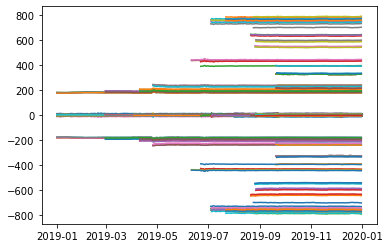

In [197]:
total_df = pd.DataFrame(total, columns=['crypto1', 'crypto2', 'hurst', 'halflife', 'weight1', 'weight2', 'series'])

for i in range(len(total)):
    plt.plot(total[i][6])


# Backtesting our cointegrated series

Saving resulting series for a future

In [192]:
#total_df.to_csv('D:/cointegration_pairs_daily with weights 2018.csv',sep=',')
#closes.to_csv('closes_daily top100.csv')
#total_daily = pd.read_csv('cointegration_pairs_hourly.csv', header=0,index_col=0)
#results = coint_johansen(closes.loc['2018', ['BTC','ETH']], 0, 1)


In [326]:
total_df #sample of data with cointegrated series

crypto1 crypto2     hurst  halflife     weight1      weight2  \
0       BTC    DASH  0.358239        28    0.000625     0.209284   
1       BTC    DASH  0.358239        28    0.000625     0.209284   
2       BTC    ATOM  0.358239        28    0.000625     0.209284   
3       BTC    ATOM  0.358239        28    0.000625     0.209284   
4       BTC    CTSI  0.409707       124   -0.000045   -27.078178   
..      ...     ...       ...       ...         ...          ...   
789     MBL    ARPA  0.055821         3   38.036237 -1312.709496   
790     NKN    ALGO  0.062973        15 -334.349913   -21.432068   
791     NKN     FTM  0.028648        12 -202.503116  -469.253322   
792     NKN     LTO  0.355122       -17  -43.249903   -52.739334   
793     NKN    PERL  0.321022       -18   19.021484   -40.593237   

                                                series  
0    Date
2019-04-29    4.061868
2019-04-30    4.14...  
1    Date
2019-04-29    4.061868
2019-04-30    4.14...  
2    Date
2019-04-29    4.061868
2019-04-30    4.14...  
3    Date
2019-04-29    4.061868
2019-04-30    4.14...  
4    Date
2019-04-18   -5.018362
2019-04-19   -5.32...  
..                                                 ...  
789  Date
2019-08-27    2.167184
2019-08-28    1.01...  
790  Date
2019-08-27   -13.978057
2019-08-28   -11....  
791  Date
2019-08-27   -10.822878
2019-08-28   -10....  
792  Date
2019-08-27   -6.286097
2019-08-28   -5.41...  
793  Date
2019-08-27   -6.260255
2019-08-28   -5.89...  

[794 rows x 7 columns]

In [237]:
#!pip install pyfinance

In [203]:
from pyfinance import ols

Filter our series by Half-life and Hurst Exponent

In [204]:
opt_pairs = total_df.loc[(total_df['halflife']>0) & (total_df['halflife']<15) & (total_df['hurst']>0) & (total_df['hurst']<30)]
opt_pairs.head()

crypto1 crypto2     hurst  halflife    weight1      weight2  \
14     ETH    DOGE  0.073851         9   0.071518 -5714.010897   
17     XRP    DOGE  0.211619        10  58.331300 -8913.483586   
22    LINK     FTM  0.196935        11   1.128806  -364.006193   
31     XRP    DOGE  0.211619        10  58.331300 -8913.483586   
35     LTC     FTM  0.129033        10   1.479476  -389.286040   

                                               series  
14  Date
2019-07-05   -1.554508
2019-07-06    0.61...  
17  Date
2019-07-05   -12.399593
2019-07-06    -8....  
22  Date
2019-06-11   -2.507455
2019-06-12   -1.98...  
31  Date
2019-07-05   -12.399593
2019-07-06    -8....  
35  Date
2019-06-11   -3.272641
2019-06-12   -3.02...

Function for checking each pair for equal time interval 

In [267]:
def start_date(cur1,cur2):
    if cur1.index[0] <= cur2.index[0]:
        start = cur2.index[0]
    else:
        start = cur1.index[0]
    if cur1.index[-1] <= cur2.index[-1]:
        end = cur1.index[-1]
    else:
        end =cur1.index[-1]
    return start, end


Backtesting our pairs on 2019 and calculating ARP, Sharpe ratio. 

In [294]:
#optimal pairs
returns = []
for i in range(len(opt_pairs)):
    try:
        
        x = closes[opt_pairs.iloc[i].crypto1].loc['2019'].dropna()
        y = closes[opt_pairs.iloc[i].crypto2].loc['2019'].dropna()
        start,end = start_date(x,y)
        x = x[(x.index >= "{}".format(start)) & (x.index <= "{}".format(end))]
        y = y[(y.index >= "{}".format(start)) & (y.index <= "{}".format(end))]

        name1 = opt_pairs.iloc[i].crypto1
        name2 = opt_pairs.iloc[i].crypto2
        data = pd.DataFrame(columns=[opt_pairs.iloc[i].crypto1,opt_pairs.iloc[i].crypto2])
        data['{}'.format(opt_pairs.iloc[i].crypto1)] = x
        data['{}'.format(opt_pairs.iloc[i].crypto2)] = y
        data.dropna(inplace=True)
        # lookback period for calculating the dynamically changing
        lookback = opt_pairs.iloc[i].halflife
        y = y 
        x = data 
        model = ols.PandasRollingOLS(y = y, x=x, window=lookback)
        data = data[lookback-1:]
        betas = model.beta

        # calculate the number of units for the strategy in the form
        # y-beta*x
        yport = pd.DataFrame(data['{}'.format(name1)] - (betas['{}'.format(name2)] * data['{}'.format(name2)]))

        moving_mean = yport.rolling(window=lookback).mean()
        moving_std = yport.rolling(window=lookback).std()
        # the number of units of the syntetic portfolio is given by the
        # negative value of z-score
        numunits = pd.DataFrame(-(yport - moving_mean) / moving_std)

        # compute the $ position for each asset
        AA = pd.DataFrame(repmat(numunits,1,2))
        BB = pd.DataFrame(-betas['{}'.format(name2)])
        BB['ones'] = np.ones((len(betas)))
        position = multiply(multiply(AA, BB), data)

        # compute the daily pnl in $$
        pnl = sum(multiply(position[:-1], divide(diff(data,axis = 0), data[:-1])),1)


        # gross market value of portfolio
        mrk_val = pd.DataFrame.sum(abs(position), axis=1)
        mrk_val = mrk_val[:-1]

        # return is P&L divided by gross market value of portfolio
        rtn = pnl / mrk_val

        # compute performance statistics
        sharpe = (np.sqrt(252)*np.mean(rtn)) / np.std(rtn)
        APR = np.prod(1+rtn)**(252/len(rtn))-1

        ##################################################
        # print the results
        ##################################################
        #print('Price spread Sharpe: {:.4}'.format(sharpe))
        #print('Price Spread APR: {:.4%}'.format(APR))


        #*************************************************
        # plotting the chart
        #*************************************************    
        #plot of numunits
        #fig = plt.figure(figsize=(10,8))
        #ax = fig.add_subplot(111)
        '''plt.figure(figsize=(15,10))
        plt.plot(cumsum(rtn))
        plt.title('{}-{} Price Spread Acum Return'.format(name1, name2))
        plt.xlabel('Data points')
        plt.ylabel('acumm rtn')
        plt.text(1000, 0, 'Sharpe: {:.4}'.format(sharpe))
        plt.text(1000, -0.03, 'APR: {:.4%}'.format(APR))
        plt.show()'''

    
        returns.append([name1,name2,sharpe,APR,yport,rtn,pnl,mrk_val])
    
    except:
        pass


Unite all data in one table, sorting them by Return at the end of 2019 and ploting destribution of ARP for each pair

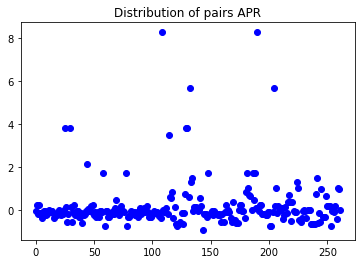

In [323]:
sorted_ret=pd.DataFrame(returns)
sorted_ret.columns = ['crypto1', 'crypto2', 'sharpe','APR','Mean Reverting','Return','PnL','Market Value']
#sorted_ret['return'] = sorted_ret['return'].astype(float)

total_ret = []
for i in range(len(sorted_ret)):
    tot_return = sorted_ret.iloc[i]['Return'].iloc[-1]
    total_ret.append(tot_return)

total_ret = pd.DataFrame(total_ret)

sorted_ret['return'] = total_ret
sorted_ret=sorted_ret.sort_values('return', ascending=False)
sorted_ret.dropna(inplace=True)
plt.plot(sorted_ret['APR'],'bo')
plt.title("Distribution of pairs APR")
plt.show()

Sorted table

In [299]:
sorted_ret

crypto1 crypto2    sharpe       APR  \
77      XMR     OGN  1.557518  1.716960   
58      XMR     OGN  1.557518  1.716960   
186     OGN     XMR  1.557518  1.716960   
188     OGN     XMR  1.557518  1.716960   
108    CTSI     OGN  2.977244  8.263913   
..      ...     ...       ...       ...   
171     FTM     ONE -0.518892 -0.483016   
227     ONE    ARPA -0.705253 -0.558387   
244    ARPA     ONE -0.705253 -0.558387   
174     FTM     NKN  0.261379  0.002991   
261     NKN     FTM  0.261379  0.002991   

                                        Mean Reverting  \
77                     0
Date               
2019-0...   
58                     0
Date               
2019-0...   
186                    0
Date               
2019-0...   
188                    0
Date               
2019-0...   
108                    0
Date               
2019-0...   
..                                                 ...   
171                    0
Date               
2019-0...   
227                    0
Date               
2019-0...   
244                    0
Date               
2019-0...   
174                     0
Date                
2019...   
261                     0
Date                
2019...   

                                                Return  \
77   0           NaN
1           NaN
2           Na...   
58   0           NaN
1           NaN
2           Na...   
186  0           NaN
1           NaN
2           Na...   
188  0           NaN
1           NaN
2           Na...   
108  0           NaN
1           NaN
2           Na...   
..                                                 ...   
171  0           NaN
1           NaN
2           Na...   
227  0           NaN
1           NaN
2           Na...   
244  0           NaN
1           NaN
2           Na...   
174  0           NaN
1           NaN
2           Na...   
261  0           NaN
1           NaN
2           Na...   

                                                   PnL  \
77   0      0.000000
1      0.000000
2      0.00000...   
58   0      0.000000
1      0.000000
2      0.00000...   
186  0      0.000000
1      0.000000
2      0.00000...   
188  0      0.000000
1      0.000000
2      0.00000...   
108  0      0.000000
1      0.000000
2      0.00000...   
..                                                 ...   
171  0      0.000000
1      0.000000
2      0.00000...   
227  0      0.000000
1      0.000000
2      0.00000...   
244  0      0.000000
1      0.000000
2      0.00000...   
174  0      0.000000
1      0.000000
2      0.00000...   
261  0      0.000000
1      0.000000
2      0.00000...   

                                          Market Value    return  
77   0      0.000000
1      0.000000
2      0.00000...  0.122660  
58   0      0.000000
1      0.000000
2      0.00000...  0.122660  
186  0      0.000000
1      0.000000
2      0.00000...  0.122660  
188  0      0.000000
1      0.000000
2      0.00000...  0.122660  
108  0      0.000000
1      0.000000
2      0.00000...  0.105691  
..                                                 ...       ...  
171  0      0.000000
1      0.000000
2      0.00000... -0.035804  
227  0      0.000000
1      0.000000
2      0.00000... -0.036709  
244  0      0.000000
1      0.000000
2      0.00000... -0.036709  
174  0      0.000000
1      0.000000
2      0.00000... -0.083083  
261  0      0.000000
1      0.000000
2      0.00000... -0.083083  

[262 rows x 9 columns]

Checking our cointegrated series for stationarity using Dicky-Fuller test.

In [320]:
from statsmodels.tsa.stattools import adfuller


mean_reverting = []
for i in range(len(sorted_ret)):
    X = sorted_ret['Mean Reverting'].iloc[i].iloc[:,0].values
    result = adfuller(X)
    
    if result[0] > result[4]['5%']: 
        pass
    else:
        mean_reverting.append([X,sorted_ret['crypto1'].iloc[i],sorted_ret['crypto2'].iloc[i]])
        
        
mean_rev = pd.DataFrame(mean_reverting)
mean_rev.columns = ['series','crypto1','crypto2']
mean_rev.head()

series crypto1 crypto2
0  [-0.4260000000000031, -0.4248299999999969, -0....     XMR     OGN
1  [-0.4260000000000031, -0.4248299999999969, -0....     XMR     OGN
2  [0.4260000000000004, 0.42482999999999954, 0.38...     OGN     XMR
3  [0.4260000000000004, 0.42482999999999954, 0.38...     OGN     XMR
4  [-0.4127000000000068, -0.41600000000001364, -0...    CTSI     OGN

# Conclusion

The most promising cointegrated mean reverting pair is XMR/USDT and	OGN/USDT with Sharpe ratio of 1.558 and  ARP=1.716960. Below you can see plot of its pnl in 2019.	

In [341]:
opt_pairs.loc[(opt_pairs.crypto1=='XMR') & (opt_pairs.crypto2=='OGN')].iloc[0]

crypto1                                                   XMR
crypto2                                                   OGN
hurst                                                0.300399
halflife                                                   12
weight1                                              -35.8187
weight2                                              -10.6089
series      Date
2019-08-24   -6.249391
2019-08-25   -7.97...
Name: 200, dtype: object

In [343]:
opt_pairs.iloc[0].crypto1

'ETH'

Price spread Sharpe: 1.874
Price Spread APR: 325.3356%


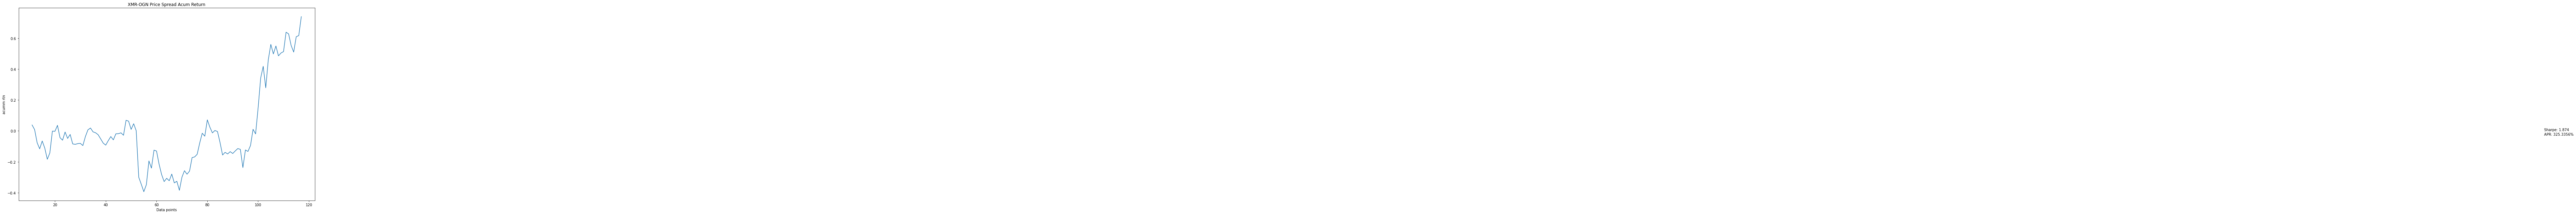

In [347]:
x = closes['XMR'].loc['2019'].dropna()
y = closes['OGN'].loc['2019'].dropna()
start,end = start_date(x,y)
x = x[(x.index >= "{}".format(start)) & (x.index <= "{}".format(end))]
y = y[(y.index >= "{}".format(start)) & (y.index <= "{}".format(end))]

name1 = 'XMR'
name2 = 'OGN'
data = pd.DataFrame(columns=['XMR','OGN'])
data['XMR'] = x
data['OGN'] = y
data.dropna(inplace=True)
# lookback period for calculating the dynamically changing
lookback = 12
y = y 
x = data 
model = ols.PandasRollingOLS(y = y, x=x, window=lookback)
data = data[lookback-1:]
betas = model.beta

# calculate the number of units for the strategy in the form
# y-beta*x
yport = pd.DataFrame(data['XMR'] - (betas['OGN'] * data['OGN']))

moving_mean = yport.rolling(window=lookback).mean()
moving_std = yport.rolling(window=lookback).std()
# the number of units of the syntetic portfolio is given by the
# negative value of z-score
numunits = pd.DataFrame(-(yport - moving_mean) / moving_std)

# compute the $ position for each asset
AA = pd.DataFrame(repmat(numunits,1,2))
BB = pd.DataFrame(-betas['{}'.format(name2)])
BB['ones'] = np.ones((len(betas)))
position = multiply(multiply(AA, BB), data)

# compute the daily pnl in $$
pnl = sum(multiply(position[:-1], divide(diff(data,axis = 0), data[:-1])),1)


# gross market value of portfolio
mrk_val = pd.DataFrame.sum(abs(position), axis=1)
mrk_val = mrk_val[:-1]

# return is P&L divided by gross market value of portfolio
rtn = pnl / mrk_val

# compute performance statistics
sharpe = (np.sqrt(365)*np.mean(rtn)) / np.std(rtn)
APR = np.prod(1+rtn)**(365/len(rtn))-1

##################################################
# print the results
##################################################
print('Price spread Sharpe: {:.4}'.format(sharpe))
print('Price Spread APR: {:.4%}'.format(APR))


#*************************************************
# plotting the chart
#*************************************************    
#plot of numunits

plt.figure(figsize=(15,10))
plt.plot(cumsum(rtn))
plt.title('{}-{} Price Spread Acum Return'.format(name1, name2))
plt.xlabel('Data points')
plt.ylabel('acumm rtn')
plt.text(1000, 0, 'Sharpe: {:.4}'.format(sharpe))
plt.text(1000, -0.03, 'APR: {:.4%}'.format(APR))
plt.show()

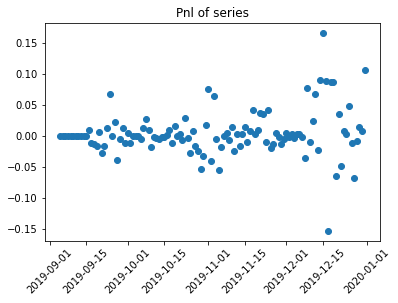

In [361]:
plt.scatter(data.index[1:],pnl)
plt.title('Pnl of series')
plt.xticks(rotation=45)
plt.show()